In [2]:
import pandas as pd
import numpy as np
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import keras
import matplotlib
import matplotlib.pyplot as plt
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot

In [1]:
import sklearn
print(sklearn.__version__)

1.3.0


In [3]:
df=pd.read_csv('historic_demand_2009_2024.csv',index_col=0)

In [4]:
df.head()

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
0      2009-01-01                  1  37910  38704                 33939   
1      2009-01-01                  2  38047  38964                 34072   
2      2009-01-01                  3  37380  38651                 33615   
3      2009-01-01                  4  36426  37775                 32526   
4      2009-01-01                  5  35687  37298                 31877   

   embedded_wind_generation  embedded_wind_capacity  \
0                        54                    1403   
1                        53                    1403   
2                        53                    1403   
3                        50                    1403   
4                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                          0                        0            0  ...   
1                          0                        0            0  ...   
2                          0                        0            0  ...   
3                          0                        0            0  ...   
4                          0                        0            0  ...   

   ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  \
0          0             0        -161               0          0       NaN   
1          0             0        -160               0          0       NaN   
2          0             0        -160               0          0       NaN   
3          0             0        -160               0          0       NaN   
4          0             0        -160               0          0       NaN   

   eleclink_flow  scottish_transfer  viking_flow  is_holiday  
0            NaN                NaN          NaN           1  
1            NaN                NaN          NaN           1  
2            NaN                NaN          NaN           1  
3            NaN                NaN          NaN           1  
4            NaN                NaN          NaN           1  

[5 rows x 22 columns]

In [5]:
df.describe()

settlement_period             nd            tsd  england_wales_demand  \
count      269518.000000  269518.000000  269518.000000         269518.000000   
mean           24.500052   31421.101622   32845.740266          28595.208190   
std            13.853720    7800.569929    7697.098445           7067.996992   
min             1.000000   13367.000000       0.000000              0.000000   
25%            12.250000   25174.000000   26828.000000          22911.000000   
50%            24.000000   30787.000000   32033.000000          28011.000000   
75%            36.000000   37138.000000   38308.000000          33817.000000   
max            50.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             269518.000000           269518.000000   
mean                1256.001866             4370.017483   
std                  959.082915             1948.406417   
min                    0.000000             1403.000000   
25%                  542.000000             2092.000000   
50%                 1004.000000             4403.000000   
75%                 1707.000000             6504.000000   
max                 5587.000000             6574.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              269518.000000            269518.000000  269518.000000   
mean                  842.267856              8353.902815       6.894842   
std                  1653.976944              5716.095657      39.831537   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              1979.000000       0.000000   
50%                     0.000000             11433.000000       0.000000   
75%                   819.750000             13080.000000       0.000000   
max                 10424.000000             15954.000000     893.000000   

       pump_storage_pumping  ...      ifa2_flow   britned_flow     moyle_flow  \
count         269518.000000  ...  269518.000000  269518.000000  269518.000000   
mean             310.017531  ...      38.992672     517.682018    -119.324943   
std              534.449777  ...     339.429676     531.092363     228.524270   
min                0.000000  ...   -1030.000000   -1215.000000    -505.000000   
25%                8.000000  ...       0.000000       0.000000    -286.000000   
50%               11.000000  ...       0.000000     743.000000    -139.000000   
75%              391.000000  ...       0.000000     994.000000      33.000000   
max             2019.000000  ...    1016.000000    1143.000000     499.000000   

       east_west_flow      nemo_flow      nsl_flow  eleclink_flow  \
count   269518.000000  269518.000000  94222.000000   94222.000000   
mean       -40.603615     164.927441    337.273429      68.657150   
std        257.832168     409.725313    614.904355     468.719226   
min       -585.000000   -1022.000000  -1455.000000   -1028.000000   
25%       -177.000000       0.000000      0.000000       0.000000   
50%          0.000000       0.000000      0.000000       0.000000   
75%          0.000000     169.000000    766.000000       0.000000   
max        504.000000    1033.000000   1401.000000    1002.000000   

       scottish_transfer   viking_flow     is_holiday  
count       24094.000000  24094.000000  269518.000000  
mean         1759.222088    122.967959       0.022974  
std          1933.049829    412.649836       0.149822  
min         -2851.000000  -1465.000000       0.000000  
25%           231.250000      0.000000       0.000000  
50%          1563.500000      0.000000       0.000000  
75%          3192.000000      0.000000       0.000000  
max          6585.000000   1425.000000       1.000000  

[8 rows x 21 columns]

In [6]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
scottish_transfer             True
viking_flow                   True
is_holiday                   False
dtype: bool

In [7]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
        df["scottish_transfer"].isna().value_counts().to_frame(),
        df["viking_flow"].isna().value_counts().to_frame()
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow",2:"scottish_transfer",3:"viking_flow"})

nsl_flow  eleclink_flow  scottish_transfer  viking_flow
True     175296         175296             245424       245424
False     94222          94222              24094        24094

In [8]:
df.loc[(df["scottish_transfer"].isna()) | (df["viking_flow"].isna()), :]

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
0           2009-01-01                  1  37910  38704                 33939   
1           2009-01-01                  2  38047  38964                 34072   
2           2009-01-01                  3  37380  38651                 33615   
3           2009-01-01                  4  36426  37775                 32526   
4           2009-01-01                  5  35687  37298                 31877   
...                ...                ...    ...    ...                   ...   
245419      2022-12-31                 44  24160  25634                 21879   
245420      2022-12-31                 45  23223  24788                 21040   
245421      2022-12-31                 46  22627  24365                 20466   
245422      2022-12-31                 47  21690  24766                 19587   
245423      2022-12-31                 48  21229  24843                 19157   

        embedded_wind_generation  embedded_wind_capacity  \
0                             54                    1403   
1                             53                    1403   
2                             53                    1403   
3                             50                    1403   
4                             50                    1403   
...                          ...                     ...   
245419                      2592                    6545   
245420                      2701                    6545   
245421                      2810                    6545   
245422                      2823                    6545   
245423                      2836                    6545   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                               0                        0            0  ...   
1                               0                        0            0  ...   
2                               0                        0            0  ...   
3                               0                        0            0  ...   
4                               0                        0            0  ...   
...                           ...                      ...          ...  ...   
245419                          0                    13861            0  ...   
245420                          0                    13861            0  ...   
245421                          0                    13861            0  ...   
245422                          0                    13861            0  ...   
245423                          0                    13861            0  ...   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
0               0             0        -161               0          0   
1               0             0        -160               0          0   
2               0             0        -160               0          0   
3               0             0        -160               0          0   
4               0             0        -160               0          0   
...           ...           ...         ...             ...        ...   
245419        982          1002        -451            -239        999   
245420        353           473        -451            -390        789   
245421        302           422        -451            -514        772   
245422        863          -679        -451            -527        289   
245423        915          -880        -451            -529        252   

        nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  
0            NaN            NaN                NaN          NaN           1  
1            NaN            NaN                NaN          NaN           1  
2            NaN            NaN                NaN          NaN           1  
3            NaN            NaN                NaN          NaN           1  
4            NaN            NaN                NaN          NaN          

In [6]:
df.drop(columns=["nd","england_wales_demand",'embedded_wind_capacity',"embedded_solar_capacity", 'non_bm_stor', 'pump_storage_pumping',
       'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow','nemo_flow',"nsl_flow", "eleclink_flow","scottish_transfer","viking_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [10]:
df.head()

settlement_date  settlement_period    tsd  embedded_wind_generation  \
0      2009-01-01                  1  38704                        54   
1      2009-01-01                  2  38964                        53   
2      2009-01-01                  3  38651                        53   
3      2009-01-01                  4  37775                        50   
4      2009-01-01                  5  37298                        50   

   embedded_solar_generation  is_holiday  
0                          0           1  
1                          0           1  
2                          0           1  
3                          0           1  
4                          0           1

In [7]:
# Create a datetime column based on settlement_date and settlement_period
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df['datetime'] = df['settlement_date'] + pd.to_timedelta((df['settlement_period'] - 1) * 30, unit='T')

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

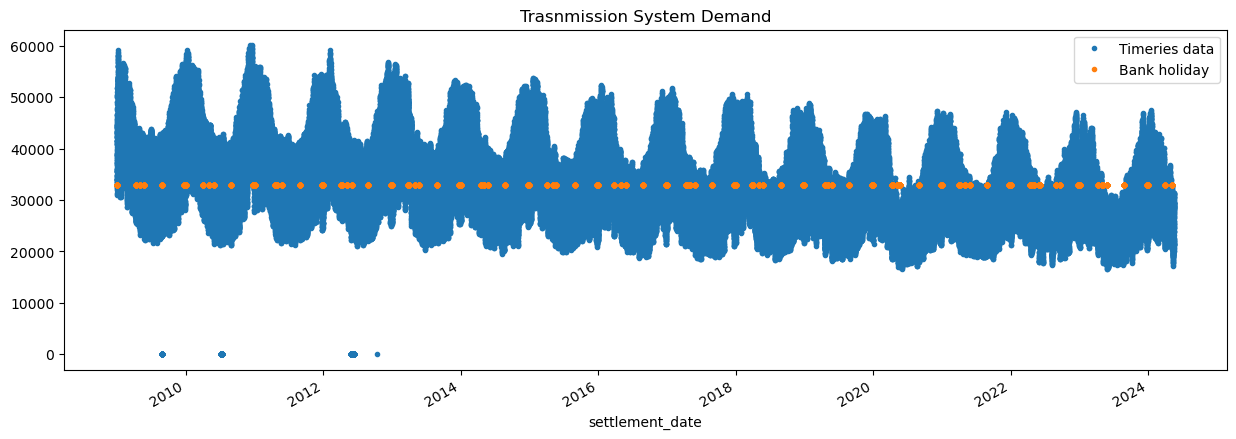

In [12]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

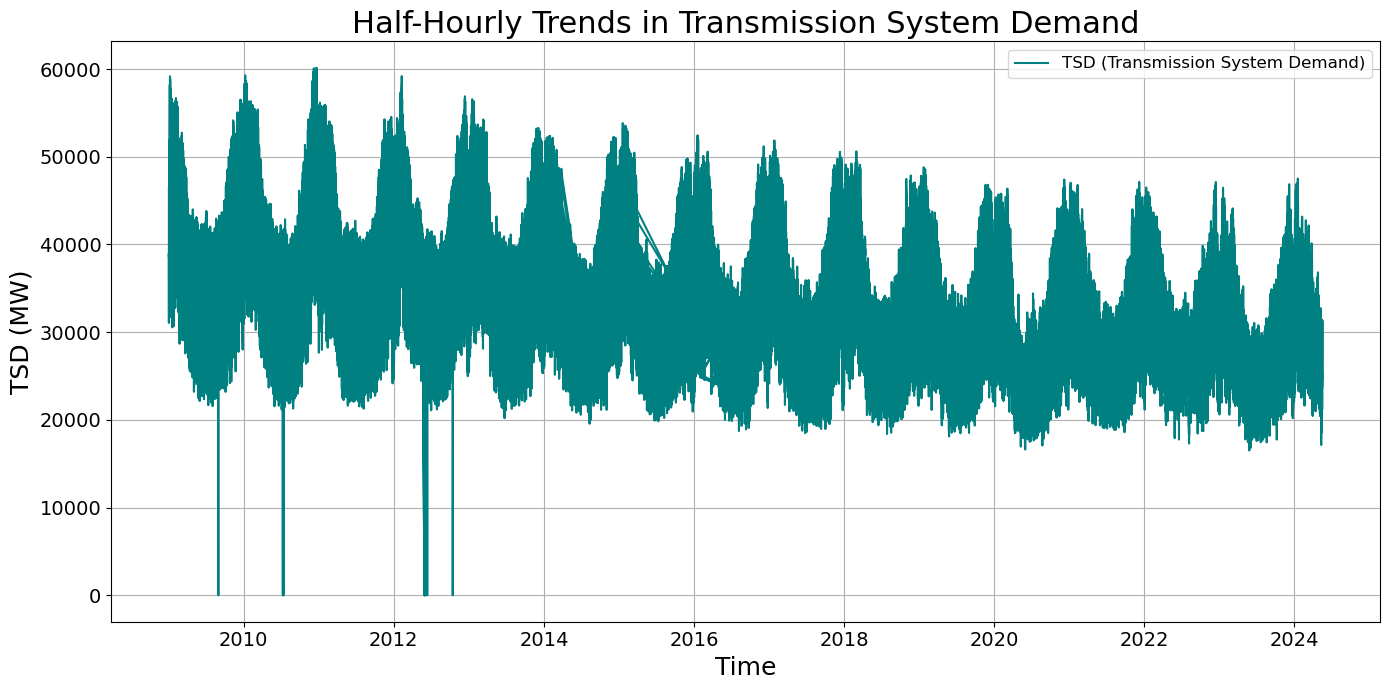

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and 'tsd' is the column for Transmission System Demand
# Convert the index to a datetime index if it's not already
df.index = pd.to_datetime(df.index)

# Plotting the time series data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['tsd'], label='TSD (Transmission System Demand)',color='teal')
plt.title('Half-Hourly Trends in Transmission System Demand', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('TSD (MW)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig('tsd_over_time.png')

plt.show()


### handling missing values

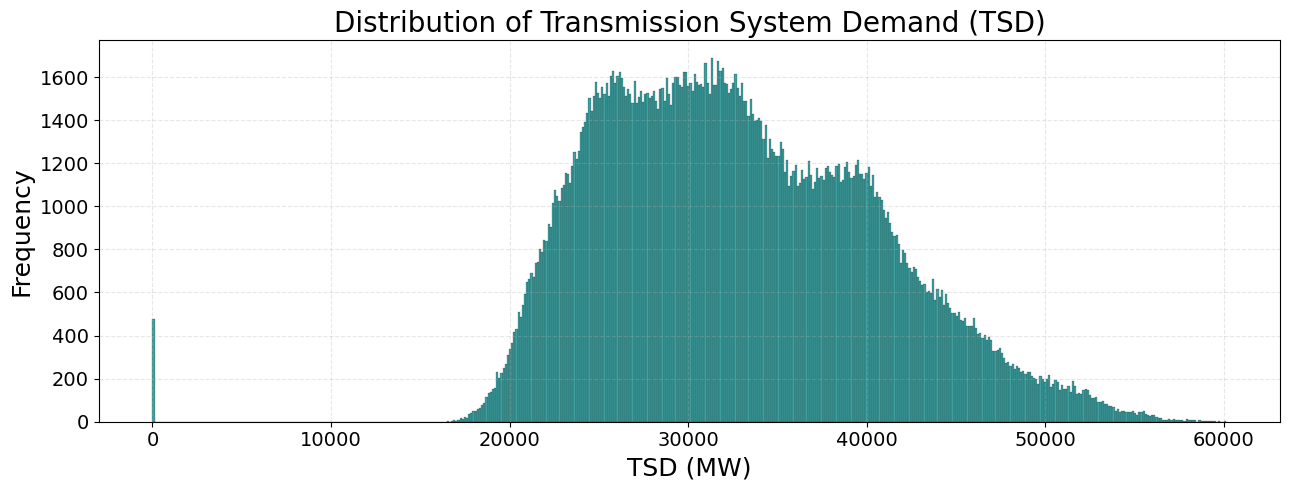

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axis objects with specified size
fig, ax = plt.subplots(figsize=(13, 5))

# Plot the histogram
sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="teal")

# Set the title and labels with increased font sizes
ax.set_title('Distribution of Transmission System Demand (TSD)', fontsize=20)
ax.set_xlabel('TSD (MW)', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)

# Increase the size of tick labels on both axes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# Add a faded grid
ax.grid(True, linestyle='--', alpha=0.3)
# Save the plot if needed
plt.savefig('outlier.png')

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
# Forward fill to handle zero 'tsd' values and ensure continuity

df['tsd'] = df['tsd'].replace(0, pd.NA)  # Replace zero with NA to enable ffill
df = df.ffill()  # Forward fill missing values

# Drop the original settlement_date and settlement_period columns as they are now redundant
df.drop(columns=['settlement_date', 'settlement_period'], inplace=True)



In [9]:
nan_counts = df.isna().sum()
print(nan_counts)


tsd                          0
embedded_wind_generation     0
embedded_solar_generation    0
is_holiday                   0
dtype: int64


### Aggregation of Half-Hourly Data to Daily Averages

In [10]:
# Resample to daily mean for numerical columns
daily_data = df.resample('D').mean().round(2)

# Handle the 'is_holiday' column for daily data (use max to ensure if any part of the day is a holiday, the entire day is considered a holiday)
daily_data['holidays'] = df['is_holiday'].resample('D').max()
daily_data.drop(columns=['is_holiday'], axis=1, inplace=True)

In [262]:
daily_data.shape

(5615, 4)

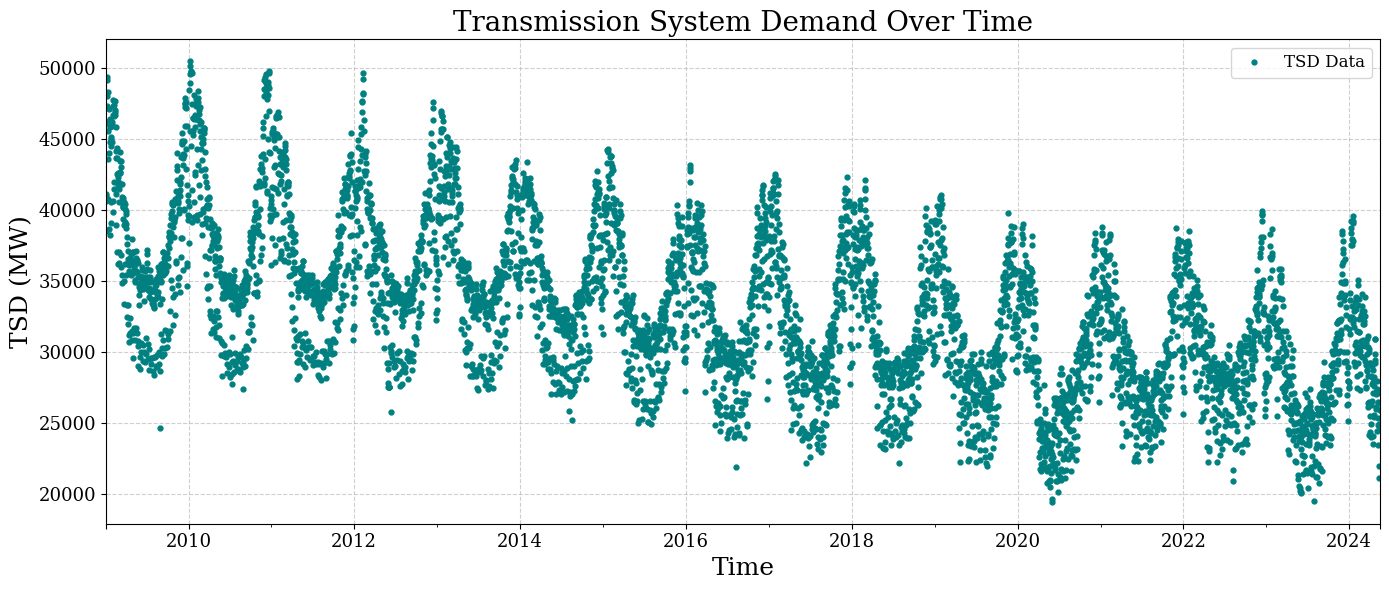

In [19]:
import matplotlib.pyplot as plt

# Use Matplotlib's math text for LaTeX-like rendering without external LaTeX dependencies
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Create a copy of the dataframe for plotting
df_plot = daily_data.copy()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the Transmission System Demand (TSD) with enhancements
df_plot["tsd"].plot(
    style=".",  # Using both points and a line
    color="teal",  # Changing the color to teal
    ax=ax, 
    title="Transmission System Demand Over Time", 
    label="TSD Data",
    linewidth=1.5,  # Setting the line width
    markersize=7  # Setting the marker size,
)
# Set the title with an increased font size
ax.set_title('Transmission System Demand Over Time', fontsize=20)
# Set the labels for x and y axes with increased font sizes
ax.set_xlabel("Time", fontsize=18)
ax.set_ylabel("TSD (MW)", fontsize=18)

# Increase the size of tick labels on both axes
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Display the legend with a slightly larger font
ax.legend(fontsize=12)

# Save the plot with high resolution
fig.savefig('tsd_fig.png', format='png', dpi=300)

# Adjust the layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

### outlier detection

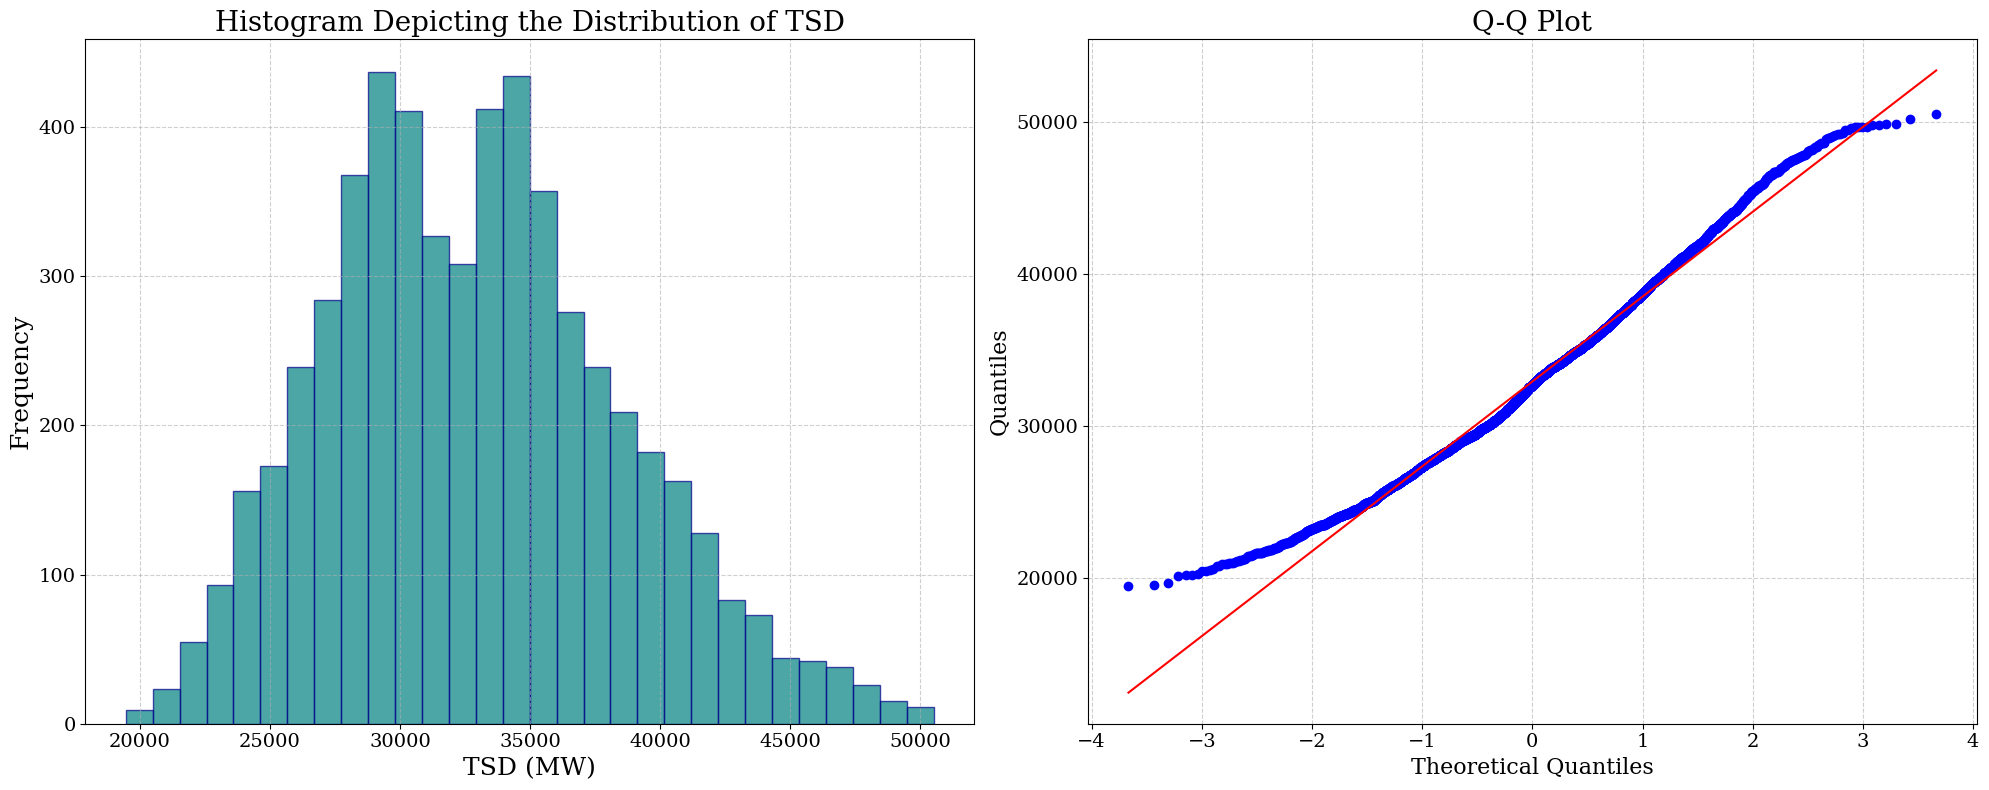

In [20]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Create a figure with two subplots arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Histogram
axs[0].hist(
    daily_data['tsd'],
    bins=30,
    color='teal',
    edgecolor='darkblue',
    alpha=0.7
)
axs[0].set_title('Histogram Depicting the Distribution of TSD', fontsize=20, family='serif')
axs[0].set_xlabel('TSD (MW)', fontsize=18, family='serif')
axs[0].set_ylabel('Frequency', fontsize=18, family='serif')
axs[0].tick_params(axis='x', labelsize=14, colors='black')
axs[0].tick_params(axis='y', labelsize=14, colors='black')
axs[0].grid(True, linestyle='--', alpha=0.6)

# Q-Q Plot
stats.probplot(daily_data['tsd'], dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot', fontsize=20, family='serif')
axs[1].set_xlabel('Theoretical Quantiles', fontsize=16, family='serif')
axs[1].set_ylabel('Quantiles', fontsize=16, family='serif')
axs[1].tick_params(axis='x', labelsize=14, colors='black')
axs[1].tick_params(axis='y', labelsize=14, colors='black')
axs[1].grid(True, linestyle='--', alpha=0.6)



# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined plot with high resolution
plt.savefig('combined_plots_tsd_distribution.png', format='png', dpi=300)

# Show the plots
plt.show()


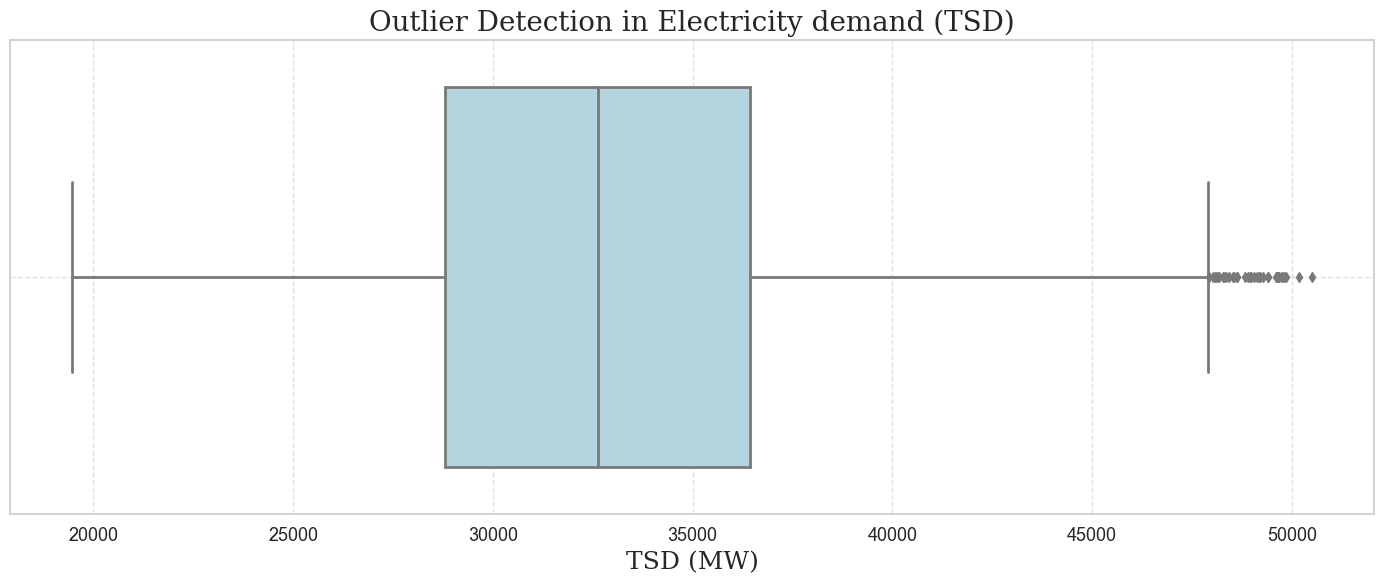

In [21]:
# Use Matplotlib's math text for LaTeX-like rendering without external LaTeX dependencies
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Set the style using Seaborn
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Create the box plot
sns.boxplot(x=daily_data['tsd'], color='lightblue', linewidth=2, ax=ax)

# Set the title with consistent font settings
ax.set_title('Outlier Detection in Electricity demand (TSD)', fontsize=20, fontfamily='serif')

# Set the labels for x-axis with consistent font settings
ax.set_xlabel('TSD (MW)', fontsize=18, fontfamily='serif')
ax.set_ylabel('', fontsize=18, fontfamily='serif')  # No y-axis label needed for horizontal box plot

# Increase the size of tick labels on the x-axis
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Save the plot with high resolution
fig.savefig('box_plot_tsd.png', format='png', dpi=300)

# Adjust the layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
Q1 = daily_data['tsd'].quantile(0.25)
Q3 = daily_data['tsd'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = daily_data[(daily_data['tsd'] < lower_bound) | (daily_data['tsd'] > upper_bound)]

print("Number of outliers detected:", outliers.shape[0])


Number of outliers detected: 36


In [12]:
# Try with a higher multiplier
multiplier = 1.5  
lower_bound = Q1 - multiplier * IQR
upper_bound = Q3 + multiplier * IQR

# Filter out the outliers again
daily_data = daily_data[(daily_data['tsd'] >= lower_bound) & (daily_data['tsd'] <= upper_bound)]

# Check remaining outliers
outliers = daily_data[(daily_data['tsd'] < lower_bound) | (daily_data['tsd'] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])


Number of outliers detected: 0


### Feature Engineering

In [13]:
# Extracting features
daily_data['year'] = daily_data.index.year.astype(int)
daily_data['month'] = daily_data.index.month.astype(int)
daily_data['quarter'] = daily_data.index.quarter.astype(int)
daily_data['week'] = daily_data.index.isocalendar().week.astype("int64")

In [14]:
def add_lags(df):
    target_map = df['tsd'].to_dict()
    daily_data['lag1'] = (daily_data.index - pd.Timedelta('364 days')).map(target_map)
    daily_data['lag2'] = (daily_data.index - pd.Timedelta('728 days')).map(target_map)
    daily_data['lag3'] = (daily_data.index - pd.Timedelta('1092 days')).map(target_map)
    df["rolling_mean_4"] = df["tsd"].rolling(window=4).mean()
    df["rolling_std_4"] = df["tsd"].rolling(window=4).std()
    return daily_data
daily_data=add_lags(daily_data)

In [11]:
daily_data.isna().sum()

tsd                             0
embedded_wind_generation        0
embedded_solar_generation       0
holidays                        0
year                            0
month                           0
quarter                         0
week                            0
lag1                          392
lag2                          730
lag3                         1096
rolling_mean_4                  3
rolling_std_4                   3
dtype: int64

In [268]:
daily_data.shape

(5579, 13)

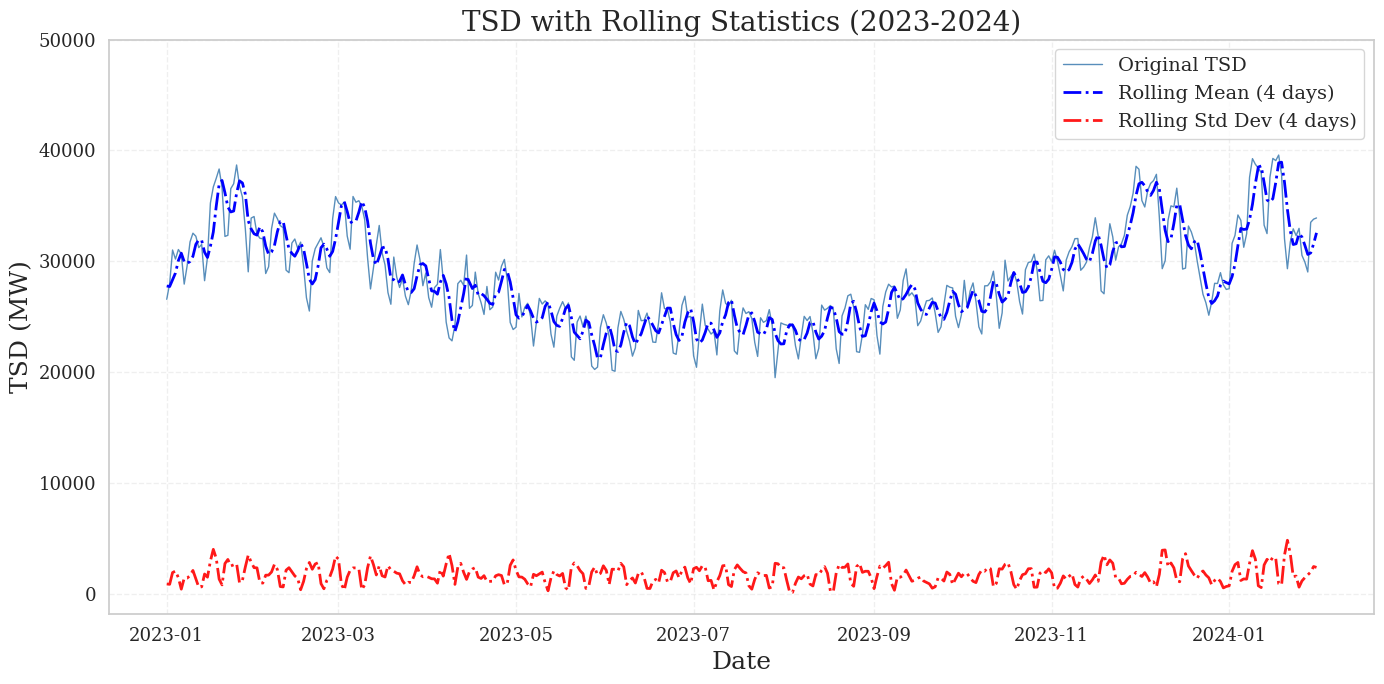

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Use Matplotlib's math text for LaTeX-like rendering without external LaTeX dependencies
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Filter data to include only from January 2023 to January 2024
filtered_data = daily_data.loc['2023-01':'2024-01']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the original TSD data
ax.plot(filtered_data.index, filtered_data['tsd'], 
        color='steelblue',  # Light blue for the original data
        linestyle='-',  # Solid line style
        linewidth=1,  # Adjusted line width for better clarity
        alpha=0.9,  # Increased transparency for less visual accumulation
        label='Original TSD')

# Plot the rolling mean
ax.plot(filtered_data.index, filtered_data['rolling_mean_4'], 
        color='blue',  # Blue for the rolling mean
        linestyle='-.',  # Solid line style
        linewidth=2,  # Slightly thicker line for the mean
        label='Rolling Mean (4 days)')

# Plot the rolling standard deviation
ax.plot(filtered_data.index, filtered_data['rolling_std_4'], 
        color='red',  # Red for the rolling std deviation
        linestyle='-.',  # Dash-dot line style
        linewidth=2,  # Slightly thicker line for better distinction
        alpha=0.9,  # Slightly less transparency
        label='Rolling Std Dev (4 days)')

# Set the title with an increased font size
ax.set_title('TSD with Rolling Statistics (2023-2024)', fontsize=20)

# Set the labels for x and y axes with increased font sizes
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('TSD (MW)', fontsize=18)

# Set y-axis ticks at intervals of 10,000
ax.set_yticks(range(0, 60000, 10000))  # Adjust the upper limit as needed

# Increase the size of tick labels on both axes
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.3)  # Faded grid for clarity

# Display the legend with a slightly larger font
ax.legend(fontsize=14)

# Save the plot with high resolution
fig.savefig('tsd_with_rolling_2024_2025.png', format='png', dpi=300)

# Adjust the layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()


### Aggregating daily data to weekly data

In [15]:
# Resample to weekly mean for numerical columns and sum for 'is_holiday'
weekly_data = daily_data.resample('W').mean().round(2)

weekly_data['holidays'] = daily_data['holidays'].resample('W').sum().astype(int)
# Convert the columns to integer type
weekly_data['year'] = weekly_data['year'].astype(int)
weekly_data['month'] = weekly_data['month'].astype(int)
weekly_data['quarter'] = weekly_data['quarter'].astype(int)
weekly_data['week'] = weekly_data['week'].astype(int)


In [16]:
weekly_data.shape

(803, 13)

In [31]:
weekly_data.sample(5)

tsd  embedded_wind_generation  embedded_solar_generation  \
datetime                                                                    
2016-08-07  26972.53                   1337.36                    1662.26   
2020-10-25  29615.96                   1857.60                     681.26   
2015-07-05  30032.24                    889.65                    1905.06   
2010-03-07  43246.17                    440.58                       0.00   
2023-11-19  30566.49                   2181.11                     519.39   

            holidays  year  month  quarter  week      lag1      lag2  \
datetime                                                               
2016-08-07         0  2016      8        3    31  28350.13  30267.82   
2020-10-25         0  2020     10        4    43  31849.37  30819.30   
2015-07-05         0  2015      6        2    27  30885.06  31918.19   
2010-03-07         0  2010      3        1     9  41044.25       NaN   
2023-11-19         0  2023     11        4    46  33095.62  32066.23   

                lag3  rolling_mean_4  rolling_std_4  
datetime                                             
2016-08-07  31311.63        27305.90        2232.48  
2020-10-25  31781.50        30027.33        1235.60  
2015-07-05  33046.44        30017.45        2341.09  
2010-03-07       NaN        42931.07        2143.20  
2023-11-19  30496.22        30949.95        1795.63

### EDA

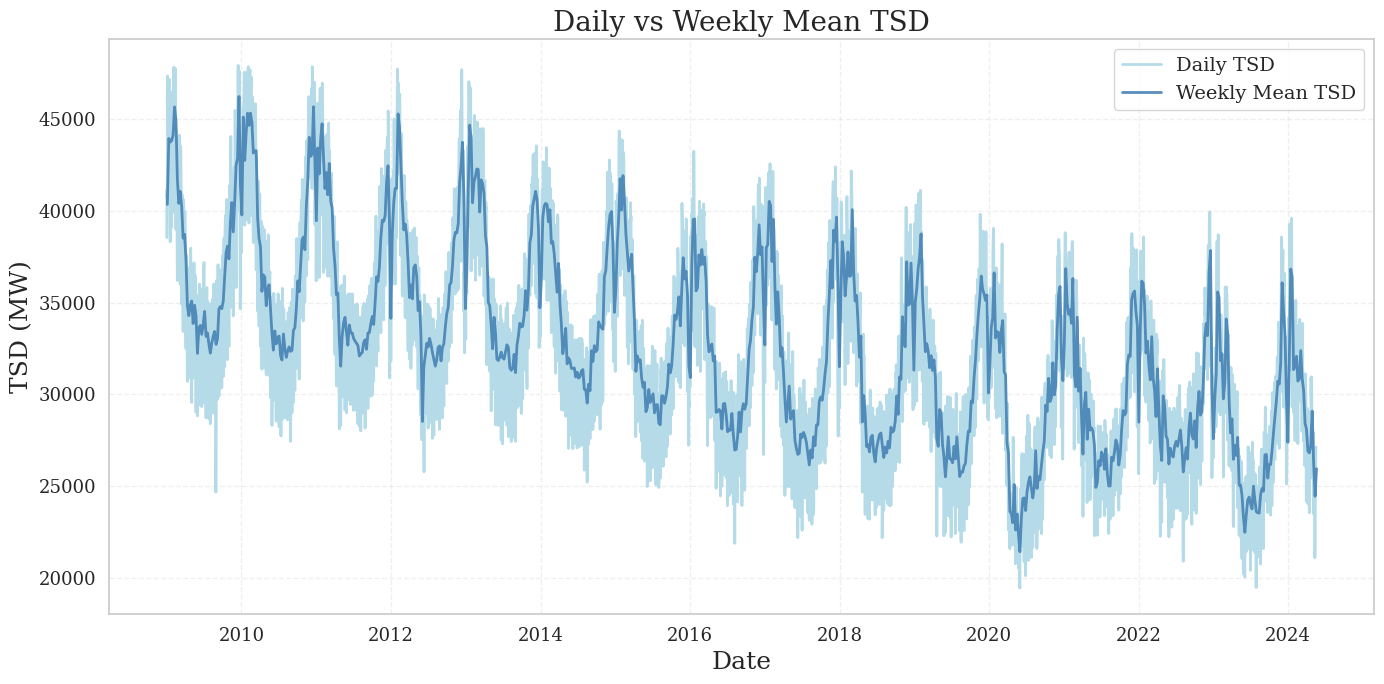

In [32]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the original daily TSD data with reduced transparency and increased line width
ax.plot(daily_data.index, daily_data['tsd'], 
        color='lightblue',  # Color for the daily data
        linestyle='-',  # Solid line style
        linewidth=2,  # Increased line width for daily data
        alpha=0.9,  # Reduced transparency for better visibility
        label='Daily TSD')

# Plot the weekly mean TSD data with a contrasting color and thicker line
ax.plot(weekly_data.index, weekly_data['tsd'], 
        color='steelblue',  # Color for the weekly data
        linestyle='-',  # Solid line style
        linewidth=2,  # Increased line width for weekly data
        alpha=0.9,  # Reduced transparency for better visibility
        label='Weekly Mean TSD')

# Set the title and labels with increased font sizes
ax.set_title('Daily vs Weekly Mean TSD', fontsize=20)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('TSD (MW)', fontsize=18)

# Increase the size of tick labels on both axes
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.3)

# Display the legend with a slightly larger font
ax.legend(fontsize=14)

# Save the plot with high resolution if needed
fig.savefig('daily_vs_weekly_tsd.png', format='png', dpi=300)

# Adjust the layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()


In [33]:
# Describe only specific columns of interest
selected_columns = ['tsd', 'embedded_wind_generation', 'embedded_solar_generation']
summary_statistics = weekly_data[selected_columns].describe()

# Display the summary statistics
summary_statistics

tsd  embedded_wind_generation  embedded_solar_generation
count    803.000000                803.000000                 803.000000
mean   32862.461619               1256.040959                 842.476227
std     5069.958363                714.270945                 795.800031
min    21445.530000                111.600000                   0.000000
25%    28953.695000                691.485000                 142.230000
50%    32560.140000               1132.340000                 585.370000
75%    36210.445000               1681.125000                1512.390000
max    46203.260000               4122.990000                3150.270000

In [34]:
import pandas as pd

# Calculate central tendency measures
mean_values = weekly_data[['tsd', 'embedded_wind_generation', 'embedded_solar_generation']].mean()
median_values = weekly_data[['tsd', 'embedded_wind_generation', 'embedded_solar_generation']].median()
mode_values = weekly_data[['tsd', 'embedded_wind_generation', 'embedded_solar_generation']].mode().iloc[0]

# Create a DataFrame to hold the results
central_tendency_df = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Mode': mode_values
})

# Display the table
central_tendency_df


Mean    Median      Mode
tsd                        32862.461619  32560.14  21445.53
embedded_wind_generation    1256.040959   1132.34    607.86
embedded_solar_generation    842.476227    585.37      0.00

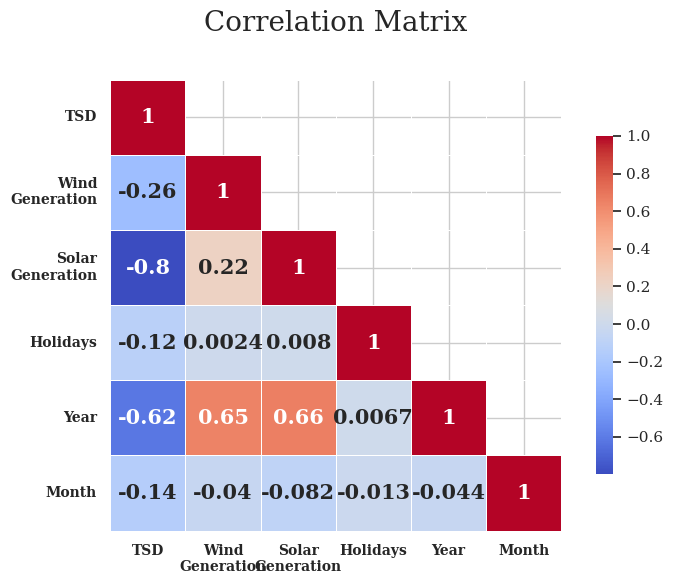

In [35]:


# Calculate the correlation matrix
selected_columns = ['tsd', 'embedded_wind_generation', 'embedded_solar_generation', 'holidays', 'year', 'month']
corr_matrix = weekly_data[selected_columns].corr()

# Mask to cover the upper triangle, excluding the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Custom labels for the plot
custom_labels = {
    'tsd': 'TSD',
    'embedded_wind_generation': 'Wind\nGeneration',
    'embedded_solar_generation': 'Solar\nGeneration',
    'holidays': 'Holidays',
    'year': 'Year',
    'month': 'Month'
}

# Plotting the heatmap with a mask for the upper triangle
fig = plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    mask=mask,  
    annot=True, 
    cmap='coolwarm', 
    annot_kws={"size": 15, "weight": "bold"}, 
    linewidths=0.5, 
    square=True,  
    cbar_kws={"shrink": 0.75},  
)

plt.title('Correlation Matrix', fontsize=20, pad=35, fontfamily='serif')
plt.xticks(
    ticks=plt.xticks()[0], 
    labels=[custom_labels[label.get_text()] for label in plt.xticks()[1]], 
    fontsize=10, rotation=0, ha='center', weight='bold'
)
plt.yticks(
    ticks=plt.yticks()[0], 
    labels=[custom_labels[label.get_text()] for label in plt.yticks()[1]], 
    fontsize=10, rotation=0, weight='bold'
)

fig.savefig('correlation.png', format='png', dpi=300)
plt.tight_layout()
plt.show()


C:\Users\SHREY\AppData\Local\Temp\ipykernel_14560\2360506517.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


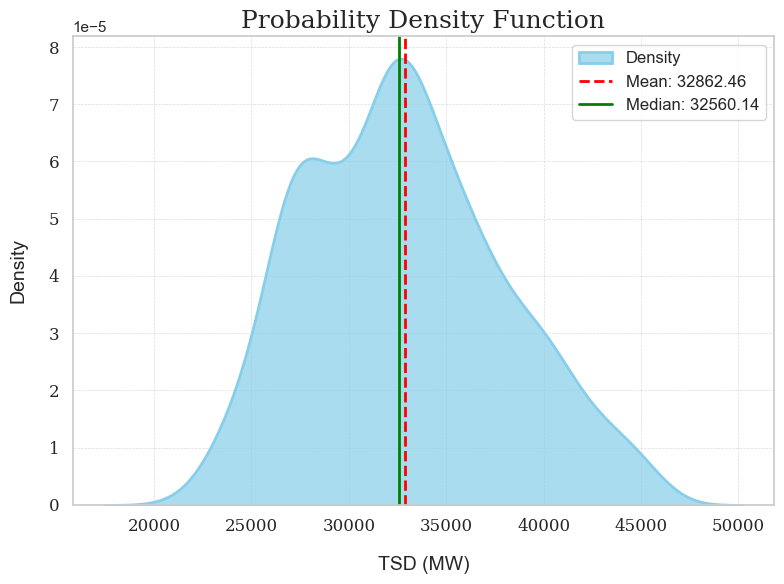

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(8, 6))

# Plot the KDE with enhanced aesthetics
sns.kdeplot(
    weekly_data['tsd'],
    shade=True,
    color="skyblue",
    linewidth=2,
    alpha=0.7,
    label='Density'
)

# Calculate mean and median
mean_tsd = weekly_data['tsd'].mean()
median_tsd = weekly_data['tsd'].median()

# Plot mean and median lines
plt.axvline(mean_tsd, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_tsd:.2f}')
plt.axvline(median_tsd, color='green', linestyle='-', linewidth=2, label=f'Median: {median_tsd:.2f}')

# Add titles and labels with increased font sizes
plt.title('Probability Density Function', fontsize=18, fontfamily='serif')

# Customize the x and y labels with larger font and bold style
plt.xlabel('TSD (MW)', fontsize=14, labelpad=15)
plt.ylabel('Density', fontsize=14, labelpad=15)

# Customize tick parameters for readability
plt.xticks(fontsize=12, fontfamily='serif')
plt.yticks(fontsize=12, fontfamily='serif')

# Add a legend with larger font size
plt.legend(fontsize=12)

# # Adjust the text positions to avoid overlap and ensure visibility
# plt.text(mean_tsd + 10, plt.ylim()[1]*0.85, f'Mean: {mean_tsd:.2f}', fontsize=12, ha='left', va='bottom', fontweight='bold')
# plt.text(median_tsd - 10, plt.ylim()[1]*0.80, f'Median: {median_tsd:.2f}', fontsize=12, ha='right', va='top', fontweight='bold')

# Enhance grid style
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save the plot with high resolution
plt.savefig('pdf.png', format='png', dpi=300)

# Display the plot
plt.show()


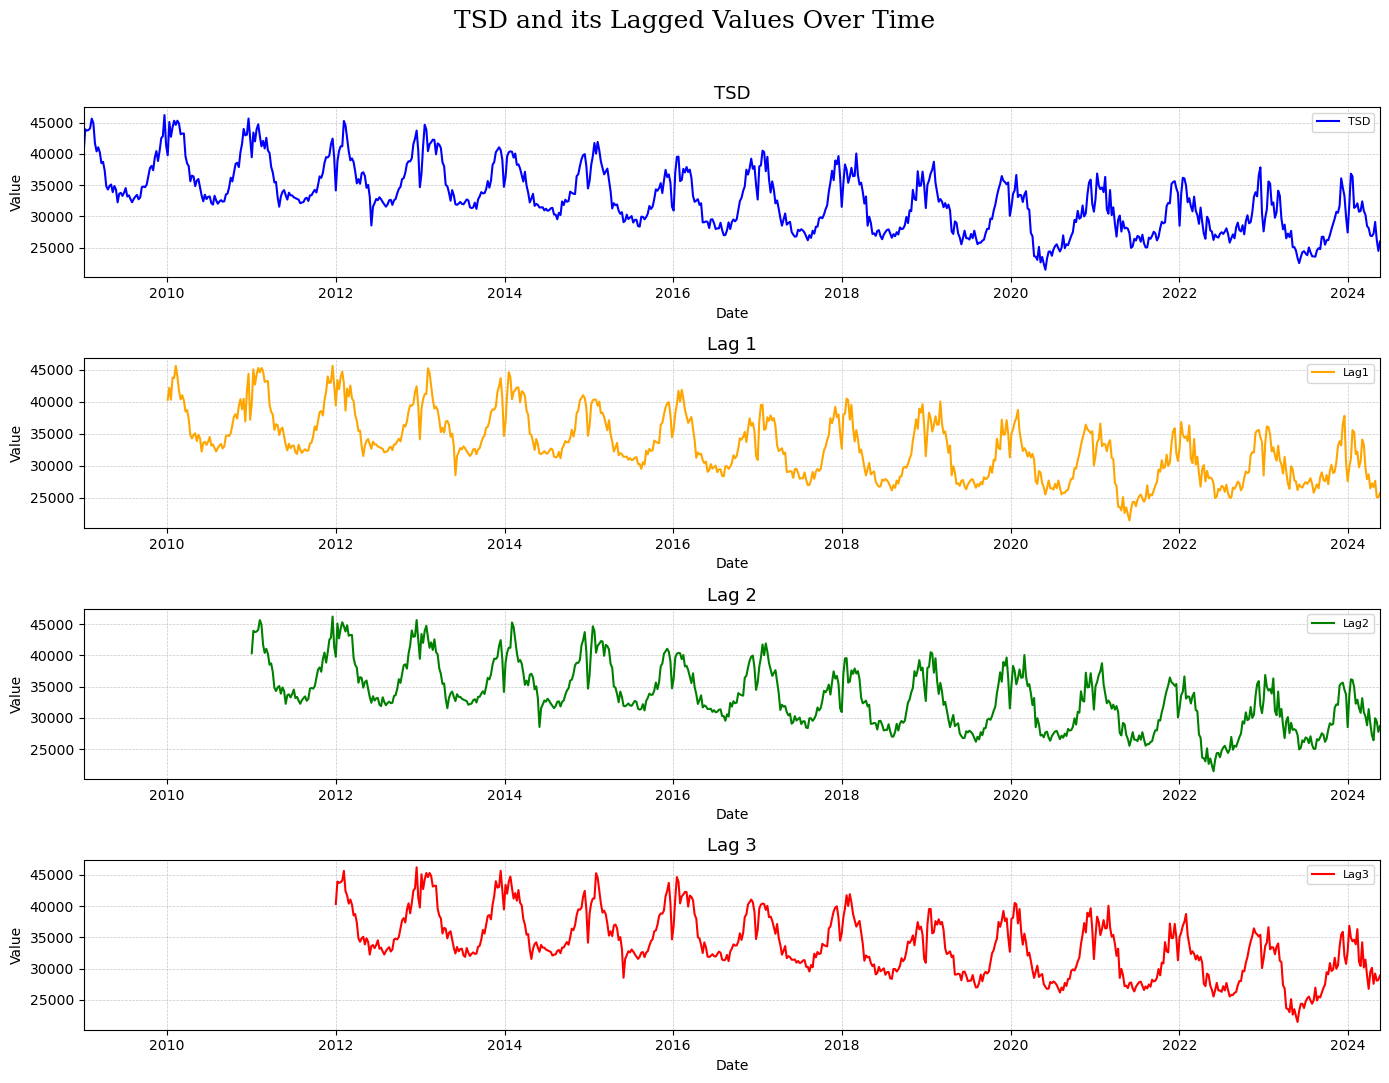

In [83]:
import matplotlib.pyplot as plt

# Get the earliest date in the dataset
start_date = weekly_data.index.min()
# Plot original values for target and lagged values
plt.figure(figsize=(14, 11))

plt.suptitle('TSD and its Lagged Values Over Time', fontsize=18, y=0.98,fontfamily='serif')
# Plot original TSD
plt.subplot(4, 1, 1)
plt.plot(weekly_data.index, weekly_data['tsd'], label='TSD', color='blue')
plt.title('TSD', fontsize=13)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(start_date, weekly_data.index[-1])  # Set x-axis limit

# Plot original Lag1
plt.subplot(4, 1, 2)
plt.plot(weekly_data.index, weekly_data['lag1'], label='Lag1', color='orange')
plt.title('Lag 1', fontsize=13)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(start_date, weekly_data.index[-1])  # Set x-axis limit

# Plot original Lag2
plt.subplot(4, 1, 3)
plt.plot(weekly_data.index, weekly_data['lag2'], label='Lag2', color='green')
plt.title('Lag 2', fontsize=13)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(start_date, weekly_data.index[-1])  # Set x-axis limit

# Plot original Lag3
plt.subplot(4, 1, 4)
plt.plot(weekly_data.index, weekly_data['lag3'], label='Lag3', color='red')
plt.title('Lag 3', fontsize=13)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(start_date, weekly_data.index[-1])  # Set x-axis limit
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Adjust layout and save the figure
# plt.tight_layout()
plt.savefig('original_and_lagged_values.png', dpi=300)
plt.show()


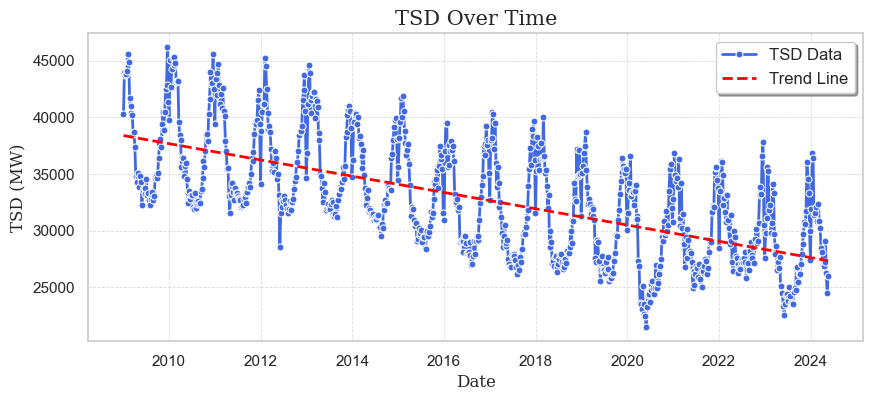

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))

# Plot the TSD data using seaborn lineplot with a different color and marker
sns.lineplot(x=weekly_data.index, y=weekly_data["tsd"], 
             color="royalblue", label="TSD Data", ax=ax, 
             linewidth=2, marker="o", markersize=5)

# Adding a trend line
x = np.arange(len(weekly_data.index))  # Create a numeric index for the x-axis
y = weekly_data["tsd"]

# Fit a linear regression line to the data
coefficients = np.polyfit(x, y, 1)
trend_line = np.polyval(coefficients, x)

# Plot the trend line on the same axis with a dashed line style
ax.plot(weekly_data.index, trend_line, color="red", linestyle="--", linewidth=2, label="Trend Line")

# Customize the plot with title and labels, using serif font
ax.set_title("TSD Over Time", fontsize=15, fontfamily='serif')
ax.set_xlabel("Date", fontsize=12, fontfamily='serif')
ax.set_ylabel("TSD (MW)", fontsize=12, fontfamily='serif')

# Customize the grid style
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

# Save the figure
fig.savefig("over_time.png", format='png', dpi=300)

# Add legend with enhanced styling
ax.legend(fontsize=12, loc="best", frameon=True, shadow=True)

# Display the plot
plt.show()


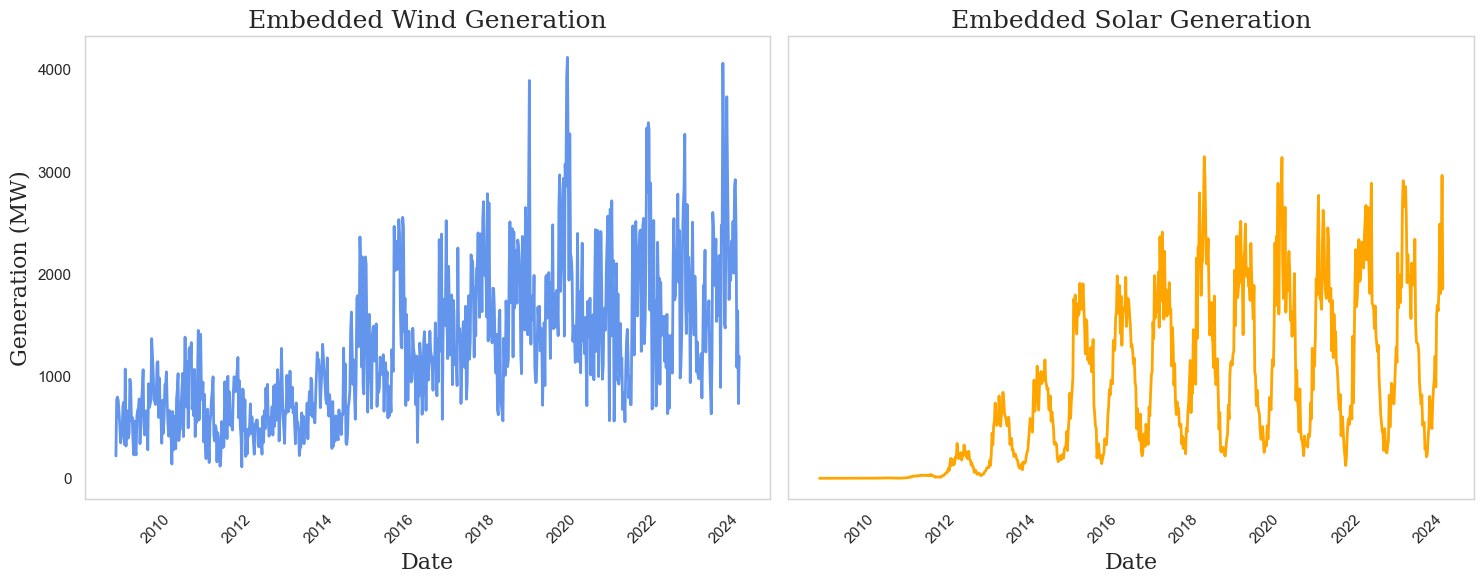

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot embedded wind generation
sns.lineplot(x=weekly_data.index, y=weekly_data['embedded_wind_generation'], 
             color="cornflowerblue", ax=ax1, linewidth=2)
ax1.set_title("Embedded Wind Generation", fontsize=18, fontfamily='serif')
ax1.set_xlabel("Date", fontsize=16, fontfamily='serif')
ax1.set_ylabel("Generation (MW)", fontsize=16, fontfamily='serif')
ax1.tick_params(axis='x', rotation=45)

# Add a light border (spines) for ax1
for spine in ax1.spines.values():
    spine.set_edgecolor('lightgray')  # Light color for the border
    spine.set_linewidth(1)  # Uniform thin border

# Remove grid lines for ax1
ax1.grid(False)

# Plot embedded solar generation
sns.lineplot(x=weekly_data.index, y=weekly_data['embedded_solar_generation'], 
             color="orange", ax=ax2, linewidth=2)
ax2.set_title("Embedded Solar Generation", fontsize=18, fontfamily='serif')
ax2.set_xlabel("Date", fontsize=16, fontfamily='serif')
ax2.set_ylabel("Generation (MW)", fontsize=16, fontfamily='serif')
ax2.tick_params(axis='x', rotation=45)

# Add a light border (spines) for ax2
for spine in ax2.spines.values():
    spine.set_edgecolor('lightgray')  # Light color for the border
    spine.set_linewidth(1)  # Uniform thin border

# Remove grid lines for ax2
ax2.grid(False)

# Adjust layout
plt.tight_layout()

# Save the figure
fig.savefig('embedded_generation_comparison.png', format='png', dpi=300)

# Show the plots
plt.show()


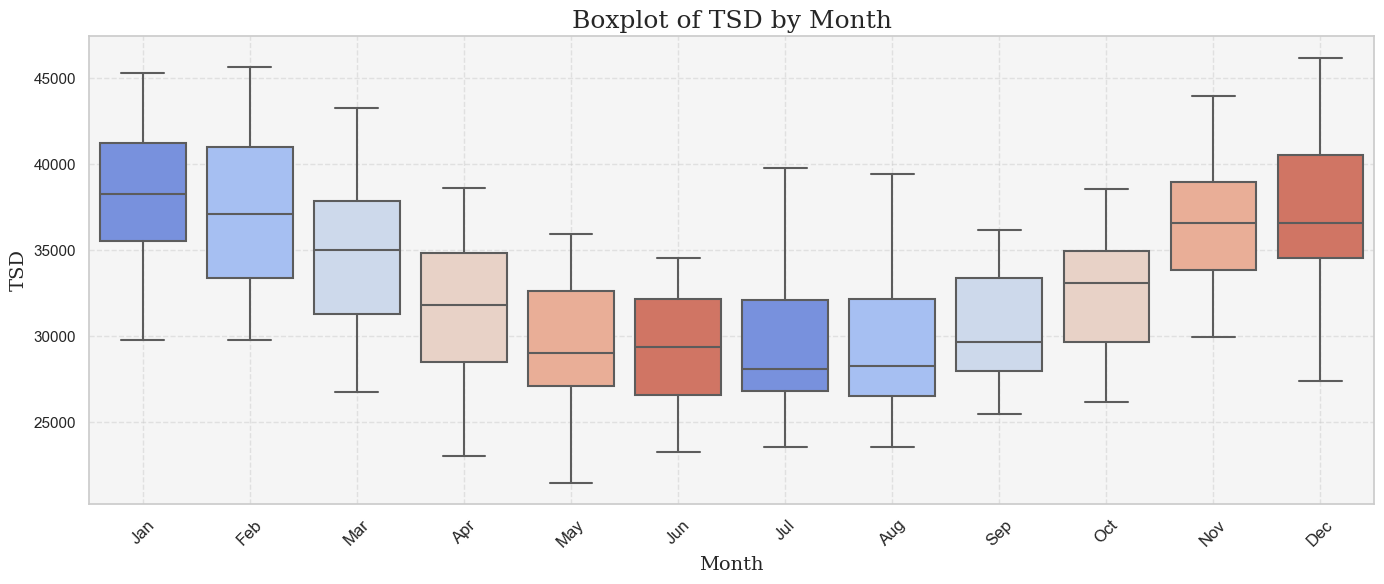

In [39]:
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm")  # Vibrant color palette

# Create the boxplot using seaborn with enhanced aesthetics
plt.figure(figsize=(14, 6))
boxplot = sns.boxplot(x='month', y='tsd', data=weekly_data, palette=palette, linewidth=1.5)

# Enhance the border of each boxplot
for artist in boxplot.artists:
    artist.set_edgecolor('black')  # Set border color
    artist.set_linewidth(2.5)      # Set border width

# Customize the appearance of outliers
for i, line in enumerate(boxplot.lines):
    if i % 6 == 5:  # Outliers are every 6th line in the `boxplot.lines`
        line.set_markerfacecolor('red')
        line.set_markeredgecolor('black')
        line.set_marker('o')
        line.set_markeredgewidth(1.5)

# Add titles and labels with improved styling
plt.title('Boxplot of TSD by Month', fontsize=18, family='serif')
plt.xlabel('Month', fontsize=14, family='serif')
plt.ylabel('TSD', fontsize=14, family='serif')

# Customize x-ticks for better readability
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, fontsize=12)

# Add subtle grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add a lighter grey background to the plot area
plt.gca().patch.set_facecolor('whitesmoke')  # Lighter shade of grey

# Save the figure
plt.savefig('boxplot_tsd_by_month.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


In [40]:
# Resampling the data for 2023 and 2010
data_2023 = weekly_data.loc['2023-01-01':'2023-12-31']['tsd'].resample('M').mean()
data_2010 = weekly_data.loc['2010-01-01':'2010-12-31']['tsd'].resample('M').mean()

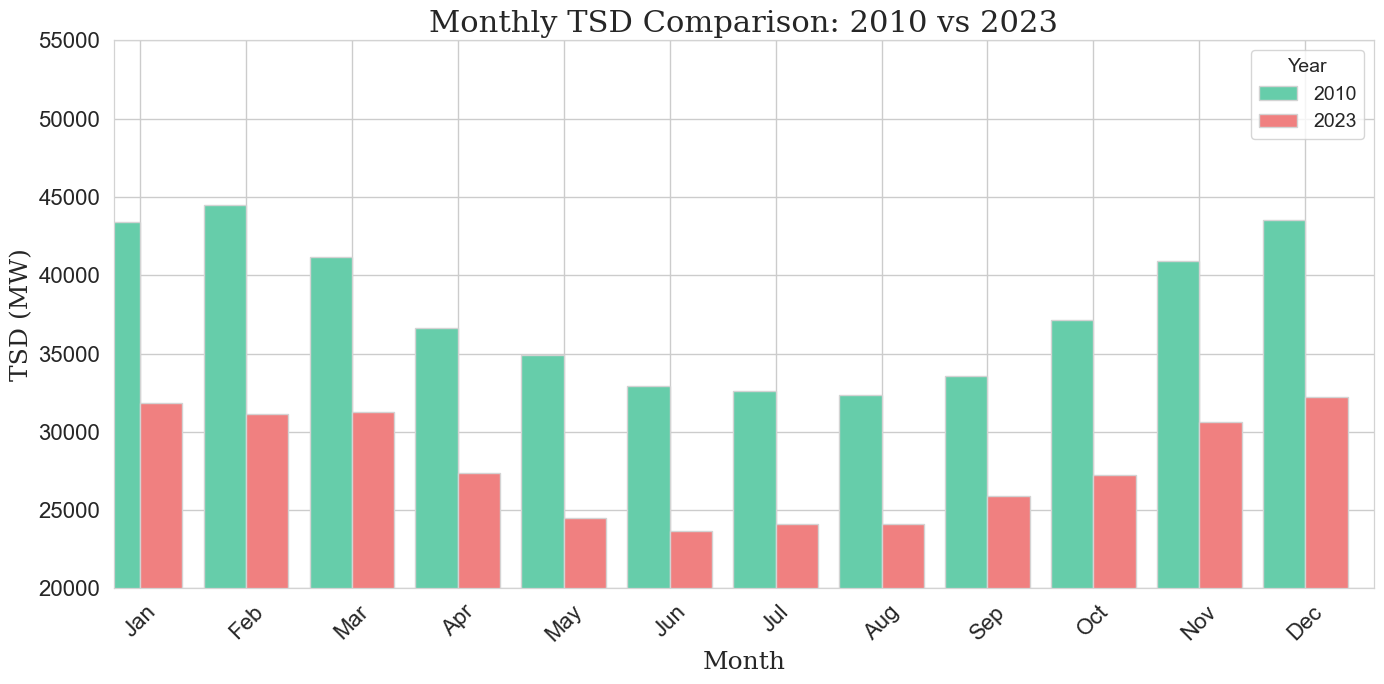

In [41]:
sns.set_theme(style="whitegrid")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot data for 2010
bars_2010 = data_2010.plot(kind='bar', color='mediumaquamarine', ax=ax, edgecolor='lightgray', width=0.4, position=1, label='2010', align='center')

# Plot data for 2023
bars_2023 = data_2023.plot(kind='bar', color='lightcoral', ax=ax, edgecolor='lightgray', width=0.4, position=0, label='2023', align='center')

# Set y-axis limit to be consistent
ax.set_ylim([20000, 55000])

# Set titles and labels
ax.set_title('Monthly TSD Comparison: 2010 vs 2023', fontsize=22, fontfamily='serif')
ax.set_xlabel('Month', fontsize=18, fontfamily='serif')
ax.set_ylabel('TSD (MW)', fontsize=18, fontfamily='serif')
ax.set_xticks(range(len(data_2010.index)))
ax.set_xticklabels(data_2010.index.strftime('%b'), rotation=45, fontsize=16)
ax.tick_params(axis='y', labelsize=16)

# Add a legend
ax.legend(title='Year', title_fontsize='14', fontsize='14')



# Add a light border (spines)
for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
    spine.set_linewidth(0.9)

# Adjust layout
plt.tight_layout()

# Save the figure with high resolution
fig.savefig('monthly_tsd_comparison.png', format='png', dpi=300)

# Show the plot
plt.show()

C:\Users\SHREY\AppData\Local\Temp\ipykernel_14560\677411104.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


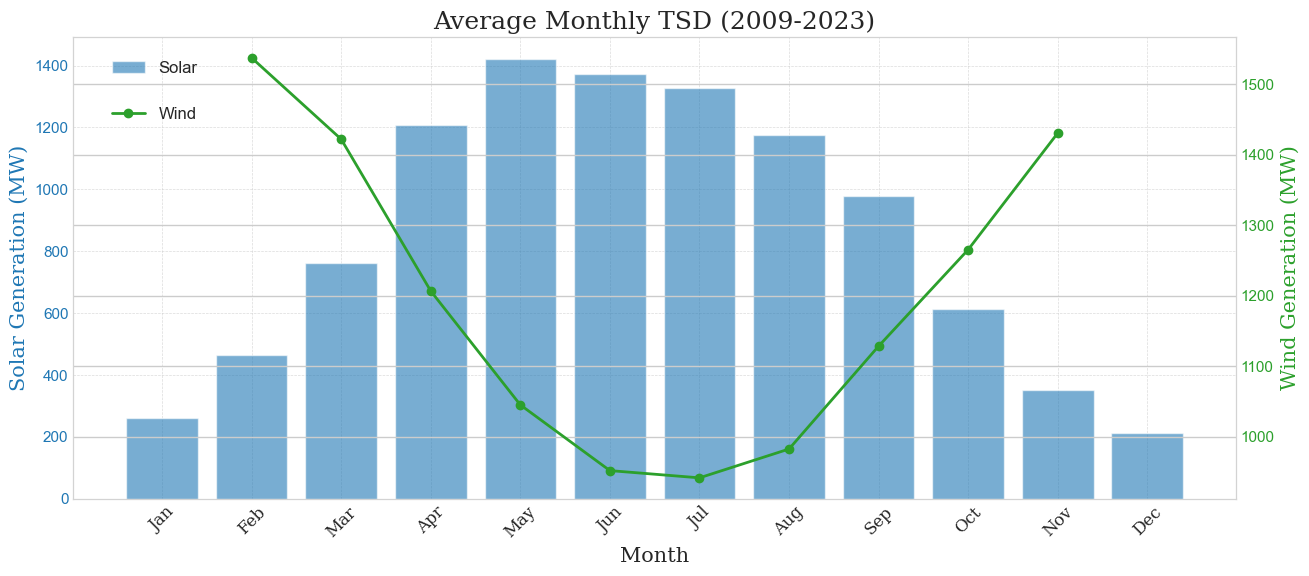

In [42]:
monthly_solar = weekly_data['embedded_solar_generation'].resample('M').mean()
monthly_wind = weekly_data['embedded_wind_generation'].resample('M').mean()

# Group by month to get average for each month
monthly_avg_solar = monthly_solar.groupby(monthly_solar.index.month).mean()
monthly_avg_wind = monthly_wind.groupby(monthly_wind.index.month).mean()

# Map the month numbers to month names
monthly_avg_solar.index = pd.date_range(start='2009-01-01', periods=12, freq='M').strftime('%b')
monthly_avg_wind.index = pd.date_range(start='2009-01-01', periods=12, freq='M').strftime('%b')

# Apply moving average smoothing to the wind generation data
window_size = 3  # Size of the moving window
smoothed_wind = monthly_avg_wind.rolling(window=window_size, center=True).mean()

# Set plot style
plt.style.use('seaborn-whitegrid')
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot the monthly average data for solar on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=15, family='serif')
ax1.set_ylabel('Solar Generation (MW)', fontsize=15, family='serif', color=color)
ax1.bar(monthly_avg_solar.index, monthly_avg_solar.values, color=color, alpha=0.6, label='Solar')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for wind generation
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Wind Generation (MW)', fontsize=15, family='serif', color=color)
ax2.plot(monthly_avg_wind.index, smoothed_wind, marker='o', color=color, linewidth=2, label='Wind')
ax2.tick_params(axis='y', labelcolor=color)

# Customize plot appearance
ax1.set_title('Average Monthly TSD (2009-2023)', fontsize=18, family='serif')
ax1.set_xticks(monthly_avg_solar.index)
ax1.set_xticklabels(monthly_avg_solar.index, fontsize=12, family='serif', rotation=45)

# Show grid lines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize border (spines) of the plot
for spine in ax1.spines.values():
    spine.set_edgecolor('lightgray')
    spine.set_linewidth(0.8)
for spine in ax2.spines.values():
    spine.set_edgecolor('lightgray')
    spine.set_linewidth(0.8)

# Add legends with adjusted positions
ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize='12')
ax2.legend(loc='upper left', bbox_to_anchor=(0.02, 0.88), fontsize='12')

# Save the figure with high resolution
# fig.savefig('average_monthly_tsd_dual_axis_smoothed.png', format='png', dpi=300)

# Show the plot
plt.show()

### seasonal analysis

In [43]:
# Function to assign seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# Add a 'season' column to the DataFrame
weekly_data['season'] = weekly_data.index.month.map(get_season)

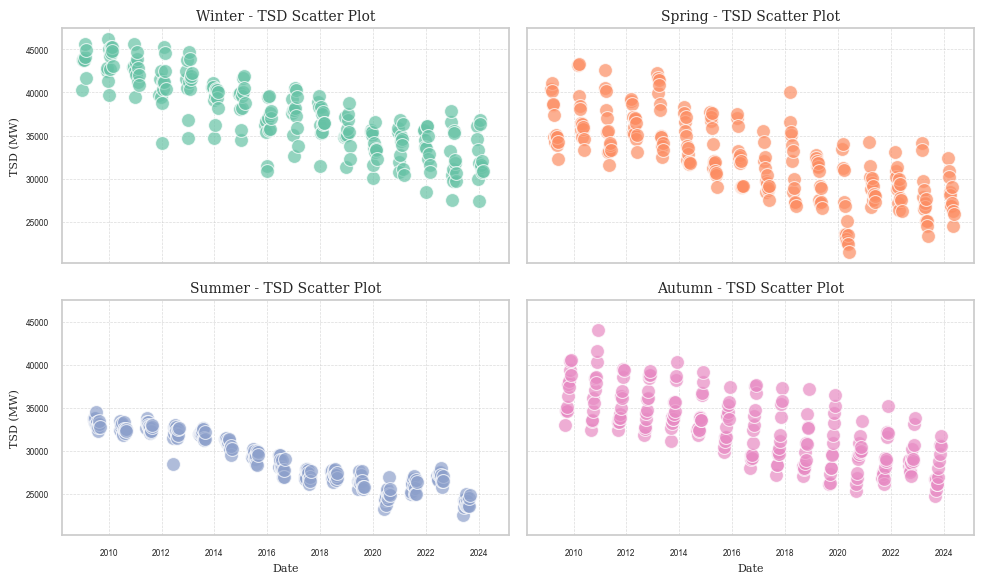

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Create subplots for each season
seasons = weekly_data['season'].unique()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)
axes = axes.flatten()

# Plot scatter plots for each season
for i, season in enumerate(seasons):
    season_data = weekly_data[weekly_data['season'] == season]
    sns.scatterplot(x=season_data.index, y='tsd', data=season_data, ax=axes[i], color=sns.color_palette('Set2')[i], s=100, alpha=0.7)
    axes[i].set_title(f'{season} - TSD Scatter Plot', fontsize=10, family='serif')
    axes[i].set_xlabel('Date', fontsize=8, family='serif')
    axes[i].set_ylabel('TSD (MW)', fontsize=8, family='serif')
    axes[i].tick_params(axis='both', which='major', labelsize=6)  # Decrease tick label size
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the figure with high resolution
fig.savefig('seasonal_tsds_scatter_subplots.png', format='png', dpi=300)

# Show the plot
plt.show()


### Seasonality Analysis

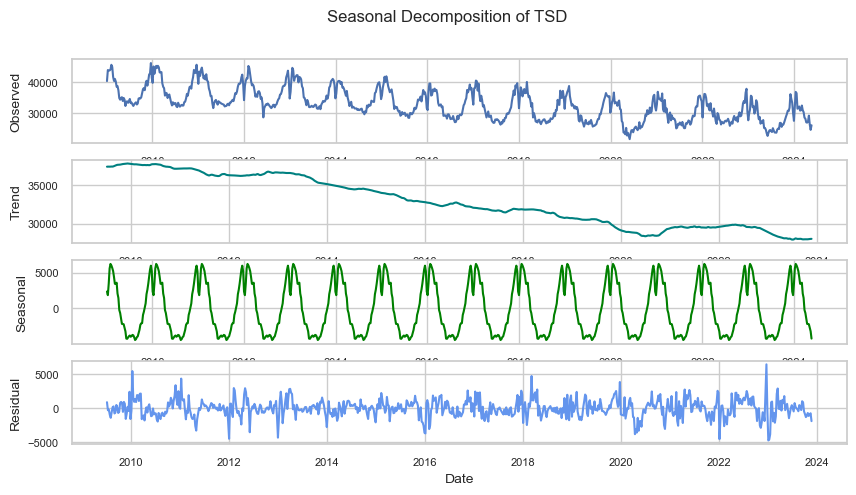

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_data = weekly_data.sort_index()

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_data['tsd'], model='additive', period=52)  # since weekly data with a yearly period of 52 weeks

# Create a large figure to manually plot each component
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 5))

# Plot each component
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed', fontsize=10)
ax1.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick size

ax2.plot(decomposition.trend, color='teal')
ax2.set_ylabel('Trend', fontsize=10)
ax2.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick size

ax3.plot(decomposition.seasonal, color='green')
ax3.set_ylabel('Seasonal', fontsize=10)
ax3.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick size

ax4.plot(decomposition.resid, color='cornflowerblue')
ax4.set_ylabel('Residual', fontsize=10)
ax4.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick size

# Set a common x-axis label
fig.suptitle('Seasonal Decomposition of TSD', fontsize=12)
plt.xlabel('Date', fontsize=10)

# Save the plot with high resolution
plt.savefig('seasonal_decomposition.png', format='png', dpi=300)

# Show the plot
plt.show()


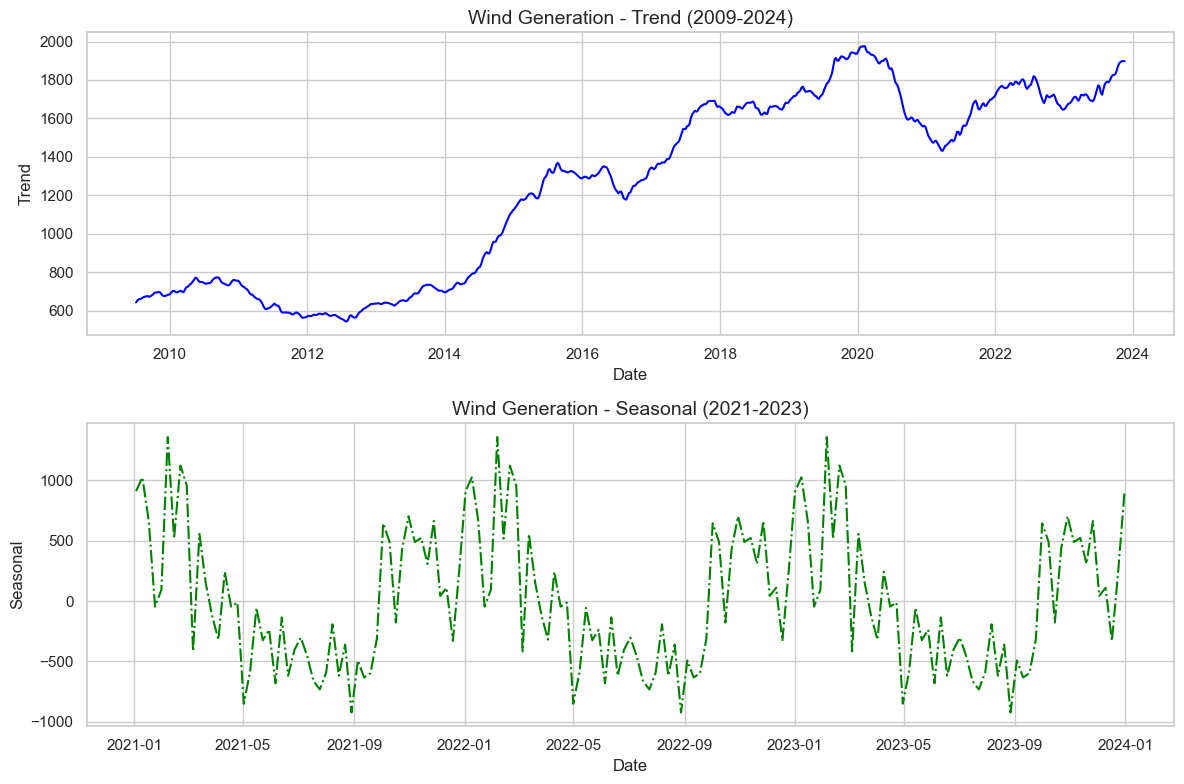

In [46]:
# Define years to analyze
years_to_analyze = [2021, 2022, 2023]

# Filter data for the specified years
data_years = weekly_data[weekly_data.index.year.isin(years_to_analyze)]

# Perform seasonal decomposition for wind and solar generation
decomposition_wind = seasonal_decompose(data_years['embedded_wind_generation'], model='additive', period=52)
decomposition_solar = seasonal_decompose(data_years['embedded_solar_generation'], model='additive', period=52)
whole_wind_decompos=seasonal_decompose(weekly_data['embedded_wind_generation'], model='additive', period=52)
whole_solar_decompos=seasonal_decompose(weekly_data['embedded_solar_generation'], model='additive', period=52)
# Plot decomposition for Wind Generation (Trend and Seasonal only)
plt.figure(figsize=(12, 8))

# Trend Plot for Wind Generation
plt.subplot(2, 1, 1)
plt.plot(whole_wind_decompos.trend, label='Trend', color='blue', linestyle='-')
plt.title('Wind Generation - Trend (2009-2024)',fontsize='14')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.grid(True)

# Seasonal Plot for Wind Generation
plt.subplot(2, 1, 2)
plt.plot(decomposition_wind.seasonal, label='Seasonal', color='green', linestyle='-.')
plt.title('Wind Generation - Seasonal (2021-2023)',fontsize='14')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.grid(True)

plt.tight_layout()
plt.savefig('wind_generation_decomposition_2021_2023.png')
plt.show()



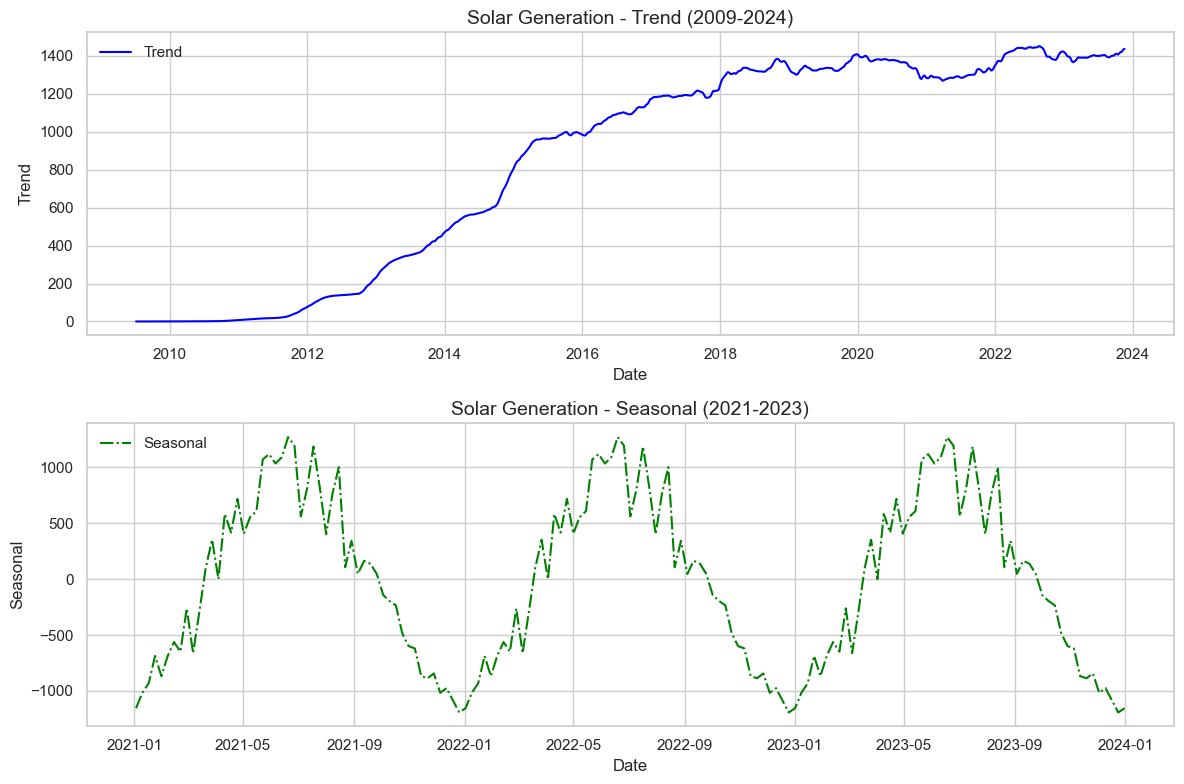

In [47]:
# Plot decomposition for Solar Generation (Trend and Seasonal only)
plt.figure(figsize=(12, 8))

# Trend Plot for Solar Generation
plt.subplot(2, 1, 1)
plt.plot(whole_solar_decompos.trend, label='Trend', color='blue', linestyle='-')
plt.title('Solar Generation - Trend (2009-2024)',fontsize='14')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend(loc='upper left')
plt.grid(True)

# Seasonal Plot for Solar Generation
plt.subplot(2, 1, 2)
plt.plot(decomposition_solar.seasonal, label='Seasonal', color='green', linestyle='-.')
plt.title('Solar Generation - Seasonal (2021-2023)',fontsize='14')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.savefig('solar_generation_decomposition_2021_2023.png')
plt.show()

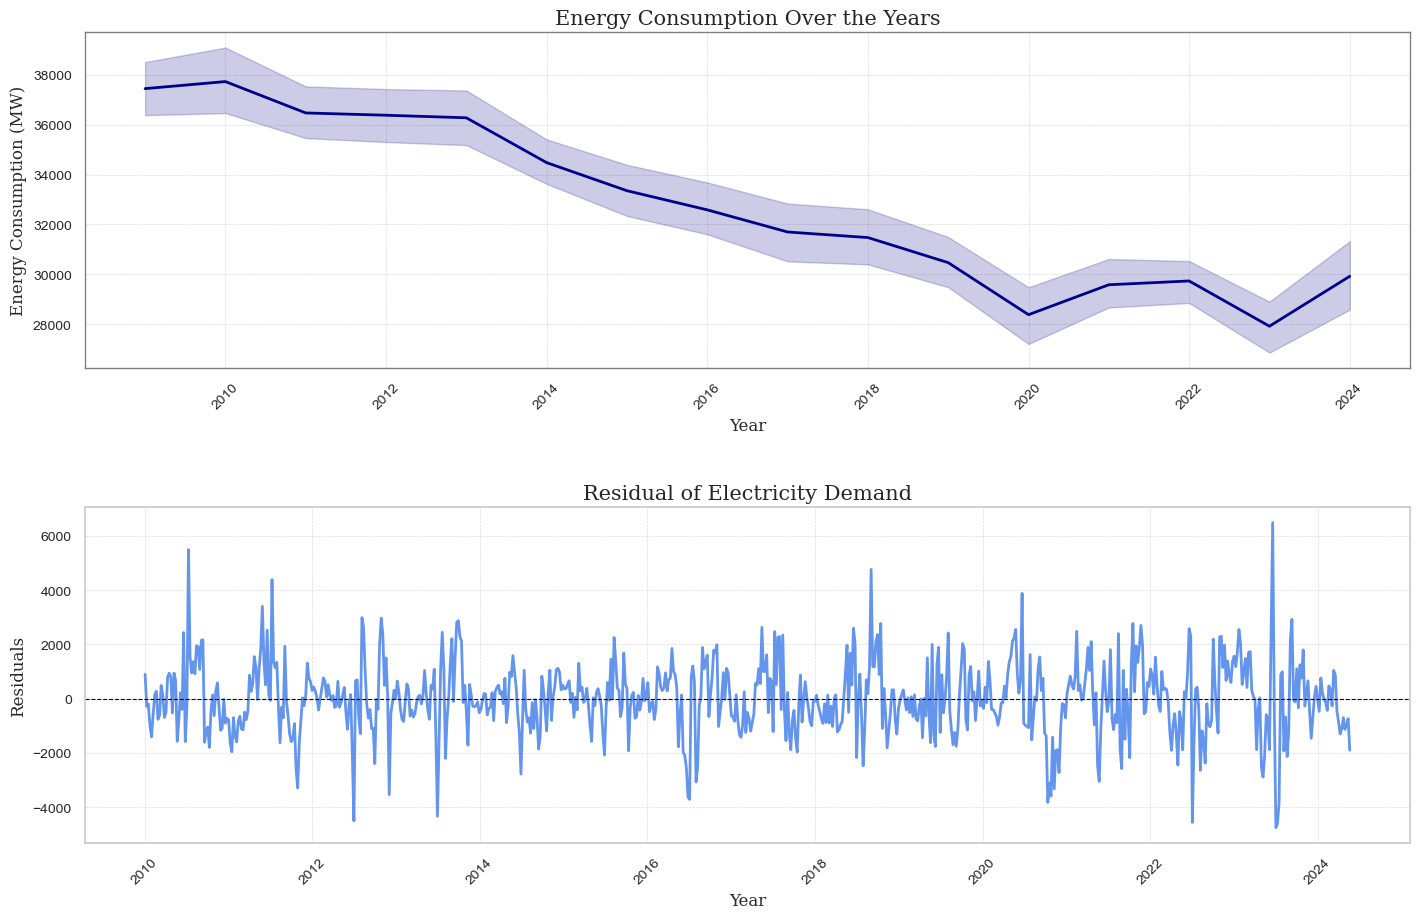

In [48]:
# Set the plot style
# style.use('ggplot')
sns.set_theme(style="whitegrid")

# Ensure that 'year' is present in 'weekly_data' and 'tsd' is present in both DataFrames
weekly_data = weekly_data.sort_index()  # Ensure data is sorted by index for proper decomposition

# Perform seasonal decomposition on weekly_data
decomposition_result = seasonal_decompose(weekly_data['tsd'], model='additive', period=52)  # Assuming weekly data with yearly seasonality
residual = decomposition_result.resid.dropna()  # Drop NA values resulting from the decomposition

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=False)

ax1 = axes[0]
sns.lineplot(x=weekly_data["year"], y=weekly_data["tsd"], data=weekly_data, color='darkblue', linewidth=2, ax=ax1)

# Enhance title and labels for Plot 1
ax1.set_title("Energy Consumption Over the Years", fontsize=15, family='serif')
ax1.set_xlabel('Year', fontsize=12, family='serif')
ax1.set_ylabel('Energy Consumption (MW)', fontsize=12, family='serif')

# Customize the x-tick labels (rotate for readability)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

# Customize grid and background for Plot 1
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_facecolor('white')

# Customize the spines for Plot 1
for spine in ax1.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

# Second subplot: Residual component of electricity demand over time
aligned_index = weekly_data.index[-len(residual):]  # Align index with residual length
sns.lineplot(
    ax=axes[1],
    x=aligned_index,
    y=residual,
    color='cornflowerblue',
    linewidth=2
)

axes[1].set_title("Residual of Electricity Demand", fontsize=15, family='serif')
axes[1].set_xlabel('Year', fontsize=12, family='serif')
axes[1].set_ylabel('Residuals', fontsize=12, family='serif')
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
axes[1].set_facecolor('white')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Adjust layout and save the plot
plt.tight_layout(pad=3.0)
plt.savefig('combined_energy_plots.png', dpi=300, bbox_inches='tight')
plt.show()


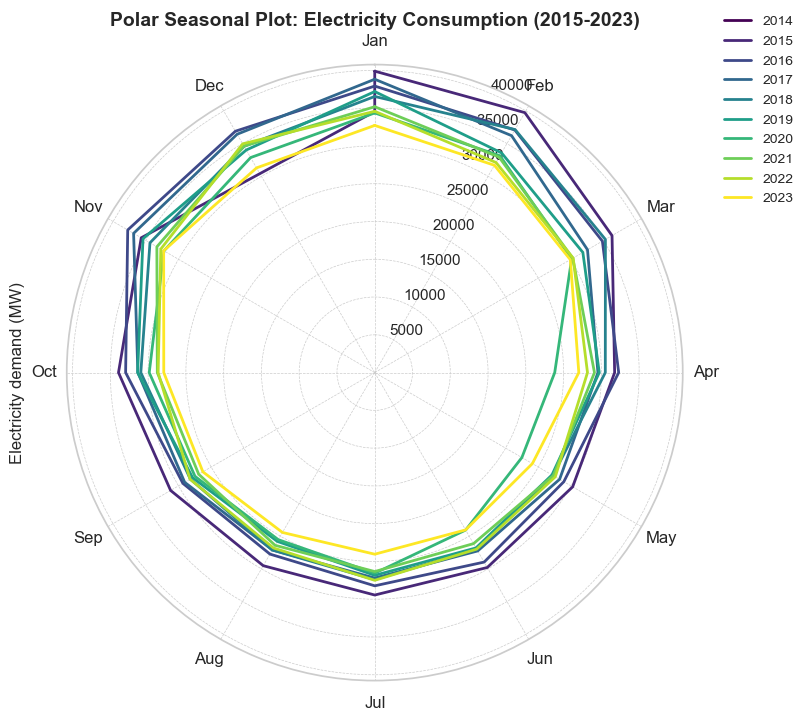

In [49]:
# Filter data to ensure it doesn't go beyond the actual range (2015 to 2023)
weekly_data_filtered = weekly_data[(weekly_data.index.year >= 2015) & (weekly_data.index.year <= 2023)]

# Group by month and year to get the mean tsd
monthly_data = weekly_data_filtered.groupby(['year', 'month'])['tsd'].mean().reset_index()

# Create the polar plot
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# Convert month numbers to radians (12 months -> 2*pi radians)
monthly_data['radians'] = 2 * np.pi * (monthly_data['month'] - 1) / 12

# Plot each year separately, ensuring continuity between December and January
years = monthly_data['year'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))  # Use a colormap for colors
for year, color in zip(years, colors):
    yearly_data = monthly_data[monthly_data['year'] == year]
    yearly_data = pd.concat([yearly_data, yearly_data.iloc[[0]]])
    yearly_data.loc[len(yearly_data)-1, 'radians'] = 2 * np.pi  # Wrap-around to ensure continuity
    ax.plot(yearly_data['radians'], yearly_data['tsd'], label=year, color=color, linewidth=2)

# Customize the plot
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12, rotation=45)

plt.title('Polar Seasonal Plot: Electricity Consumption (2015-2023)', fontsize=14, fontweight='bold')
ax.set_ylabel('Electricity demand (MW)', labelpad=30, fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.5)

fig.patch.set_facecolor('white')  # White figure background

plt.show()

# SARIMA

### Stationarity test

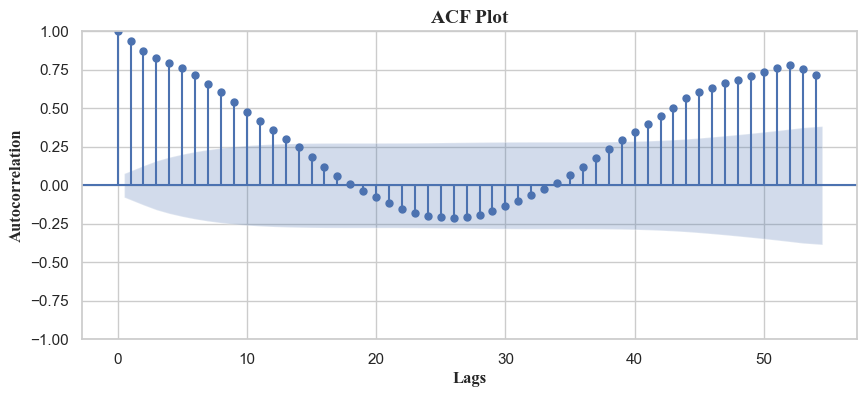

In [50]:
from statsmodels.graphics.tsaplots import plot_acf

# Drop NaNs
weekly_data.dropna(inplace=True)

# Create the plot with a larger figure size
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust figure size for desired aspect ratio

# Plot the ACF with more lags (e.g., 104 lags for two years of weekly data)
plot_acf(weekly_data['tsd'], lags=54, ax=ax)

# Customize the plot with bold titles and labels, and set font style
font_style = {'fontname': 'Times New Roman', 'fontsize': 14, 'fontweight': 'bold'}
ax.set_title('ACF Plot', **font_style)

font_style = {'fontname': 'Times New Roman', 'fontsize': 12, 'fontweight': 'bold'}
ax.set_xlabel('Lags', **font_style)
ax.set_ylabel('Autocorrelation', **font_style)

# Save the figure in high resolution
plt.savefig('acf_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG
# plt.savefig('acf_plot_high_res.pdf', dpi=300, bbox_inches='tight')  # Save as PDF

# Show the plot
plt.show()


In [290]:
weekly_data=pd.read_csv('weekly_data_og.csv')

In [291]:
weekly_data.shape

(803, 14)

In [292]:
# Apply log transformation to the 'tsd' column in 'weekly_data'
weekly_data['log_tsd'] = np.log(weekly_data['tsd'])

In [52]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss

def perform_kpss_test(time_series):
    """
    Conducts the KPSS test for stationarity on a given time series.
    
    Parameters:
    time_series (pd.Series): The time series data to test.
    
    Returns:
    dict: A dictionary containing the KPSS statistic, p-value, and critical values.
    """
    # Conduct the KPSS test
    result = kpss(time_series.dropna(), nlags='auto')
    
    # Extract results
    kpss_statistic = result[0]
    p_value = result[1]
    critical_values = result[3]
    
    # Print results
    print('KPSS Statistic:', kpss_statistic)
    print('p-value:', p_value)
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    
    # Return results in a dictionary
    return {
        'KPSS Statistic': kpss_statistic,
        'p-value': p_value,
        'Critical Values': critical_values
    }
results = perform_kpss_test(weekly_data['log_tsd'])


KPSS Statistic: 1.730389746094028
p-value: 0.01
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


C:\Users\SHREY\AppData\Local\Temp\ipykernel_14560\2862081505.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(time_series.dropna(), nlags='auto')


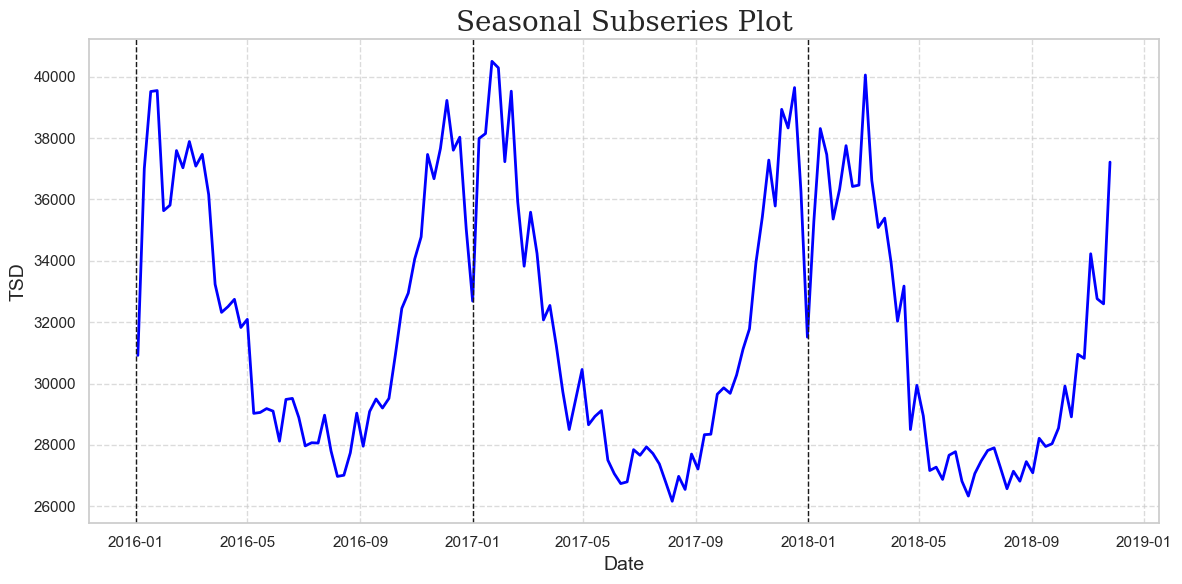

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the start and end date for filtering
start_date = '2016-01-01'
end_date = '2018-12-01'
filtered_data = weekly_data[start_date:end_date]

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['tsd'], label='TSD', color='blue', linewidth=2)

# Enhance plot with titles, labels, and grid
plt.title('Seasonal Subseries Plot', fontsize=20,fontfamily='serif')
plt.xlabel('Date', fontsize=14)
plt.ylabel('TSD', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Add vertical lines for each year
years = pd.date_range(start=start_date, end=end_date, freq='YS')
for year in years:
    plt.axvline(x=year, color='k', linestyle='--', linewidth=1)

# Save the figure
plt.tight_layout()
plt.savefig('seasonal_subseries_plot.png', dpi=300)

# Show the plot
plt.show()


In [293]:

# Calculate seasonal difference (lag 52 for weekly data)
weekly_data['seasonal_diff'] = weekly_data['log_tsd'].diff(52)

# Calculate first difference
weekly_data['first_diff'] = weekly_data['seasonal_diff'].diff()
# Drop rows with any NaN values from the DataFrame
sarima_data = weekly_data


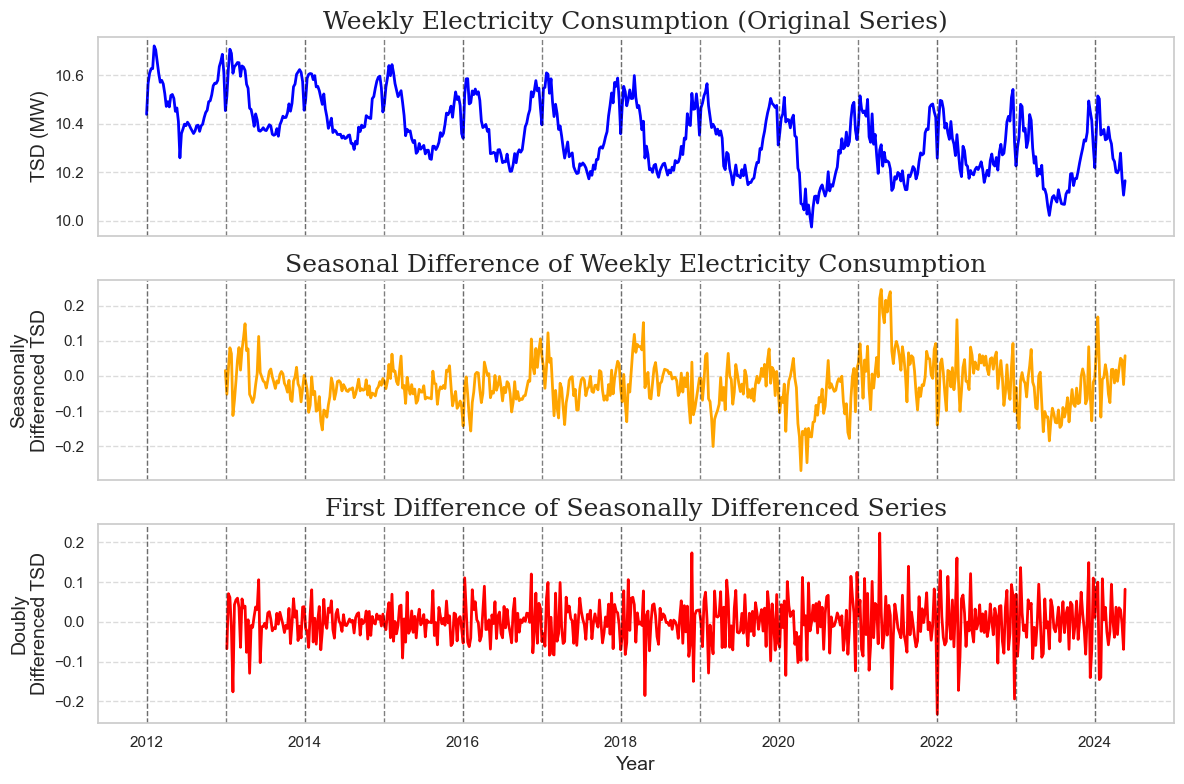

In [55]:


# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Original tsd
axs[0].plot(weekly_data.index, weekly_data['log_tsd'], color='blue', linewidth=2)
axs[0].set_ylabel('TSD (MW)', fontsize=14)
axs[0].set_title('Weekly Electricity Consumption (Original Series)', fontsize=18,fontfamily='serif')
axs[0].grid(True, linestyle='--', alpha=0.7)

# Seasonal difference of tsd (lag 52)
axs[1].plot(weekly_data.index, weekly_data['seasonal_diff'], color='orange', linewidth=2)
axs[1].set_ylabel('Seasonally\nDifferenced TSD', fontsize=14)
axs[1].set_title('Seasonal Difference of Weekly Electricity Consumption', fontsize=18,fontfamily='serif')
axs[1].grid(True, linestyle='--', alpha=0.7)

# First difference of seasonal_diff
axs[2].plot(weekly_data.index, weekly_data['first_diff'], color='red', linewidth=2)
axs[2].set_ylabel('Doubly\nDifferenced TSD', fontsize=14)
axs[2].set_title('First Difference of Seasonally Differenced Series', fontsize=18,fontfamily='serif')
axs[2].grid(True, linestyle='--', alpha=0.7)

# Common X label
plt.xlabel('Year', fontsize=14)

# Adjust layout, add some spacing between plots, and show plot
plt.tight_layout()

# Add vertical lines for year markers
years = pd.date_range(start=weekly_data.index.min(), end=weekly_data.index.max(), freq='YS')
for ax in axs:
    for year in years:
        ax.axvline(x=year, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.savefig('differenced_data.png', dpi=300)

# Show the plot
plt.show()


In [56]:

# Conduct the KPSS test
results2 = perform_kpss_test(weekly_data['first_diff'])


KPSS Statistic: 0.17751910884066632
p-value: 0.1
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


C:\Users\SHREY\AppData\Local\Temp\ipykernel_14560\2862081505.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(time_series.dropna(), nlags='auto')


### Identification of model parameters

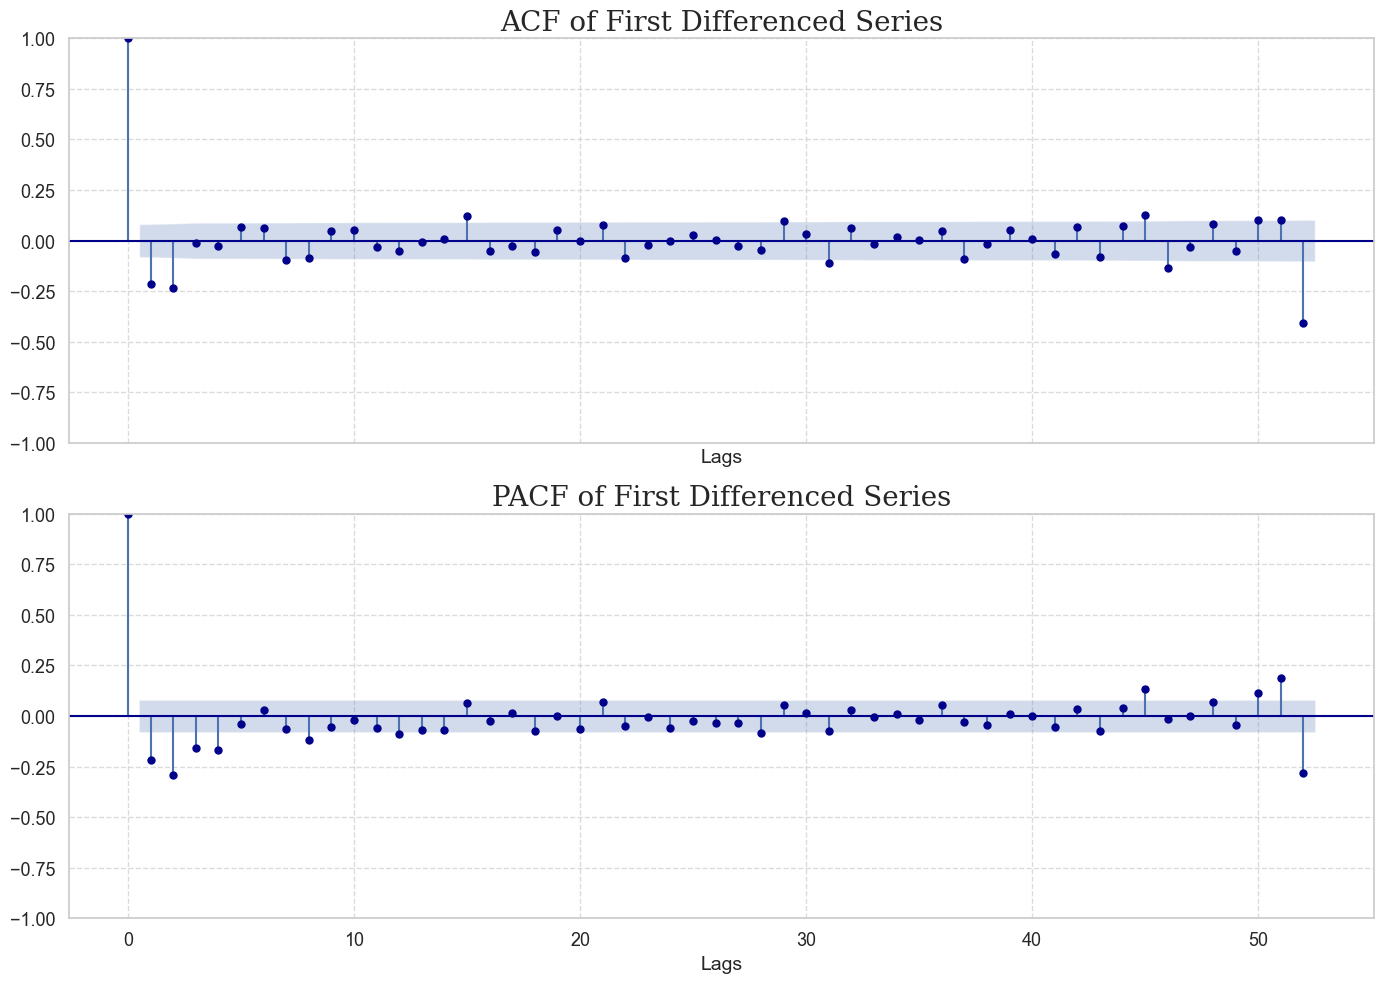

In [57]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Drop NaNs
weekly_data.dropna(inplace=True)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot ACF
plot_acf(weekly_data['first_diff'], lags=52, ax=axs[0], color='darkblue')
axs[0].set_title('ACF of First Differenced Series', fontsize=20,fontfamily='serif')
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot PACF
plot_pacf(weekly_data['first_diff'], lags=52, ax=axs[1],color='darkblue')
axs[1].set_title('PACF of First Differenced Series', fontsize=20,fontfamily='serif')
axs[1].grid(True, linestyle='--', alpha=0.7)

# Set common labels
for ax in axs:
    ax.set_xlabel('Lags', fontsize=14)
    ax.tick_params(axis='x',labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

# Adjust layout
plt.tight_layout()
plt.savefig('acf_pacf.png', dpi=300)
# Show the plot
plt.show()


In [296]:
# Split data into train and test sets
train_size = int(len(sarima_data) * 0.7)  # 70% for training
train_data, test_data = sarima_data.iloc[:train_size]['log_tsd'], sarima_data.iloc[train_size:]['log_tsd']

In [301]:
# sarima_data.set_index('datetime', inplace=True)
# output = pd.DataFrame({
#     'tsd': sarima_data.iloc[train_size:]['tsd'],  # Getting actual 'tsd' from the original dataset (not log)
# }, index=sarima_data.iloc[train_size:].index)

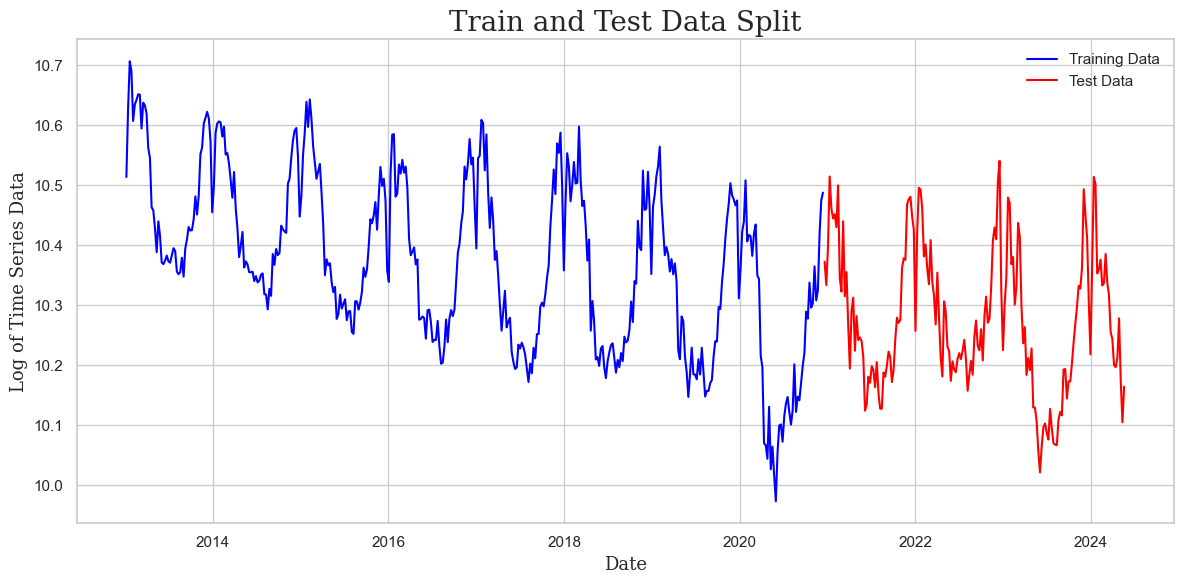

In [59]:


# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(train_data.index, train_data, label='Training Data', color='blue')

# Plot the test data
plt.plot(test_data.index, test_data, label='Test Data', color='red')

# Add labels and title
plt.xlabel('Date',fontsize=13,fontfamily='serif')
plt.ylabel('Log of Time Series Data',fontsize=13,fontfamily='serif')
plt.title('Train and Test Data Split',fontsize=20,fontfamily='serif')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('train_test_split.png')  # Save the plot as an image file
plt.show()


In [17]:
# Performance metrics

from tensorflow.keras import backend as K
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
#     mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true)) 
    return mape

In [47]:
import statsmodels.api as sm

# Define the SARIMA orders to compare
orders = [(1, 1, 0), (1, 1, 1), (0, 1, 1),(0, 1, 0)]
seasonal_orders = [(1, 1, 0, 52),(0, 1, 0,52), (1, 1, 1, 52),(0,1,1,52)]

results = []

for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            # Fit the SARIMA model
            sarima_model = sm.tsa.statespace.SARIMAX(
                train_data,
                order=order,
                seasonal_order=seasonal_order
            ).fit(disp=False)

            # Get the AIC value
            aic = sarima_model.aic

            # Append the results
            results.append((order, seasonal_order, aic))

            print(f"SARIMA{order}x{seasonal_order} - AIC: {aic}")

        except Exception as e:
            print(f"SARIMA{order}x{seasonal_order} - Failed to fit: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'Seasonal Order', 'AIC'])

# Find the model with the lowest AIC
best_model = results_df.loc[results_df['AIC'].idxmin()]

print("\nBest Model:")
print(best_model)


SARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC: -1861.5822681426514
SARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC: -1760.2913295306535
SARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC: -1894.617359253722
SARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC: -1895.4526859619673


C:\Users\SHREY\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC: -1949.7945738765357
SARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC: -1842.1815742108101
SARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC: -1983.1744606062814


C:\Users\SHREY\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC: -1983.3709429543774
SARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC: -1901.7800248053122
SARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC: -1778.377289867331
SARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC: -1937.3482457510208
SARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC: -1935.670034693399
SARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC: -1831.3770627728568
SARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC: -1741.0491498699037
SARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC: -1864.8468174392274
SARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC: -1866.4148414636652

Best Model:
Order                 (1, 1, 1)
Seasonal Order    (0, 1, 1, 52)
AIC                -1983.370943
Name: 7, dtype: object


In [48]:
import statsmodels.api as sm
# Set seed for reproducibility
np.random.seed(42)

# choose the best order and seasonal order

# Fit the best model
sarima_model_1 = sm.tsa.statespace.SARIMAX(
    train_data,
    order=(1,1,1),
    seasonal_order=(0,1,1,52)
).fit(disp=False)

# Fit the best model
sarima_model_2 = sm.tsa.statespace.SARIMAX(
    train_data,
    order=(1,1,1),
    seasonal_order=(1,1,0,52)
).fit(disp=False)

# Fit the best model
sarima_model_3 = sm.tsa.statespace.SARIMAX(
    train_data,
    order=(0,1,1),
    seasonal_order=(1,1,1,52)
).fit(disp=False)

C:\Users\SHREY\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\SHREY\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [311]:
# Fit the best model
sarima_model_3 = sm.tsa.statespace.SARIMAX(
    train_data,
    order=(0,1,1),
    seasonal_order=(1,1,1,52)
).fit(disp=False)

In [19]:
import numpy as np

def sarimax_predict(sarima_model, test_data, alpha=0.05):
    """
    Make predictions using a SARIMAX model, calculate the confidence interval,
    and perform an inverse transformation on the predicted values.
    
    Parameters:
    sarima_model : SARIMAXResults
        The trained SARIMAX model.
    test_data : pandas.Series
        The test dataset (log-transformed data) to predict on.
    alpha : float, optional
        The significance level for the confidence interval (default is 0.05 for 95% CI).
    
    Returns:
    forecast_values : numpy.ndarray
        The forecasted values after inverse transformation.
    original_test_data : numpy.ndarray
        The original test data after inverse transformation.
    confidence_int : pandas.DataFrame
        The confidence interval for the predictions.
    """
    # Get predictions
    predict = sarima_model.get_prediction(start=test_data.index[0], end=test_data.index[-1],dynamic=False)
    
    # Get confidence intervals
    confidence_int = predict.conf_int(alpha=alpha)
    
    # Get the predicted mean
    prediction = predict.predicted_mean
    
    # Inverse log transformation (exp)
    forecast_values = np.exp(prediction)
    original_test_data = np.exp(test_data)
    return forecast_values, original_test_data, confidence_int


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_sarima_model(sarima_model, original_test_data, forecast_values, p=1):
    """
    Evaluate the SARIMA model predictions using various metrics.
    
    Parameters:
    sarima_model : SARIMAXResults
        The trained SARIMAX model.
    original_test_data : numpy.ndarray
        The actual test data (after inverse transformation).
    forecast_values : numpy.ndarray
        The predicted forecast values (after inverse transformation).
    p : int, optional
        The number of predictors (default is 1, but can be adjusted based on the model).
    
    Returns:
    metrics_dict : dict
        A dictionary of the computed evaluation metrics.
    """
    # Compute MAE (Mean Absolute Error)
    mae = mean_absolute_error(original_test_data, forecast_values)

    # Compute RMSE (Root Mean Squared Error)
    rmse =root_mean_squared_error(original_test_data, forecast_values)

    # Compute MAPE (Mean Absolute Percentage Error)
    mape = mean_absolute_percentage_error(original_test_data, forecast_values)

    # Compute R-squared
    r2 = r2_score(original_test_data, forecast_values)

    # Number of observations
    n = len(original_test_data)

    # Compute Adjusted R-squared
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Get AIC from the SARIMAX model
    aic = sarima_model.aic

    # Create a dictionary to store all metrics
    metrics_dict = {
        "MAE": round(mae, 2),
        "RMSE": rmse,
        "MAPE": round(mape, 3),
        "R-squared": round(r2, 3),
        "Adjusted R-squared": round(adjusted_r2, 3),
        "AIC": aic
    }

    # Print the metrics
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    
    return metrics_dict


### SARIMA(1,1,1)x(0,1,1,52)

In [49]:
forecast_values, original_test_data, confidence_int = sarimax_predict(sarima_model_1, test_data)
metrics = evaluate_sarima_model(sarima_model_1, original_test_data, forecast_values, p=1)

MAE: 1529.12
RMSE: 1977.8050437030743
MAPE: 0.053
R-squared: 0.721
Adjusted R-squared: 0.72
AIC: -1983.3709429543774


### SARIMA(1,1,1)x(1,1,0,52)

In [50]:
forecast_values, original_test_data, confidence_int = sarimax_predict(sarima_model_2, test_data)
metrics = evaluate_sarima_model(sarima_model_2, original_test_data, forecast_values, p=1)

MAE: 1509.73
RMSE: 1932.7230228535768
MAPE: 0.053
R-squared: 0.734
Adjusted R-squared: 0.732
AIC: -1949.7945738765357


### SARIMA(0,1,1)x(1,1,1,52)

In [51]:
forecast_values, original_test_data, confidence_int = sarimax_predict(sarima_model_3, test_data)
metrics = evaluate_sarima_model(sarima_model_3, original_test_data, forecast_values, p=1)

MAE: 1476.54
RMSE: 1902.1722295377108
MAPE: 0.051
R-squared: 0.742
Adjusted R-squared: 0.741
AIC: -1937.3482457510208


Based of evaluation metrics Model 1 that is SARIMA(0,1,1)x(1,1,1,52) is the most suitable model for the forecast

In [52]:
print(sarima_model_3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            log_tsd   No. Observations:                  562
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                 972.674
Date:                            Tue, 10 Sep 2024   AIC                          -1937.348
Time:                                    13:15:17   BIC                          -1920.418
Sample:                                         0   HQIC                         -1930.710
                                            - 562                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5773      0.032    -18.146      0.000      -0.640      -0.515
ar.S.L52      -0.1596      0.068   

### Predictions 

In [34]:
forecast_values, original_test_data, confidence_int = sarimax_predict(sarima_model_3, test_data)
metrics = evaluate_sarima_model(sarima_model_3, original_test_data, forecast_values, p=1)

MAE: 1485.65
RMSE: 1924.598166422902
MAPE: 0.051
R-squared: 0.736
Adjusted R-squared: 0.735
AIC: -1935.670034693399


In [321]:
forecast_values.index=output.index
output['sarima'] = forecast_values
output.index = pd.to_datetime(output.index)

In [322]:
output

tsd        sarima
datetime                          
2019-10-13  29548.00  29410.100890
2019-10-20  30903.85  30331.750870
2019-10-27  31849.37  30758.079459
2019-11-03  33245.36  32841.552443
2019-11-10  34341.46  33178.335519
...              ...           ...
2024-04-21  27225.15  25547.284565
2024-04-28  29092.86  25508.576208
2024-05-05  26219.68  25029.351073
2024-05-12  24461.20  24478.434638
2024-05-19  25959.39  23826.100400

[241 rows x 2 columns]

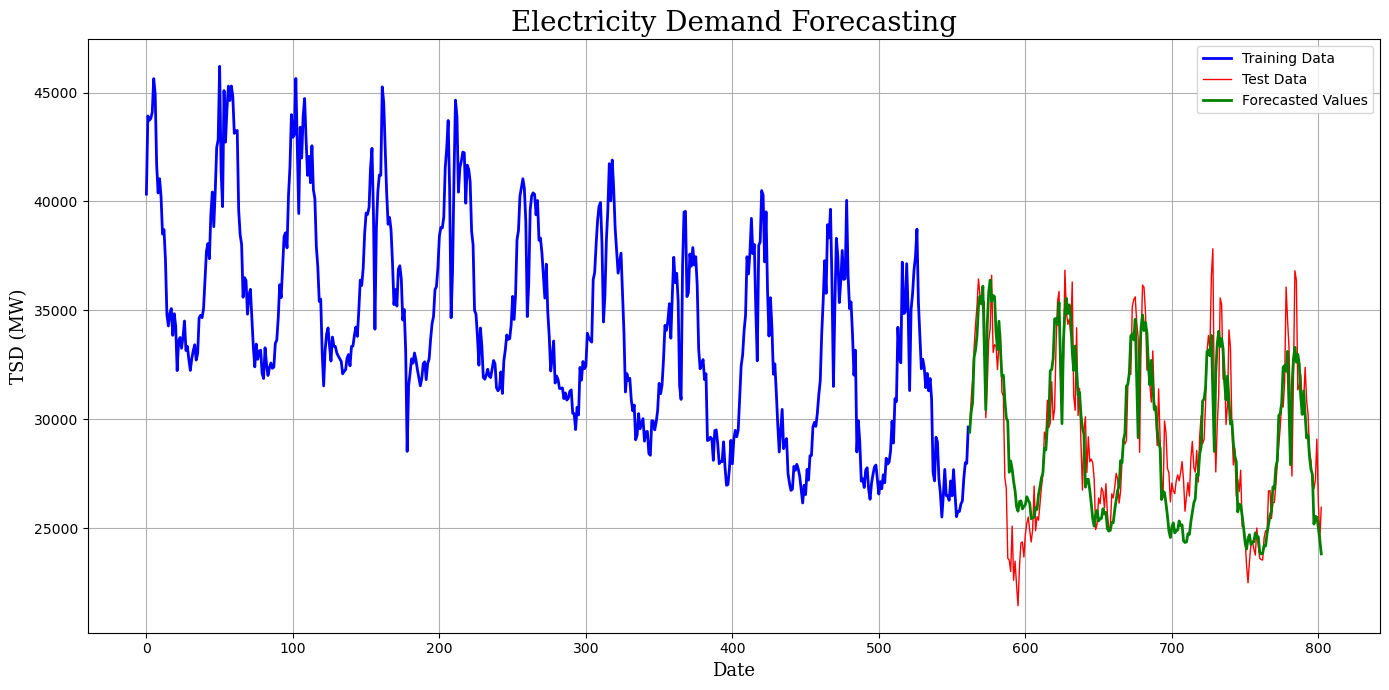

In [65]:

train_size = int(len(sarima_data) * 0.7)  # 70% for training
train_data = sarima_data.iloc[:train_size]['tsd']
test_data = sarima_data.iloc[train_size:]['tsd']

plt.figure(figsize=(14, 7))

# Plot the training data
plt.plot(train_data.index, train_data, label='Training Data', color='blue', linewidth=2)

# Plot the test data
plt.plot(test_data.index, test_data, label='Test Data', color='red', linestyle='-', linewidth=1)

# Plot the forecasted values
plt.plot(output.index, output['sarima'], label='Forecasted Values', color='green', linewidth=2)

# Add labels and title
plt.xlabel('Date', fontsize=13, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=13, fontfamily='serif')
plt.title('Electricity Demand Forecasting', fontsize=20, fontfamily='serif')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('train_test_forecast_split.png')  # Save the plot as an image file
plt.show()

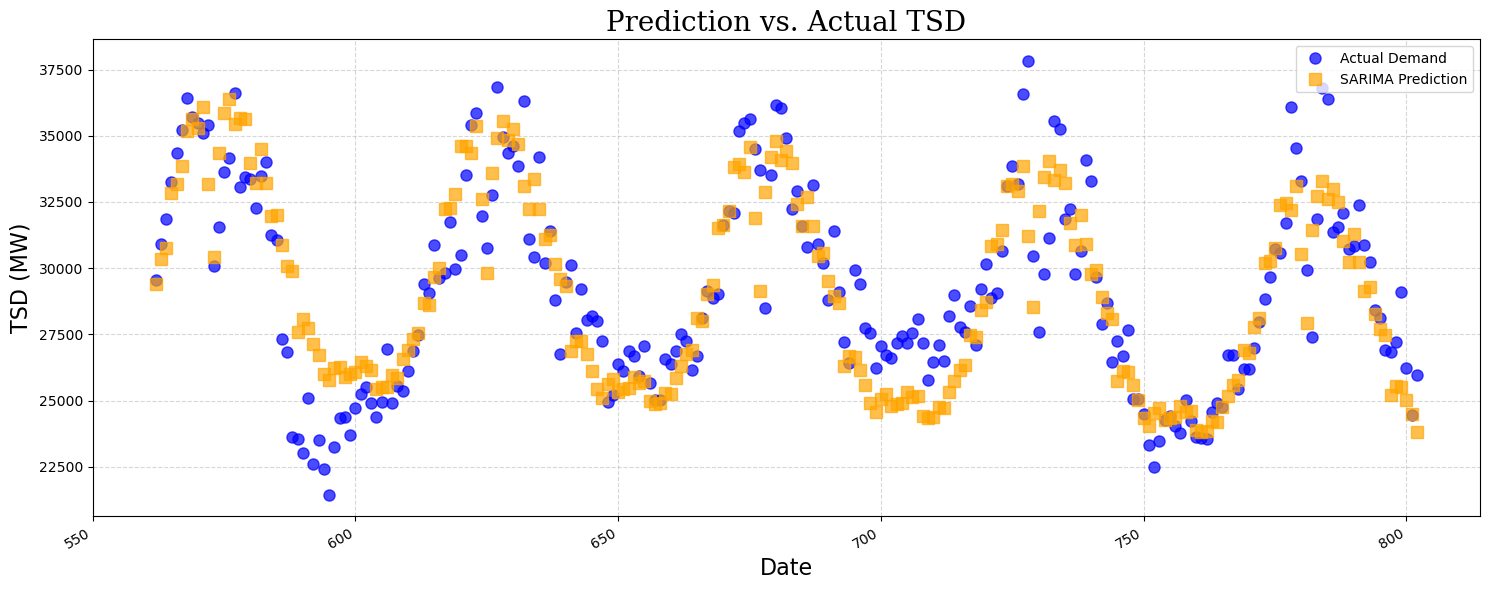

In [66]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the test set and predictions with enhanced styling
ax.plot(output.index, output["tsd"], 'o', color='blue', label='Actual Demand', markersize=8, alpha=0.7)
ax.plot(output.index, output["sarima"], 's', color='orange', label='SARIMA Prediction', markersize=8, alpha=0.7)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# Add title and labels
ax.set_title('Prediction vs. Actual TSD', fontsize=20, fontfamily='serif')
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('TSD (MW)', fontsize=16)

# Set legend
ax.legend(loc='upper right', fontsize=10)

# Improve date formatting if needed
fig.autofmt_xdate()

# Show plot
plt.tight_layout()
plt.savefig('sarima_results.png', dpi=300)
plt.show()


In [38]:
output.shape

(241, 2)

# LSTM

In [132]:
weekly_data.shape

(647, 13)

In [133]:
# Drop rows with NaNs in lag columns
weekly_data = weekly_data.dropna(subset=['lag1', 'lag2', 'lag3'])


In [134]:
# Split data into train and test sets
train_size = int(len(weekly_data) * 0.7)  # 70% for training
train_data, test_data = weekly_data.iloc[:train_size], weekly_data.iloc[train_size:]


In [135]:
features = [
    "holidays",
    "month",
    "week",
    "year",
    "quarter",
    "month",
    "year",
    "embedded_wind_generation",
    "embedded_solar_generation",
    "lag1",
    "lag2",
    "lag3",
    "rolling_mean_4",
    "rolling_std_4"
]
target = "tsd"

feature_target = features.copy()
feature_target.append(target)

train_data = train_data[feature_target]
test_data = test_data[feature_target]

X_test = test_data[features]
y_test = test_data[target]

output_lstm = y_test.to_frame()

In [136]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Reshape data for LSTM
X_train_data = train_data_scaled[:, :-1].reshape(train_data_scaled.shape[0], 1, len(features))
y_train_data = train_data_scaled[:, -1]

X_test_data = test_data_scaled[:, :-1].reshape(test_data_scaled.shape[0], 1, len(features))
y_test_data = test_data_scaled[:, -1]

# Split train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_data,      
    y_train_data,       
    test_size=0.2,
    random_state=42
)


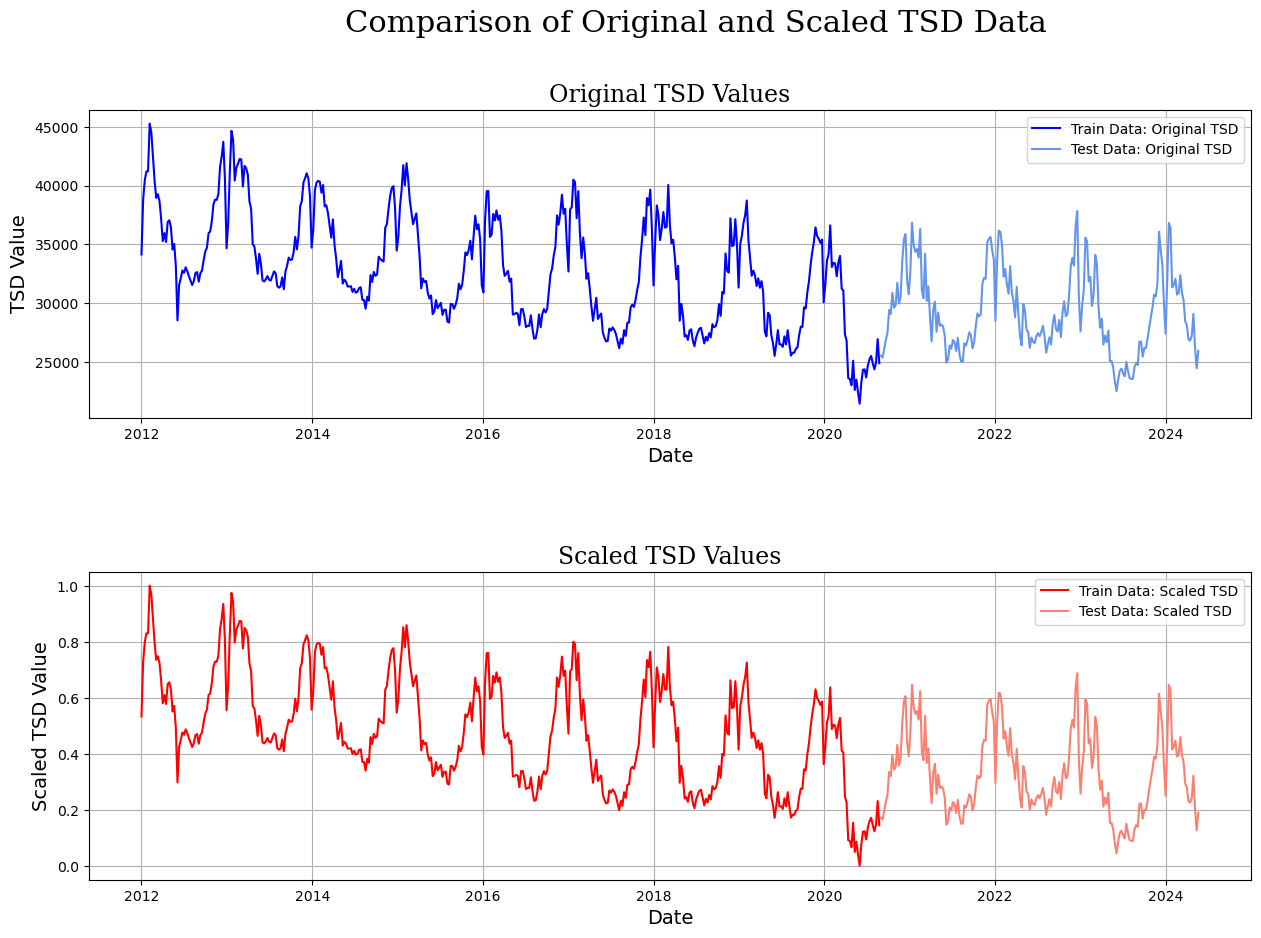

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

# Extract the original TSD values before scaling
train_tsd_original = train_data[target]
test_tsd_original = test_data[target]

# Extract the scaled TSD values from the scaled data
train_tsd_scaled1 = train_data_scaled[:, -1]
test_tsd_scaled1 = test_data_scaled[:, -1]

# Ensure indices are properly aligned
train_index = train_data.index
test_index = test_data.index

# Plot TSD values before and after scaling
plt.figure(figsize=(15, 10))
plt.suptitle('Comparison of Original and Scaled TSD Data', fontsize=22, y=0.98,x=0.53,fontfamily='serif')
# Plot original TSD for training and test data
plt.subplot(2, 1, 1)
plt.plot(train_index, train_tsd_original, label='Train Data: Original TSD', color='blue')
plt.plot(test_index, test_tsd_original, label='Test Data: Original TSD', color='cornflowerblue')
plt.title('Original TSD Values',fontsize='17',fontfamily='serif')
plt.xlabel('Date',fontsize='14')
plt.ylabel('TSD Value',fontsize='14')
plt.legend()
plt.grid(True)

# Plot scaled TSD for training and test data
plt.subplot(2, 1, 2)
plt.plot(train_index, train_tsd_scaled1, label='Train Data: Scaled TSD', color='red')
plt.plot(test_index, test_tsd_scaled1, label='Test Data: Scaled TSD', color='salmon')
plt.title('Scaled TSD Values',fontsize='17',fontfamily='serif')
plt.xlabel('Date',fontsize='14')
plt.ylabel('Scaled TSD Value',fontsize='14')
plt.legend()
plt.grid(True)
plt.subplots_adjust(hspace=0.5)

plt.show()
plt.savefig('train_test_scaled1.png',dpi=300)

In [137]:
import random
random.seed(42)   

# Build LSTM model
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train_data.shape[1], X_train_data.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss=root_mean_squared_error)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 256)            277504    
                                                                 
 dropout_15 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_16 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [138]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpoint_save = ModelCheckpoint(
    "best_model.h5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min'
)

# Fit model
history = model.fit(
    X_train_data,
    y_train_data,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_data, y_test_data),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)


Epoch 1/100
15/15 [==============================] - 9s 132ms/step - loss: 0.4363 - val_loss: 0.1387 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.2057

C:\Users\SHREY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 0s 19ms/step - loss: 0.2057 - val_loss: 0.1119 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 0s 19ms/step - loss: 0.1347 - val_loss: 0.0638 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0740 - val_loss: 0.0963 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0729 - val_loss: 0.0615 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0630 - val_loss: 0.0737 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0648 - val_loss: 0.0536 - lr: 0.0010
Epoch 8/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0637 - val_loss: 0.0627 - lr: 0.0010
Epoch 9/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0635 - val_loss: 0.0660 - lr: 0.0010
Epoch 10/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0630 - val_loss: 0.0534 - lr: 0

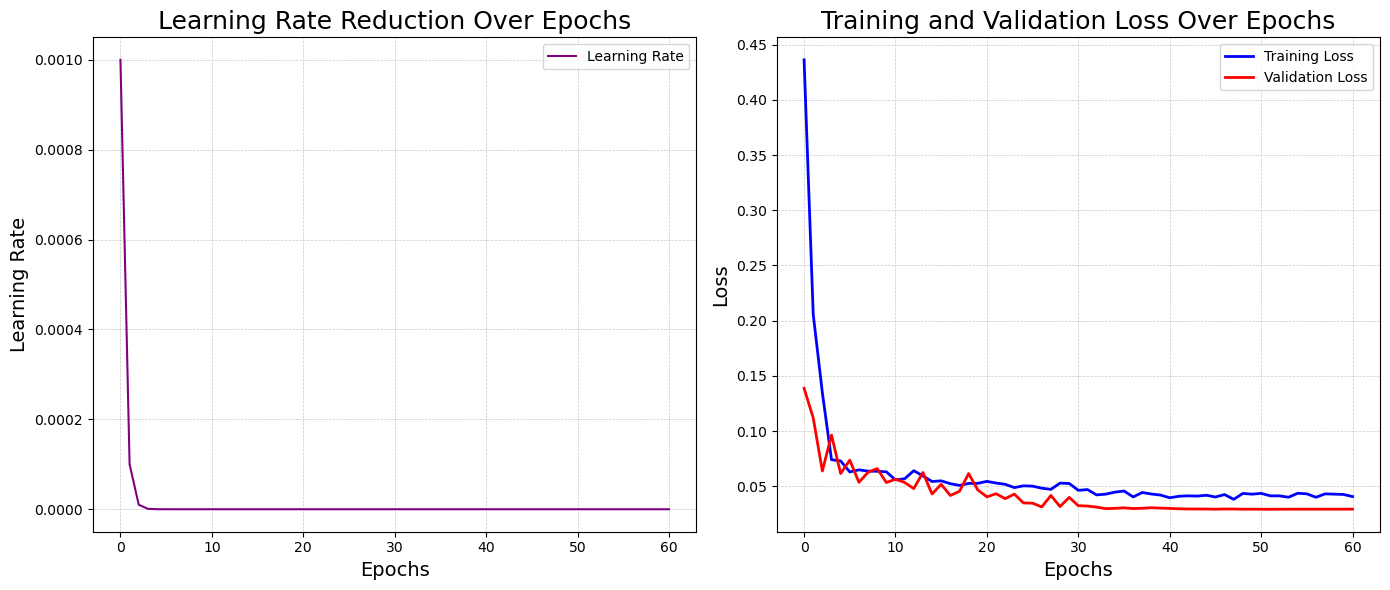

In [140]:
import matplotlib.pyplot as plt

# Ensure that 'loss' and 'val_loss' are present in the history
if 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(14, 6))

    # Plot Learning Rate Changes
    plt.subplot(1, 2, 1)
    lr_changes = [0.001 * (0.1**i) for i in range(len(history.history['loss']))]  # Example, adjust as per your settings
    plt.plot(lr_changes, label='Learning Rate', color='purple')
    plt.title('Learning Rate Reduction Over Epochs', fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Learning Rate', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue',linewidth='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red',linewidth='2')
    plt.title('Training and Validation Loss Over Epochs', fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.savefig('lstm_learning.png', dpi=300)
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show plot
    plt.show()
else:
    print("Error: Training or validation loss data is missing from history.")
    
   


In [139]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicting on the test set
predicted_scaled = model.predict(X_test_data)

# Inverse transform the predictions and original test data
# Concatenate with original scaled input (except the last column which was predicted)
predicted_values = scaler.inverse_transform(np.concatenate((X_test_data[:, 0, :], predicted_scaled), axis=1))[:, -1]
original_values = scaler.inverse_transform(np.concatenate((X_test_data[:, 0, :], y_test_data.reshape(-1, 1)), axis=1))[:, -1]

# output['lstm'] = predicted_values

# Calculate metrics
mae = mean_absolute_error(original_values, predicted_values)
rmse =root_mean_squared_error(original_values, predicted_values)
mape = mean_absolute_percentage_error(original_values, predicted_values)
r2 = r2_score(original_values, predicted_values)

# Adjusted R-squared calculation
n = len(original_values)
p = 1  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f"MAE: {round(mae, 2)}")
print(f"RMSE: {rmse}")
print(f"MAPE: {round(mape, 3)}")
print(f"R-squared: {round(r2, 3)}")
print(f"Adjusted R-squared: {round(adjusted_r2, 3)}")

7/7 [==============================] - 1s 5ms/step
MAE: 558.7
RMSE: 722.7362037122565
MAPE: 0.019
R-squared: 0.956
Adjusted R-squared: 0.956


In [141]:
output_lstm['lstm'] = predicted_values
output_lstm.index = weekly_data.index[train_size:train_size + len(predicted_values)]

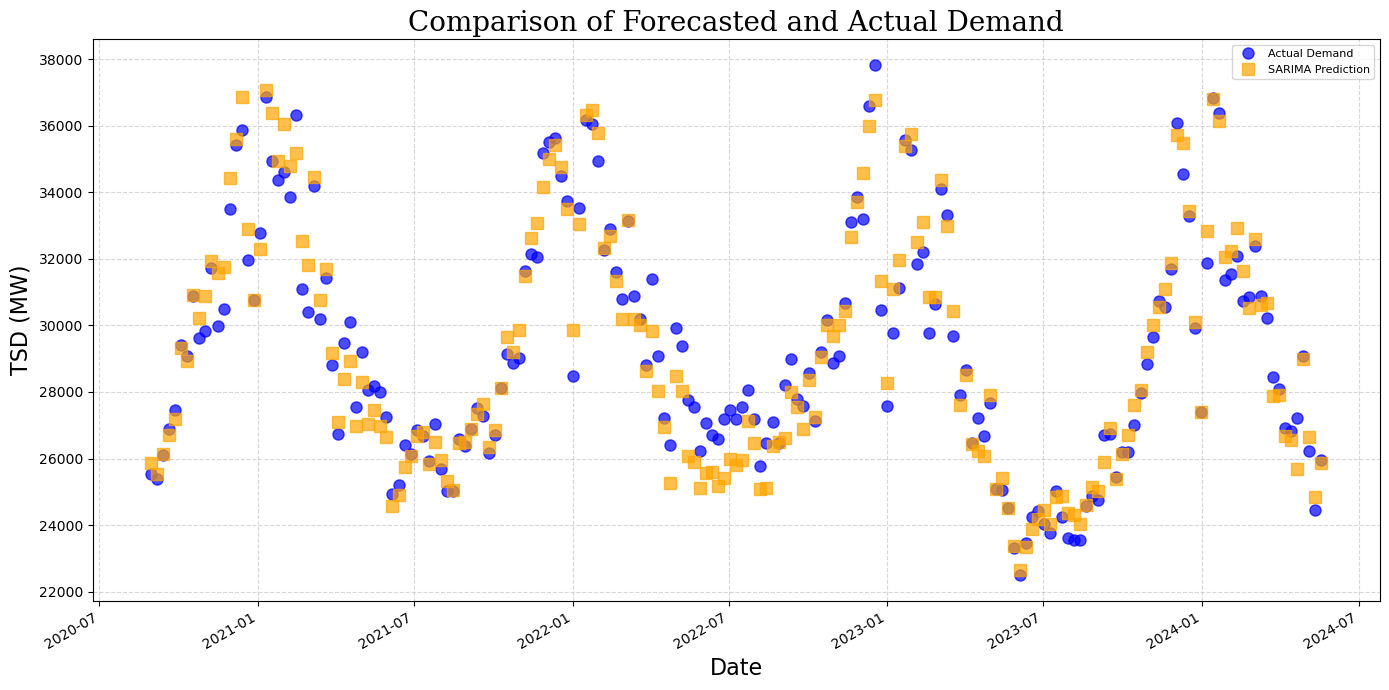

In [142]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the test set and predictions with enhanced styling
ax.plot(output_lstm.index, output_lstm["tsd"], 'o', color='blue', label='Actual Demand', markersize=8, alpha=0.7)
ax.plot(output_lstm.index, output_lstm["lstm"], 's', color='orange', label='SARIMA Prediction', markersize=8, alpha=0.7)
# Add grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# Add title and labels
ax.set_title('Comparison of Forecasted and Actual Demand', fontsize=20, fontfamily='serif')
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('TSD (MW)', fontsize=16)

# Set legend
ax.legend(loc='upper right', fontsize=8)

# Improve date formatting if needed
fig.autofmt_xdate()

# Show plot
plt.tight_layout()
plt.savefig('lstm_results.png', dpi=300)
plt.show()


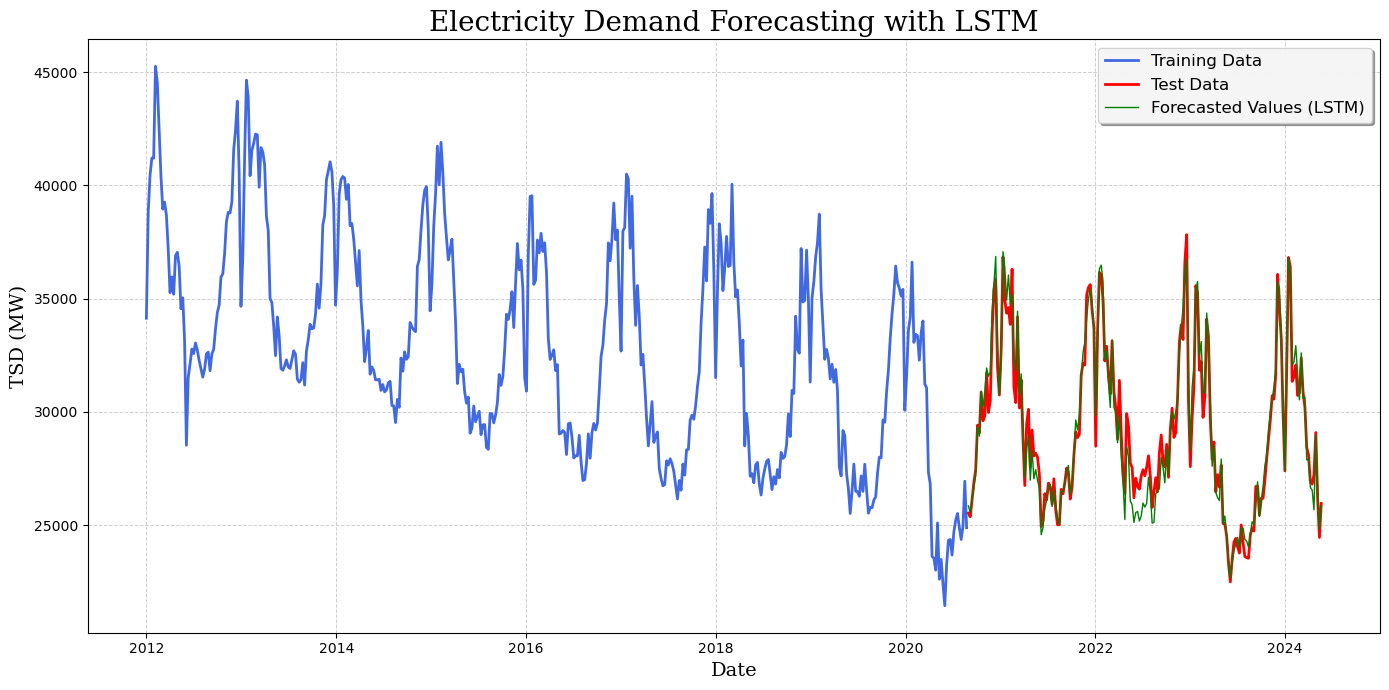

<Figure size 640x480 with 0 Axes>

In [143]:
# Enhanced Plotting Code
import matplotlib.pyplot as plt

# Creating the plot with enhancements
plt.figure(figsize=(14, 7))

# Plot the training data with a thicker line and consistent blue color
plt.plot(train_data.index, train_data[target], label='Training Data', color='royalblue', linewidth=2, linestyle='-')

# Plot the test data with a dotted red line
plt.plot(test_data.index, test_data[target], label='Test Data', color='red', linewidth=2)

# Plot the forecasted values with a thinner green line and marker
plt.plot(test_data.index, predicted_values, label='Forecasted Values (LSTM)', color='green', linewidth=1, markersize=5)

# Add labels and title with enhanced font sizes and serif font
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')
plt.title('Electricity Demand Forecasting with LSTM', fontsize=20, fontfamily='serif')

# Customizing the legend for better clarity
plt.legend(fontsize=12, loc='best', frameon=True, framealpha=0.9, fancybox=True, shadow=True)

# Customizing the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Ensuring everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()
plt.savefig('lstm_results_train.png', dpi=300)

In [120]:
output.to_csv('output_lstm_.csv')

# XGBoost

### Data Preparation

In [18]:
# Define the sizes for the splits
train_size = 0.7  # 70% for training
test_size = 0.2   # 20% for testing
holdout_size = 0.1 # 10% for hold-out

# Calculate the indices for the splits
train_index = int(len(weekly_data) * train_size)
test_index = int(len(weekly_data) * (train_size + test_size))

# Perform the splits
train_data = weekly_data.iloc[:train_index]
test_data = weekly_data.iloc[train_index:test_index]
holdout_data = weekly_data.iloc[test_index:]

In [19]:
fold = 0
preds = []
scores = []
# Example feature columns
features = ["holidays", 
            "month", 
            "week", 
            "year", 
            "quarter", 
            "embedded_wind_generation", 
            "embedded_solar_generation",
            'lag1',
            'lag2',
            'lag3',
            'rolling_mean_4',
            'rolling_std_4']
target = 'tsd'

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

X_hold_out = holdout_data[features]
y_hold_out = holdout_data[target]



In [20]:
# for evaluation
# Combine test and holdout data into a single DataFrame for evaluation
combined_test_holdout = pd.concat([test_data, holdout_data], axis=0)

# Ensure DataFrame is sorted by Date (or index if Date column does not exist)
combined_test_holdout.sort_index(inplace=True)
# combined_test_holdout.reset_index(drop=True, inplace=True)


X_combined_test_holdout = combined_test_holdout[features]
y_combined_test_holdout = combined_test_holdout[target]


### simple model

In [174]:
xgb_simple = xgb.XGBRegressor(
    n_estimators=300, 
    max_depth=3, 
    learning_rate=0.01, 
    early_stopping_rounds=50,
    random_state=43, 
)
xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);

[0]	validation_0-rmse:4649.79042	validation_1-rmse:5946.79588
[100]	validation_0-rmse:1835.58728	validation_1-rmse:2319.71039
[200]	validation_0-rmse:788.80143	validation_1-rmse:947.25405
[299]	validation_0-rmse:427.75336	validation_1-rmse:535.57688


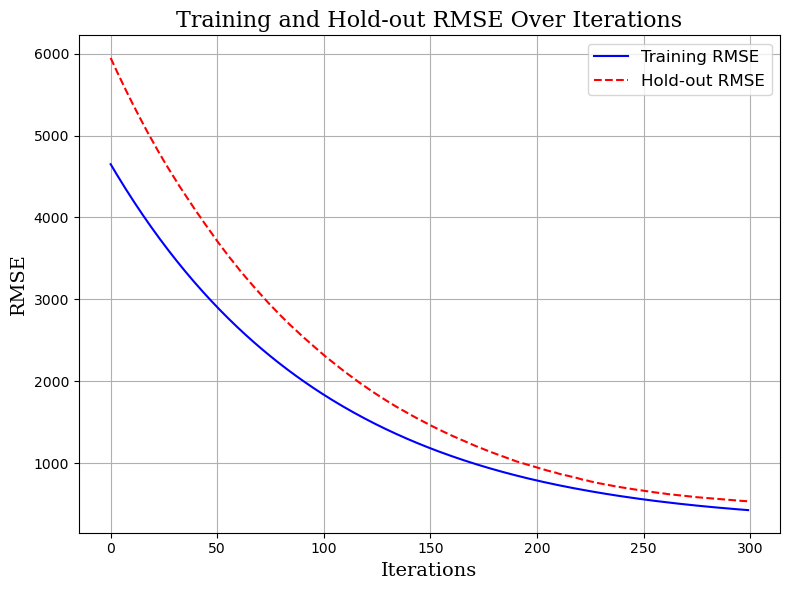

In [17]:
# Extract the evaluation results from the training process
results = xgb_simple.evals_result()

# Plotting RMSE for both training and hold-out sets over iterations
plt.figure(figsize=(8, 6))

# Plot training RMSE
plt.plot(results['validation_0']['rmse'], label='Training RMSE', color='blue')

# Plot hold-out RMSE
plt.plot(results['validation_1']['rmse'], label='Hold-out RMSE', color='red', linestyle='--')

# Add title and labels
plt.title('Training and Hold-out RMSE Over Iterations', fontsize=16,fontfamily='serif')
plt.xlabel('Iterations', fontsize=14,fontfamily='serif')
plt.ylabel('RMSE', fontsize=14,fontfamily='serif')

# Display legend
plt.legend(fontsize=12)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on the test set using xgb_simple
y_pred_test = xgb_simple.predict(X_test)
# Predict on the holdout set using xgb_simple
y_pred_holdout = xgb_simple.predict(X_hold_out)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

# Adjusted R-squared calculation
n = len(y_test)
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f"MAE: {round(mae, 2)}")
print(f"RMSE: {rmse}")
print(f"MAPE: {round(mape, 3)}")
print(f"R-squared: {round(r2, 3)}")
print(f"Adjusted R-squared: {round(adjusted_r2, 3)}")

MAE: 387.94
RMSE: 490.47781047068463
MAPE: 0.013
R-squared: 0.977
Adjusted R-squared: 0.974


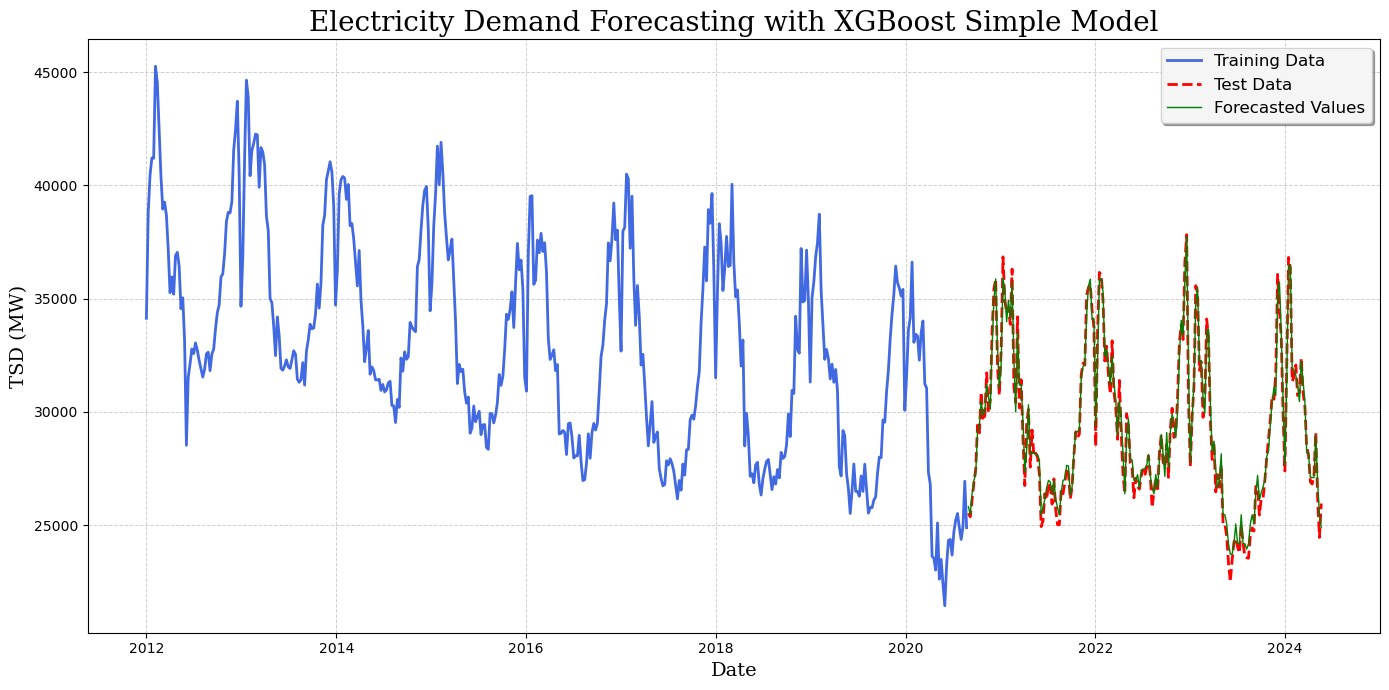

<Figure size 640x480 with 0 Axes>

In [180]:

combined_res=xgb_simple.predict(X_combined_test_holdout)
# Creating the plot with enhancements
plt.figure(figsize=(14, 7))

# Plot the training data with a thicker line and consistent blue color
plt.plot(train_data.index, train_data['tsd'], label='Training Data', color='royalblue', linewidth=2, linestyle='-')

# Plot the test data with a dotted red line
plt.plot(combined_test_holdout.index, combined_test_holdout['tsd'], label='Test Data', color='red', linewidth=2, linestyle='--')

# Plot the forecasted values for the test set with a thinner green line and marker
plt.plot(combined_test_holdout.index, combined_res, label='Forecasted Values', color='green', linewidth=1)


# Add labels and title with enhanced font sizes and serif font
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')
plt.title('Electricity Demand Forecasting with XGBoost Simple Model', fontsize=20, fontfamily='serif')

# Customizing the legend for better clarity
plt.legend(fontsize=12, loc='best', frameon=True, framealpha=0.9, fancybox=True, shadow=True)

# Customizing the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Ensuring everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
plt.savefig('xgboost_simple_results.png', dpi=300)


### model with Grid search and cv

In [21]:
# TimeSeriesSplit for cross-validation
time_series_split = TimeSeriesSplit(n_splits=4, test_size=52, gap=2) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


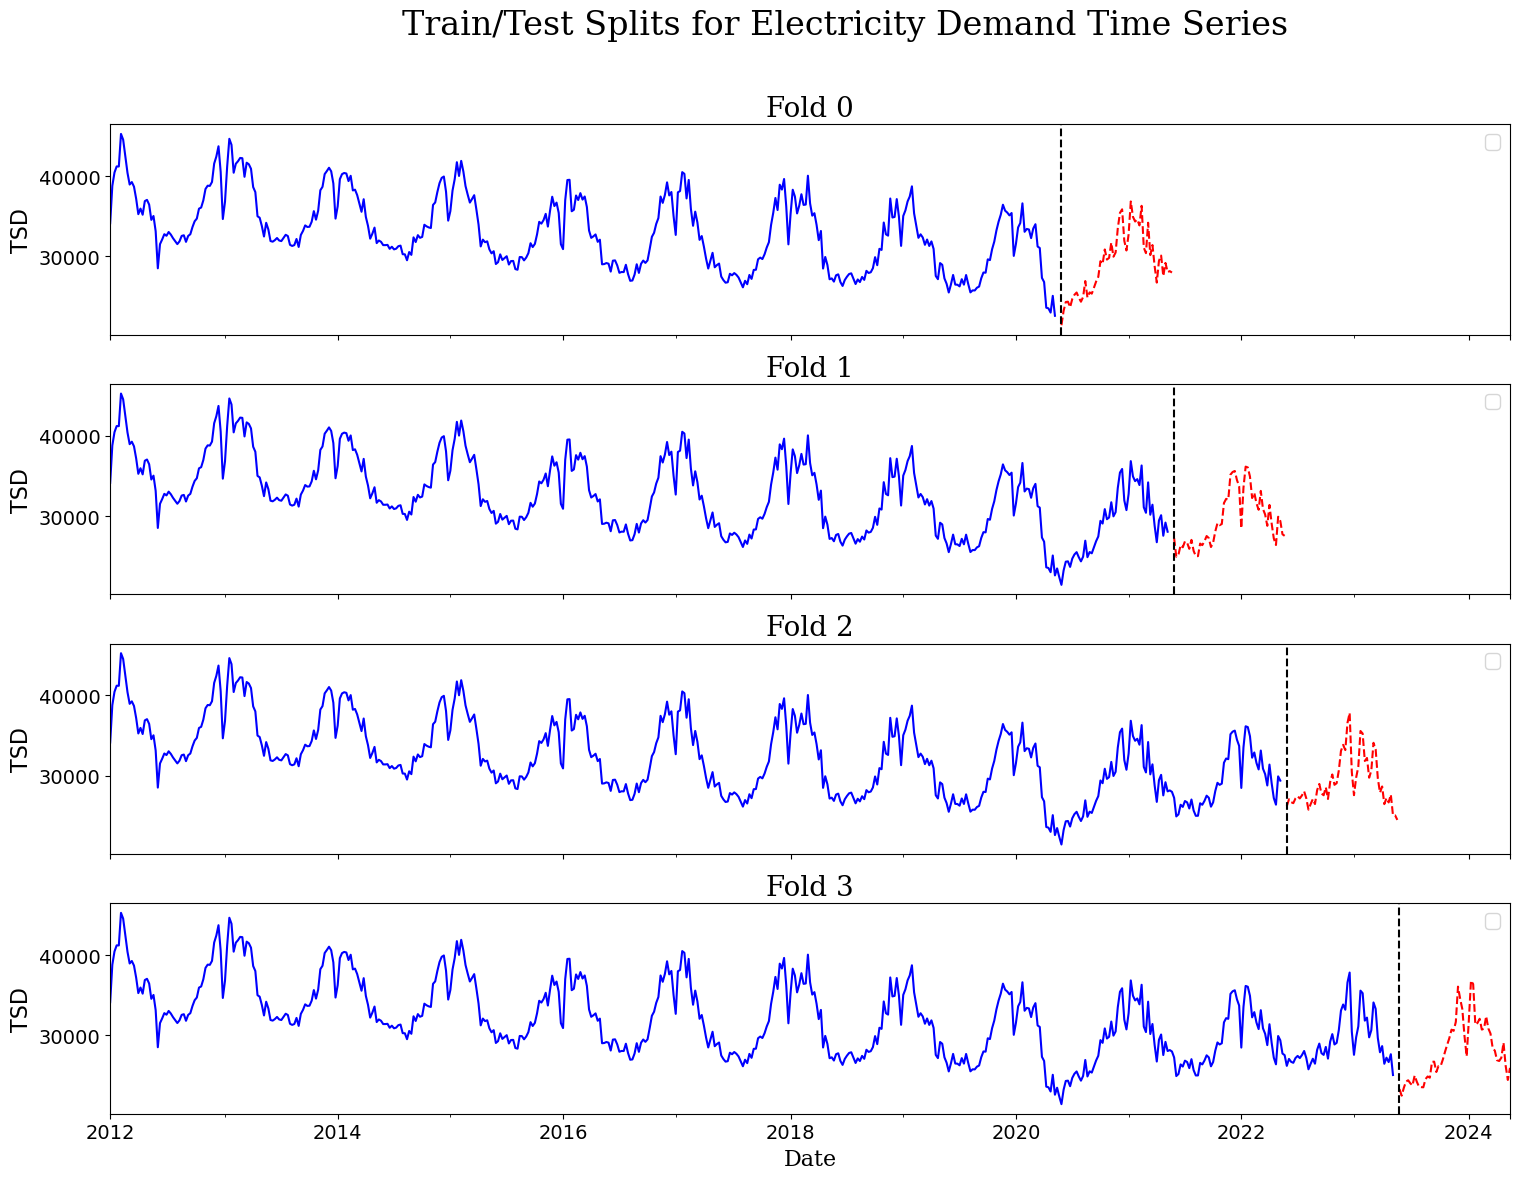

In [201]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(17, 12), sharex=True)

# Enhance the appearance of the plots
for ax in axs:
    ax.grid(True)  # Add grid lines
    ax.set_ylabel('TSD', fontsize=16)  # Set y-axis label with increased fontsize
    ax.legend(fontsize=14)  # Set legend fontsize
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size

fold = 0
for train_idx, val_idx in time_series_split.split(weekly_data):
    train = weekly_data.iloc[train_idx]
    test = weekly_data.iloc[val_idx]
    
    # Plot training and test sets with improved appearance
    train['tsd'].plot(ax=axs[fold], color='blue', linestyle='-', label='Training Set')
    test['tsd'].plot(ax=axs[fold], color='red', linestyle='--', label='Test Set')
    
    # Add vertical line to indicate split point
    axs[fold].axvline(test.index.min(), color='black', linestyle='--', label='Split Point')
    
    # Customize title and labels
    axs[fold].set_title(f'Fold {fold}', fontsize=20, fontfamily='serif')
    
    fold += 1

# Improve x-axis formatting and labels
plt.xlabel('Date', fontsize=16, fontfamily='serif')

# Adjust spacing between plots and add a title to the figure
plt.subplots_adjust(hspace=0.4)  # Increase space between plots
fig.suptitle('Train/Test Splits for Electricity Demand Time Series', fontsize=24, fontfamily='serif')

# Save the figure
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Adjust to fit the suptitle
plt.savefig('train_test_fold.png', dpi=300)
plt.show()


In [240]:


# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5, 
    booster="gbtree",  
    learning_rate=0.01,
    tree_method="hist",
    random_state=43, 
    eval_metric="rmse" 
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5], 
    "n_estimators": [350, 500, 650], 
    "subsample": [0.95, 0.8, 0.7],
}

# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=time_series_split,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train,
               y_train,
               eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
               verbose=200);

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[0]	validation_0-rmse:32899.84268	validation_1-rmse:27973.50391
[200]	validation_0-rmse:4383.67706	validation_1-rmse:3005.09220
[349]	validation_0-rmse:1245.01757	validation_1-rmse:1598.87558
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-1074.618 total time=   0.3s
[0]	validation_0-rmse:32902.35830	validation_1-rmse:27977.52390
[200]	validation_0-rmse:4444.22193	validation_1-rmse:3139.09172
[349]	validation_0-rmse:1188.03108	validation_1-rmse:1341.45329
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-1079.683 total time=   0.2s
[0]	validation_0-rmse:32904.94779	validation_1-rmse:27982.11849
[200]	validation_0-rmse:4471.38830	validation_1-rmse:3210.67110
[349]	validation_0-rmse:1177.15851	validation_1-rmse:1324.09926
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-1002.591 total time=   0.2s
[0]	validation_0-rmse:32906.57343	validation_1-rmse:27986.51765
[200]	valid

[400]	validation_0-rmse:885.97986	validation_1-rmse:1335.35125
[600]	validation_0-rmse:666.53383	validation_1-rmse:1434.76569
[649]	validation_0-rmse:662.32058	validation_1-rmse:1439.14653
[CV 2/4] END max_depth=3, n_estimators=650, subsample=0.95;, score=-459.970 total time=   0.4s
[0]	validation_0-rmse:32904.94779	validation_1-rmse:27982.11849
[200]	validation_0-rmse:4471.38830	validation_1-rmse:3210.67110
[400]	validation_0-rmse:868.04454	validation_1-rmse:1311.05755
[600]	validation_0-rmse:647.31181	validation_1-rmse:1411.63719
[649]	validation_0-rmse:642.43103	validation_1-rmse:1416.90457
[CV 3/4] END max_depth=3, n_estimators=650, subsample=0.95;, score=-528.996 total time=   0.4s
[0]	validation_0-rmse:32906.57343	validation_1-rmse:27986.51765
[200]	validation_0-rmse:4495.02659	validation_1-rmse:3306.79575
[400]	validation_0-rmse:795.24746	validation_1-rmse:995.60781
[600]	validation_0-rmse:516.90591	validation_1-rmse:1046.29413
[649]	validation_0-rmse:508.86435	validation_1-rmse

[200]	validation_0-rmse:4444.22193	validation_1-rmse:3139.09172
[400]	validation_0-rmse:883.12030	validation_1-rmse:1308.59249
[499]	validation_0-rmse:674.58983	validation_1-rmse:1337.94046
[CV 2/4] END max_depth=5, n_estimators=500, subsample=0.95;, score=-566.342 total time=   0.3s
[0]	validation_0-rmse:32904.94779	validation_1-rmse:27982.11849
[200]	validation_0-rmse:4471.38830	validation_1-rmse:3210.67110
[400]	validation_0-rmse:856.84251	validation_1-rmse:1278.30315
[499]	validation_0-rmse:643.00322	validation_1-rmse:1302.70955
[CV 3/4] END max_depth=5, n_estimators=500, subsample=0.95;, score=-568.581 total time=   0.3s
[0]	validation_0-rmse:32906.57343	validation_1-rmse:27986.51765
[200]	validation_0-rmse:4495.02659	validation_1-rmse:3306.79575
[400]	validation_0-rmse:779.95629	validation_1-rmse:946.92725
[499]	validation_0-rmse:518.57863	validation_1-rmse:937.34220
[CV 4/4] END max_depth=5, n_estimators=500, subsample=0.95;, score=-1197.227 total time=   0.4s
[0]	validation_0-r

[200]	validation_0-rmse:4525.82326	validation_1-rmse:3296.91837
[400]	validation_0-rmse:799.42224	validation_1-rmse:949.58352
[600]	validation_0-rmse:468.79996	validation_1-rmse:948.24105
[649]	validation_0-rmse:459.65689	validation_1-rmse:957.04925
[CV 4/4] END max_depth=5, n_estimators=650, subsample=0.7;, score=-1232.697 total time=   0.7s
[0]	validation_0-rmse:32908.19383	validation_1-rmse:27999.65134
[200]	validation_0-rmse:4563.80204	validation_1-rmse:3722.61490
[400]	validation_0-rmse:711.90444	validation_1-rmse:774.76129
[600]	validation_0-rmse:228.98935	validation_1-rmse:489.39956
[649]	validation_0-rmse:202.99670	validation_1-rmse:476.35279


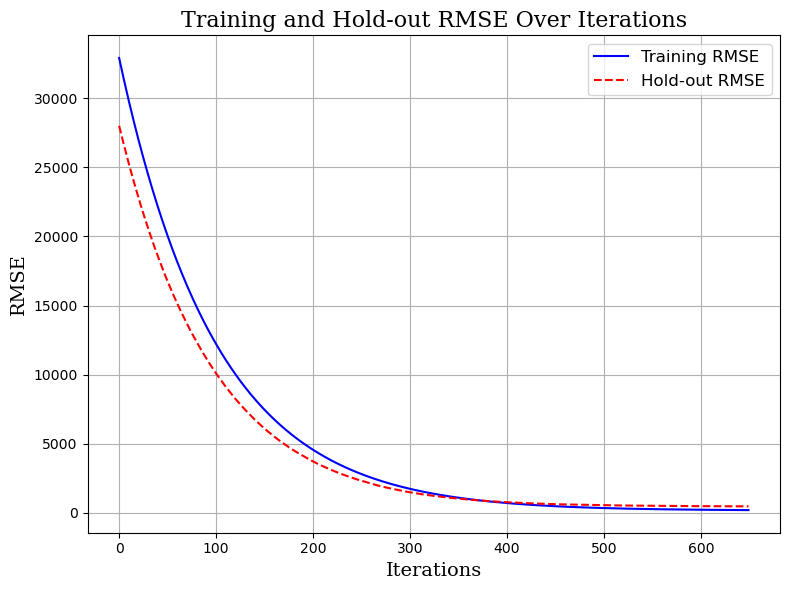

In [53]:

best_params = xgb_search.best_params_


# Initialize and fit the best model
best_model = xgb.XGBRegressor(
    **best_params,
    base_score=0.5,
    booster="gbtree",
    learning_rate=0.01,
    tree_method="hist",
    random_state=43,
    eval_metric="rmse"
)

# Fit the model with eval_set
evals = [(X_train, y_train), (X_hold_out, y_hold_out)]
best_model.fit(X_train, y_train, eval_set=evals, verbose=200)

# Extract the evaluation results from the best model
results = best_xgb_model.evals_result()

# Plotting RMSE for both training (validation_0) and hold-out (validation_1) sets over iterations
plt.figure(figsize=(8, 6))

# Plot training RMSE (validation_0)
plt.plot(results['validation_0']['rmse'], label='Training RMSE', color='blue')

# Plot hold-out RMSE (validation_1)
plt.plot(results['validation_1']['rmse'], label='Hold-out RMSE', color='red', linestyle='--')

# Add title and labels
plt.title('Training and Hold-out RMSE Over Iterations', fontsize=16, fontfamily='serif')
plt.xlabel('Iterations', fontsize=14, fontfamily='serif')
plt.ylabel('RMSE', fontsize=14, fontfamily='serif')

# Display legend
plt.legend(fontsize=12)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# Predict on the test set using xgb_search
y_pred_testcv = xgb_search.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred_testcv)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_testcv))
mape = mean_absolute_percentage_error(y_test, y_pred_testcv)
r2 = r2_score(y_test, y_pred_testcv)

# Adjusted R-squared calculation
n = len(y_test)
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f"MAE: {round(mae, 2)}")
print(f"RMSE: {round(rmse, 2)}")
print(f"MAPE: {round(mape, 3)}")
print(f"R-squared: {round(r2, 3)}")
print(f"Adjusted R-squared: {round(adjusted_r2, 3)}")

MAE: 369.56
RMSE: 477.37
MAPE: 0.012
R-squared: 0.978
Adjusted R-squared: 0.976


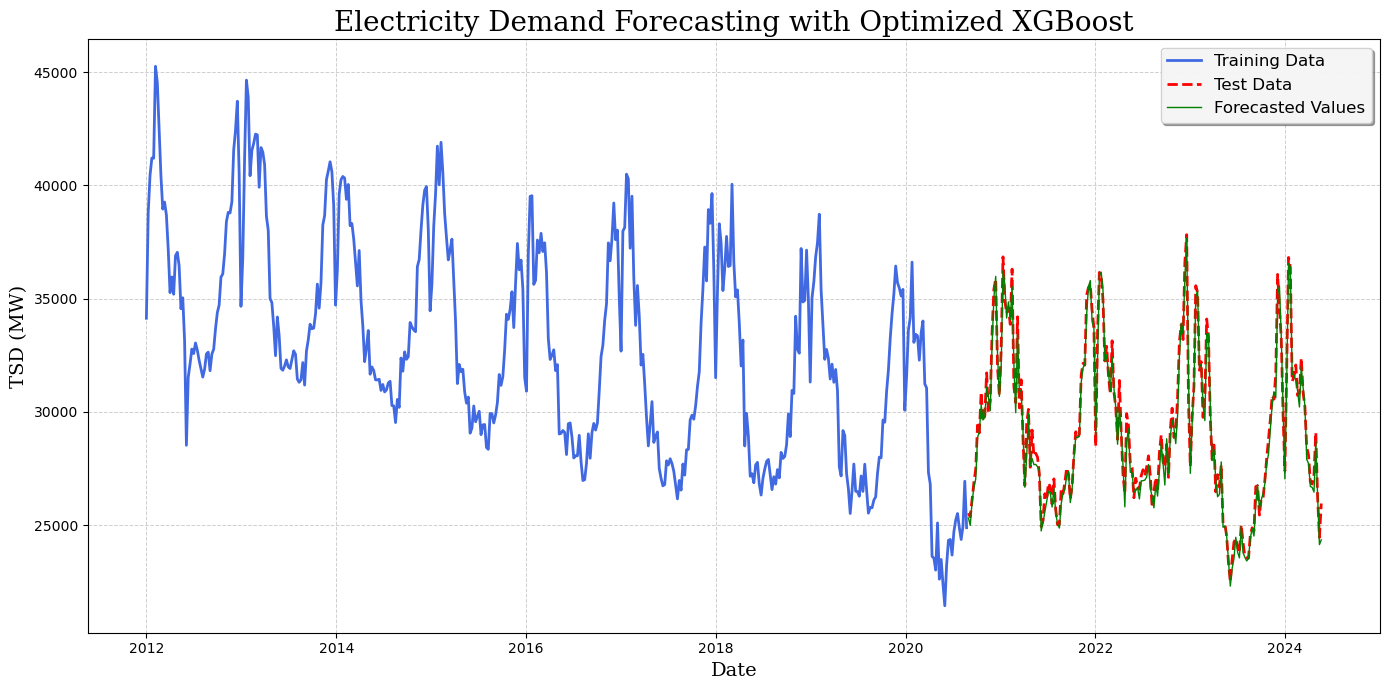

<Figure size 640x480 with 0 Axes>

In [182]:

combined_res_cv=xgb_search.predict(X_combined_test_holdout)
# Creating the plot with enhancements
plt.figure(figsize=(14, 7))

# Plot the training data with a thicker line and consistent blue color
plt.plot(train_data.index, train_data['tsd'], label='Training Data', color='royalblue', linewidth=2, linestyle='-')

# Plot the test data with a dotted red line
plt.plot(combined_test_holdout.index, combined_test_holdout['tsd'], label='Test Data', color='red', linewidth=2, linestyle='--')

# Plot the forecasted values for the test set with a thinner green line and marker
plt.plot(combined_test_holdout.index, combined_res_cv, label='Forecasted Values', color='green', linewidth=1)


# Add labels and title with enhanced font sizes and serif font
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')
plt.title('Electricity Demand Forecasting with Optimized XGBoost', fontsize=20, fontfamily='serif')

# Customizing the legend for better clarity
plt.legend(fontsize=12, loc='best', frameon=True, framealpha=0.9, fancybox=True, shadow=True)

# Customizing the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Ensuring everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
plt.savefig('xgboost_cv_results.png', dpi=300)


In [183]:
combined_df = pd.DataFrame({
    'TSD': y_combined_test_holdout.values,   # Actual values
    'XGBoost_simple': combined_res,          # XGBoost simple predictions
    'XGBoost_cv': combined_res_cv            # XGBoost CV predictions
}, index=y_combined_test_holdout.index)      # Use the index from y_combined_test_holdout (the Date)

# Ensure the DataFrame is sorted by Date (though it should already be if the index is correct)
combined_df.sort_index(inplace=True)

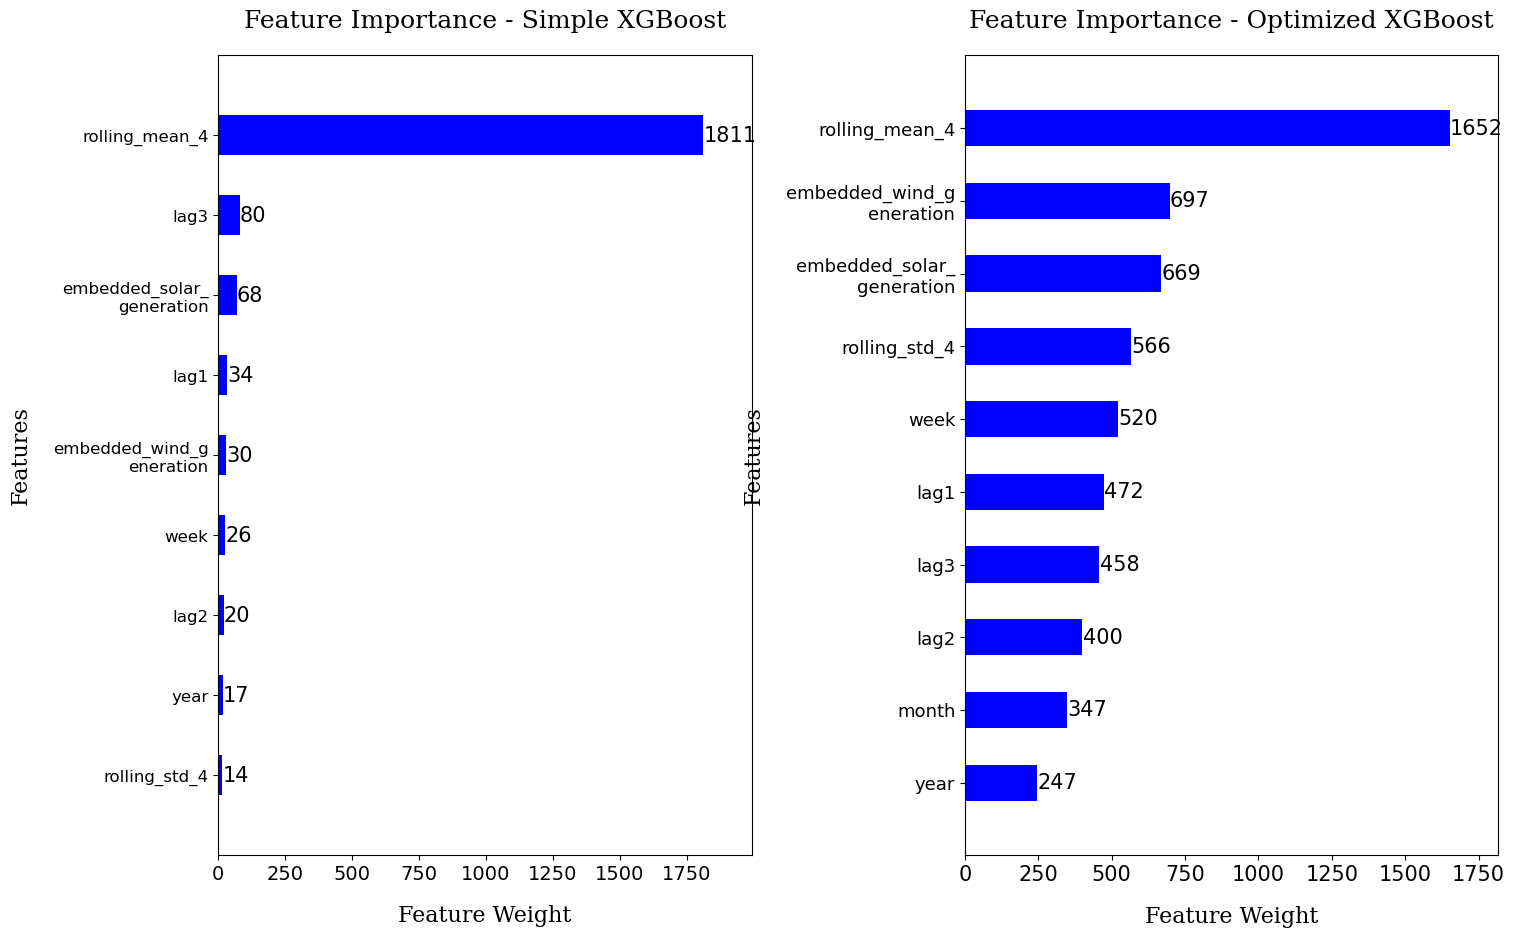

<Figure size 640x480 with 0 Axes>

In [239]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Function to wrap text labels
def wrap_labels(labels, max_length=6):
    wrapped_labels = []
    for label in labels:
        # Split label into multiple lines if it exceeds max_length
        wrapped_label = '\n'.join(label[i:i+max_length] for i in range(0, len(label), max_length))
        wrapped_labels.append(wrapped_label)
    return wrapped_labels

# Extract the best estimator from GridSearchCV
best_xgb = xgb_search.best_estimator_

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))  # Increase figure size

# Plot feature importance for xgb_simple
xgb.plot_importance(
    xgb_simple, 
    ax=ax1, 
    max_num_features=10, 
    importance_type='weight', 
    height=0.5, 
    grid=False, 
    color='blue'  # Consistent color
)
ax1.set_title('Feature Importance - Simple XGBoost', fontsize=18, fontfamily='serif', pad=20)
ax1.set_xlabel('Feature Weight', fontsize=16, fontfamily='serif', labelpad=15)
ax1.set_ylabel('Features', fontsize=16, fontfamily='serif', labelpad=15)
ax1.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size

# Apply label wrapping for xgb_simple plot
yticks = [label.get_text() for label in ax1.get_yticklabels()]
ax1.set_yticklabels(wrap_labels(yticks, max_length=15), rotation=0, horizontalalignment='right', fontsize=12)

# Plot feature importance for best_xgb
xgb.plot_importance(
    best_xgb, 
    ax=ax2, 
    importance_type='weight', 
    max_num_features=10, 
    height=0.5, 
    grid=False, 
    color='blue'  # Consistent color
)
ax2.set_title('Feature Importance - Optimized XGBoost', fontsize=18, fontfamily='serif', pad=20)
ax2.set_xlabel('Feature Weight', fontsize=16, fontfamily='serif', labelpad=15)
ax2.set_ylabel('Features', fontsize=16, fontfamily='serif', labelpad=15)
ax2.tick_params(axis='both', which='major', labelsize=15)  # Increase tick size

# Apply label wrapping for best_xgb plot
yticks = [label.get_text() for label in ax2.get_yticklabels()]
ax2.set_yticklabels(wrap_labels(yticks, max_length=15), rotation=0, horizontalalignment='right', fontsize=13)
for ax in [ax1, ax2]:
    for text in ax.texts:
        # Remove decimal places from the text and set a larger font size
        text.set_text(f"{int(float(text.get_text()))}")
        text.set_fontsize(15)  # Increase font size of the values
# Adjust layout to prevent overlap and ensure plots are not too close
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1, wspace=0.4)  # Adjust margins and width space

# Show the plot
plt.show()

# Save the plot as a PNG file with high resolution
plt.savefig('xgboost_feature_importance_comparison.png', dpi=300)


# Results 

## SARIMA

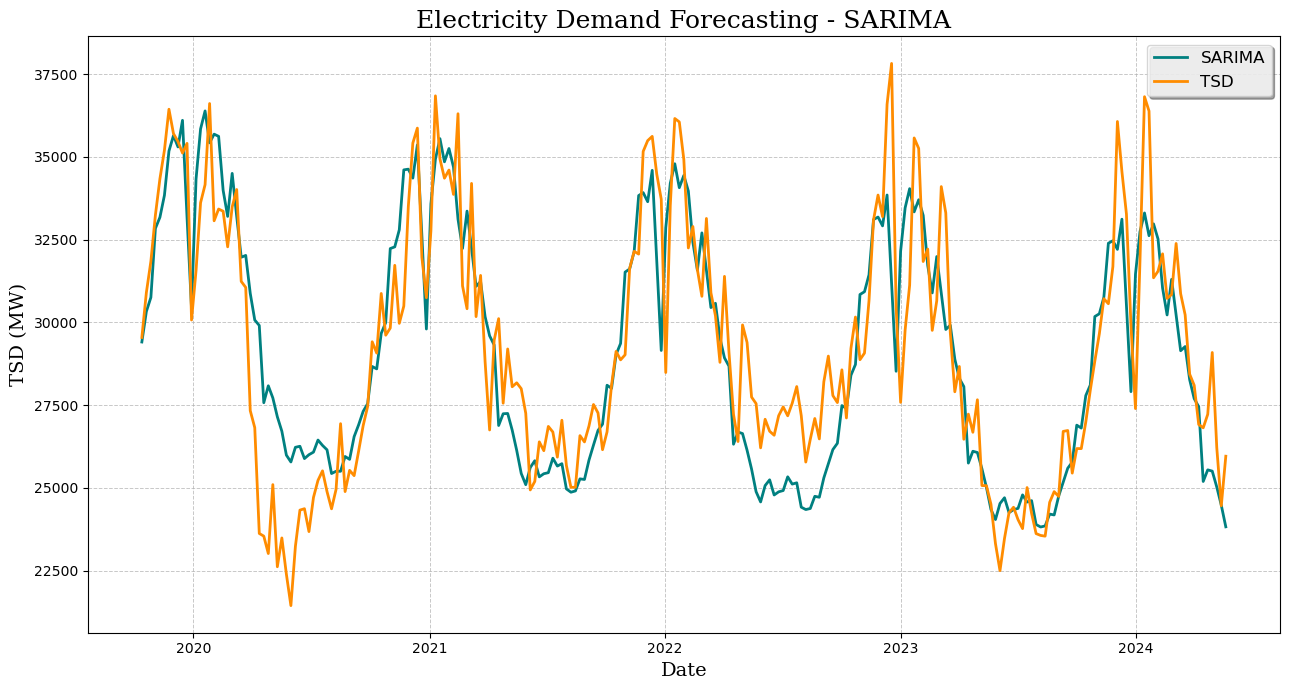

<Figure size 640x480 with 0 Axes>

In [332]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Creating the plot
plt.figure(figsize=(13, 7))  # Larger figure for better visibility

# Plot for SARIMA with enhanced style
plt.plot(output.index, output['sarima'], label='SARIMA', color='teal', linewidth=2)

# Plot for TSD with enhanced style
plt.plot(output.index, output['tsd'], label='TSD', color='darkorange', linewidth=2)

# Add title and labels with enhanced font sizes and font family
plt.title('Electricity Demand Forecasting - SARIMA', fontsize=18, fontfamily='serif')
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')

# Customize the legend for better visibility
plt.legend(fontsize=12, loc='best', frameon=True, framealpha=0.8, fancybox=True, shadow=True)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)


# Ensure everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
plt.savefig('enhanced_actual_vs_predicted.png', dpi=300)


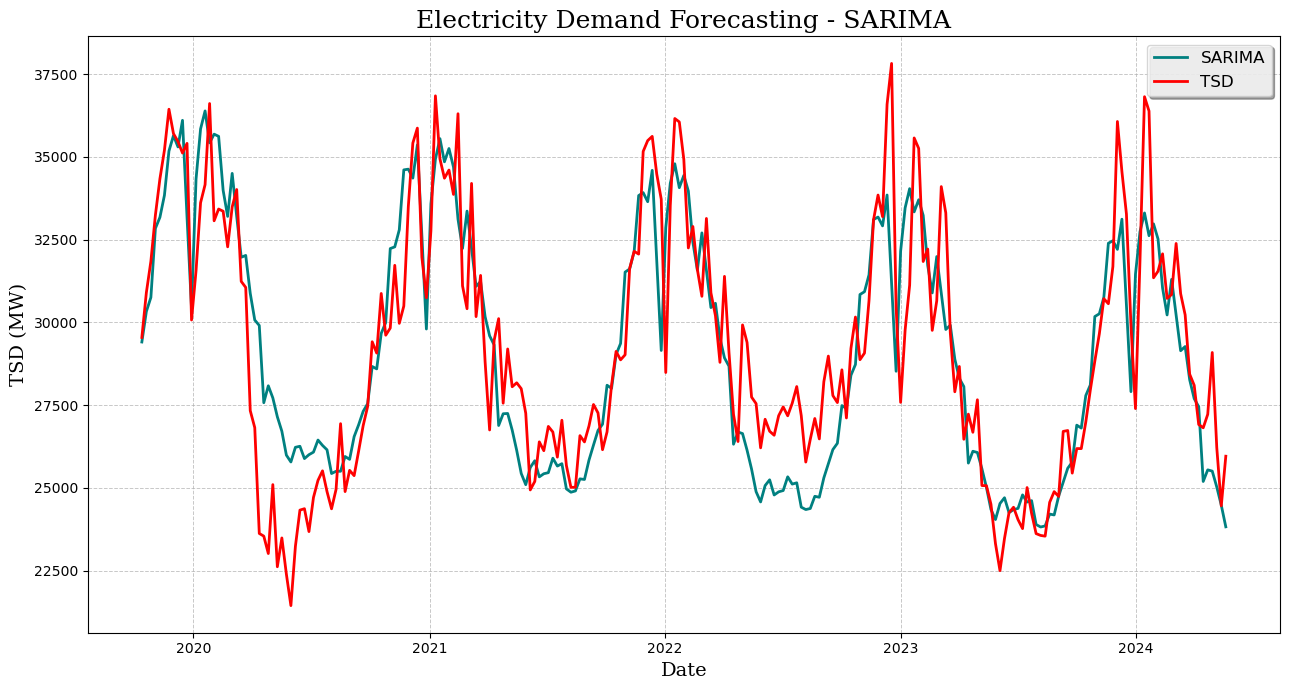

<Figure size 640x480 with 0 Axes>

In [342]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Creating the plot
plt.figure(figsize=(13, 7))  # Larger figure for better visibility

# Plot for SARIMA with enhanced style
plt.plot(output.index, output['sarima'], label='SARIMA', color='teal', linewidth=2)

# Plot for TSD with enhanced style
plt.plot(output.index, output['tsd'], label='TSD', color='red', linewidth=2)

# Add title and labels with enhanced font sizes and font family
plt.title('Electricity Demand Forecasting - SARIMA', fontsize=18, fontfamily='serif')
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')

# Customize the legend for better visibility
plt.legend(fontsize=12, loc='best', frameon=True, framealpha=0.8, fancybox=True, shadow=True)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)


# Ensure everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
plt.savefig('enhanced_actual_vs_predicted.png', dpi=300)


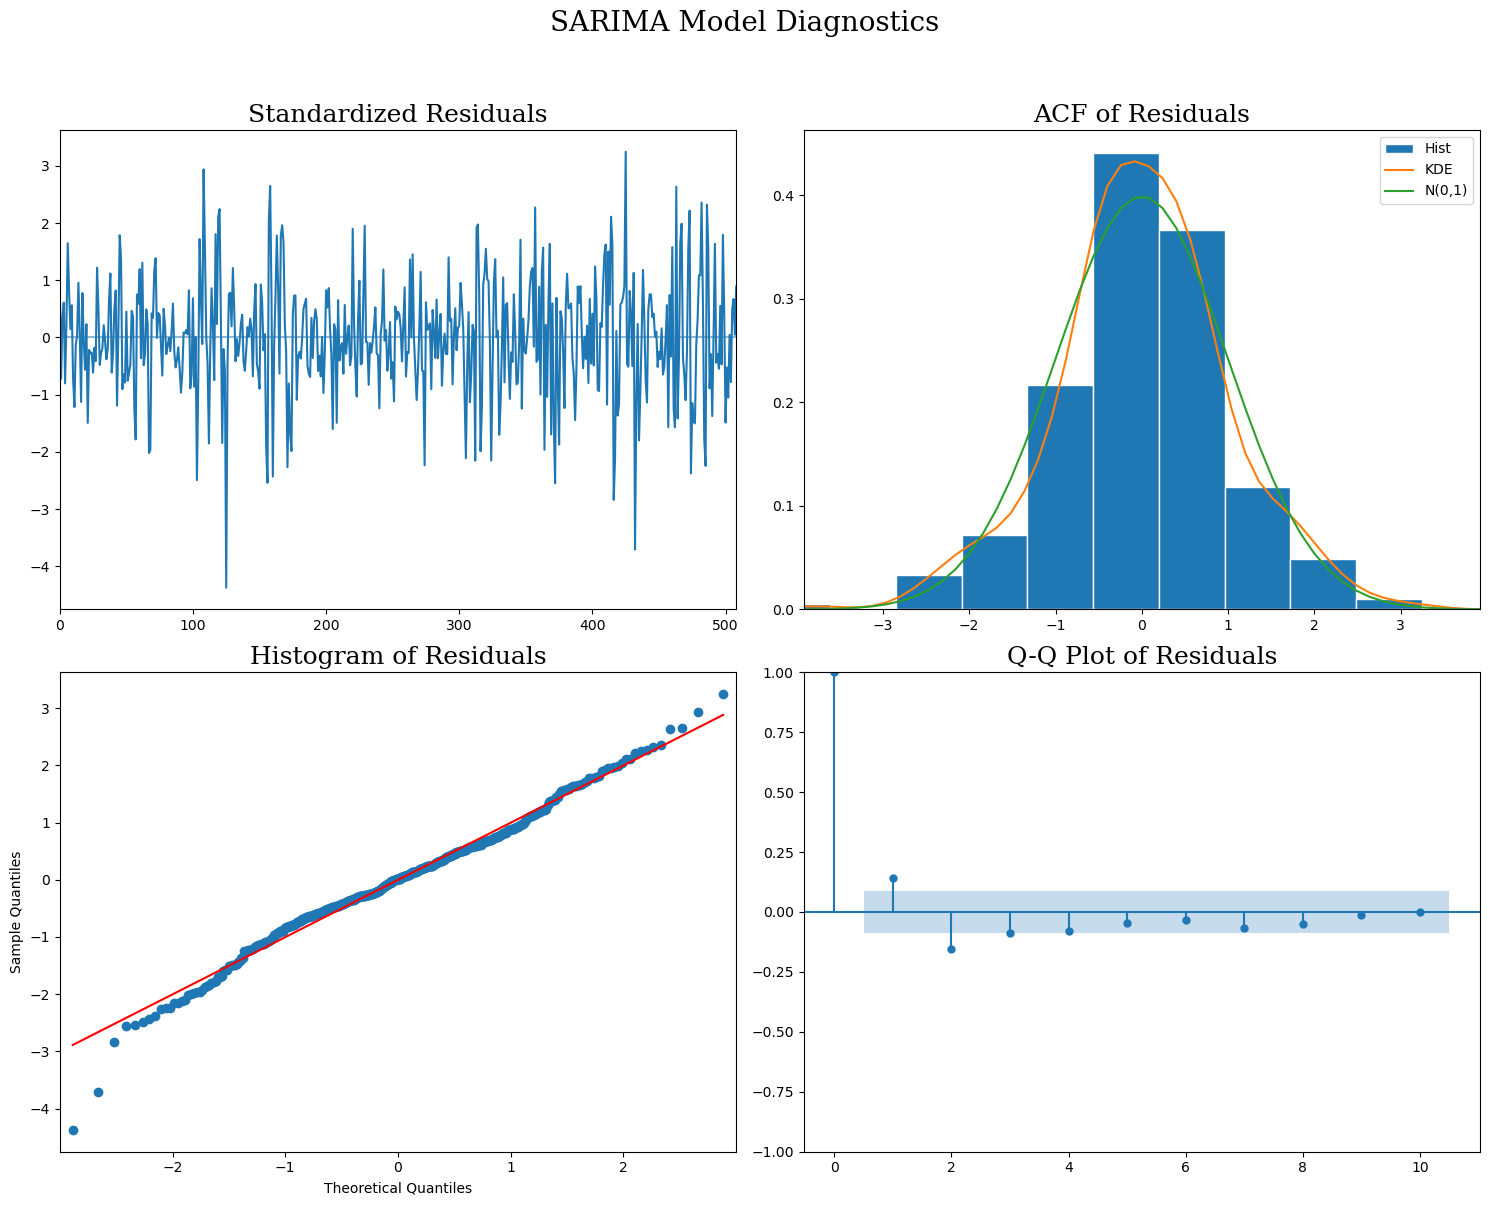

In [241]:
import matplotlib.pyplot as plt

# Generate the diagnostic plots
fig = sarima_model_3.plot_diagnostics(figsize=(15, 12))

# Add a common title
fig.suptitle('SARIMA Model Diagnostics', fontsize=20, fontfamily='serif', y=1)

# Access each subplot and update titles with different font properties
# Plot 1: Standardized residuals
ax1 = fig.axes[0]
ax1.set_title('Standardized Residuals', fontsize=18, fontfamily='serif')

# Plot 2: ACF of residuals
ax2 = fig.axes[1]
ax2.set_title('ACF of Residuals', fontsize=18, fontfamily='serif')

# Plot 3: Histogram of residuals
ax3 = fig.axes[2]
ax3.set_title('Histogram of Residuals', fontsize=18, fontfamily='serif')

# Plot 4: Q-Q plot of residuals
ax4 = fig.axes[3]
ax4.set_title('Q-Q Plot of Residuals', fontsize=18, fontfamily='serif')

# Adjust layout to prevent overlap
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust the top space to accommodate the title

plt.show()


## LSTM

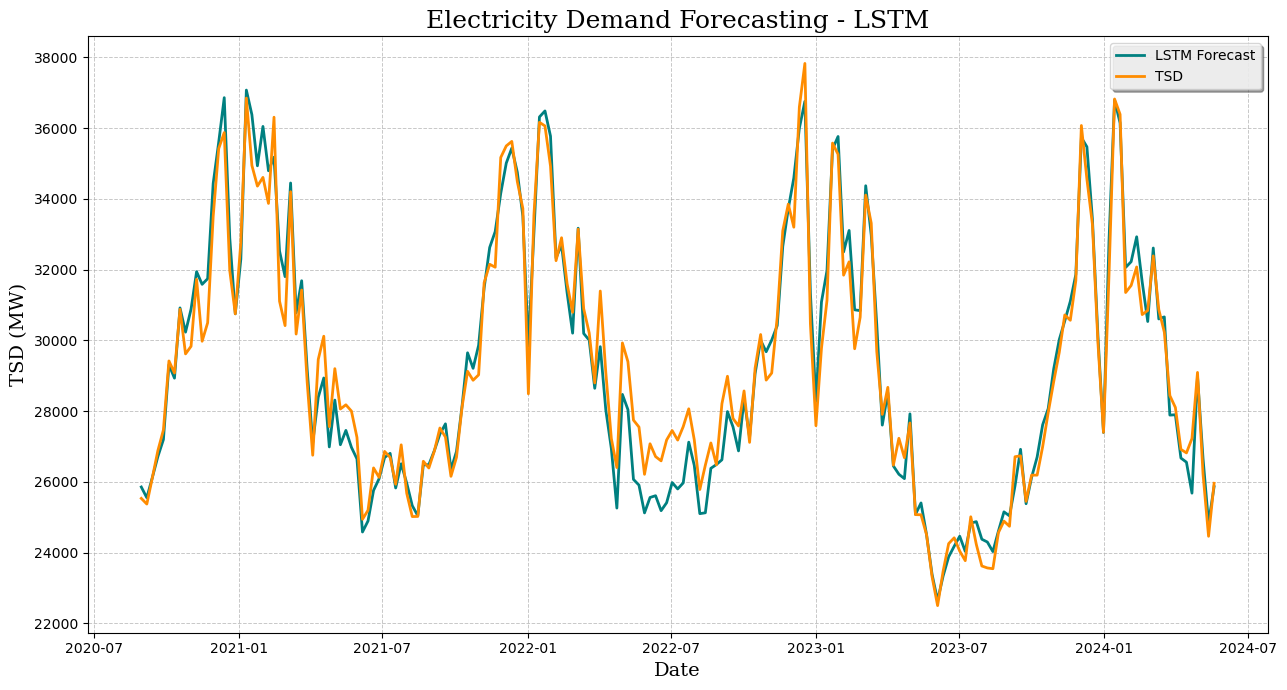

In [254]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Creating the plot
plt.figure(figsize=(13, 7))  # Larger figure for better visibility

# Plot for SARIMA with enhanced style
plt.plot(output_lstm.index, output_lstm['lstm'], label='LSTM Forecast', color='teal', linewidth=2)

# Plot for TSD with enhanced style
plt.plot(output_lstm.index, output_lstm['tsd'], label='TSD', color='darkorange', linewidth=2)

# Add title and labels with enhanced font sizes and font family
plt.title('Electricity Demand Forecasting - LSTM', fontsize=18, fontfamily='serif')
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')

# Customize the legend for better visibility
plt.legend(fontsize=10, loc='best', frameon=True, framealpha=0.8, fancybox=True, shadow=True)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)


# Ensure everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
# plt.savefig('enhanced_actual_vs_predicted.png', dpi=300)


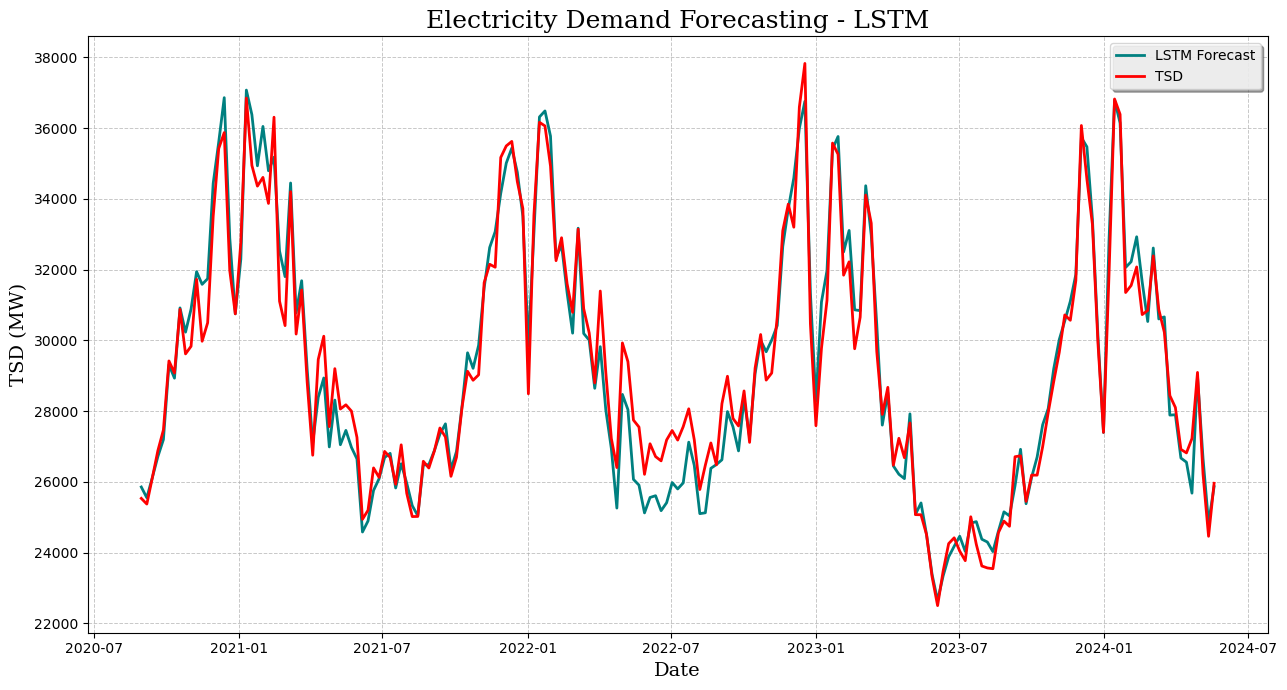

In [341]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Creating the plot
plt.figure(figsize=(13, 7))  # Larger figure for better visibility

# Plot for SARIMA with enhanced style
plt.plot(output_lstm.index, output_lstm['lstm'], label='LSTM Forecast', color='teal', linewidth=2)

# Plot for TSD with enhanced style
plt.plot(output_lstm.index, output_lstm['tsd'], label='TSD', color='red', linewidth=2)

# Add title and labels with enhanced font sizes and font family
plt.title('Electricity Demand Forecasting - LSTM', fontsize=18, fontfamily='serif')
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')

# Customize the legend for better visibility
plt.legend(fontsize=10, loc='best', frameon=True, framealpha=0.8, fancybox=True, shadow=True)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)


# Ensure everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
# plt.savefig('enhanced_actual_vs_predicted.png', dpi=300)


7/7 [==============================] - 1s 4ms/step


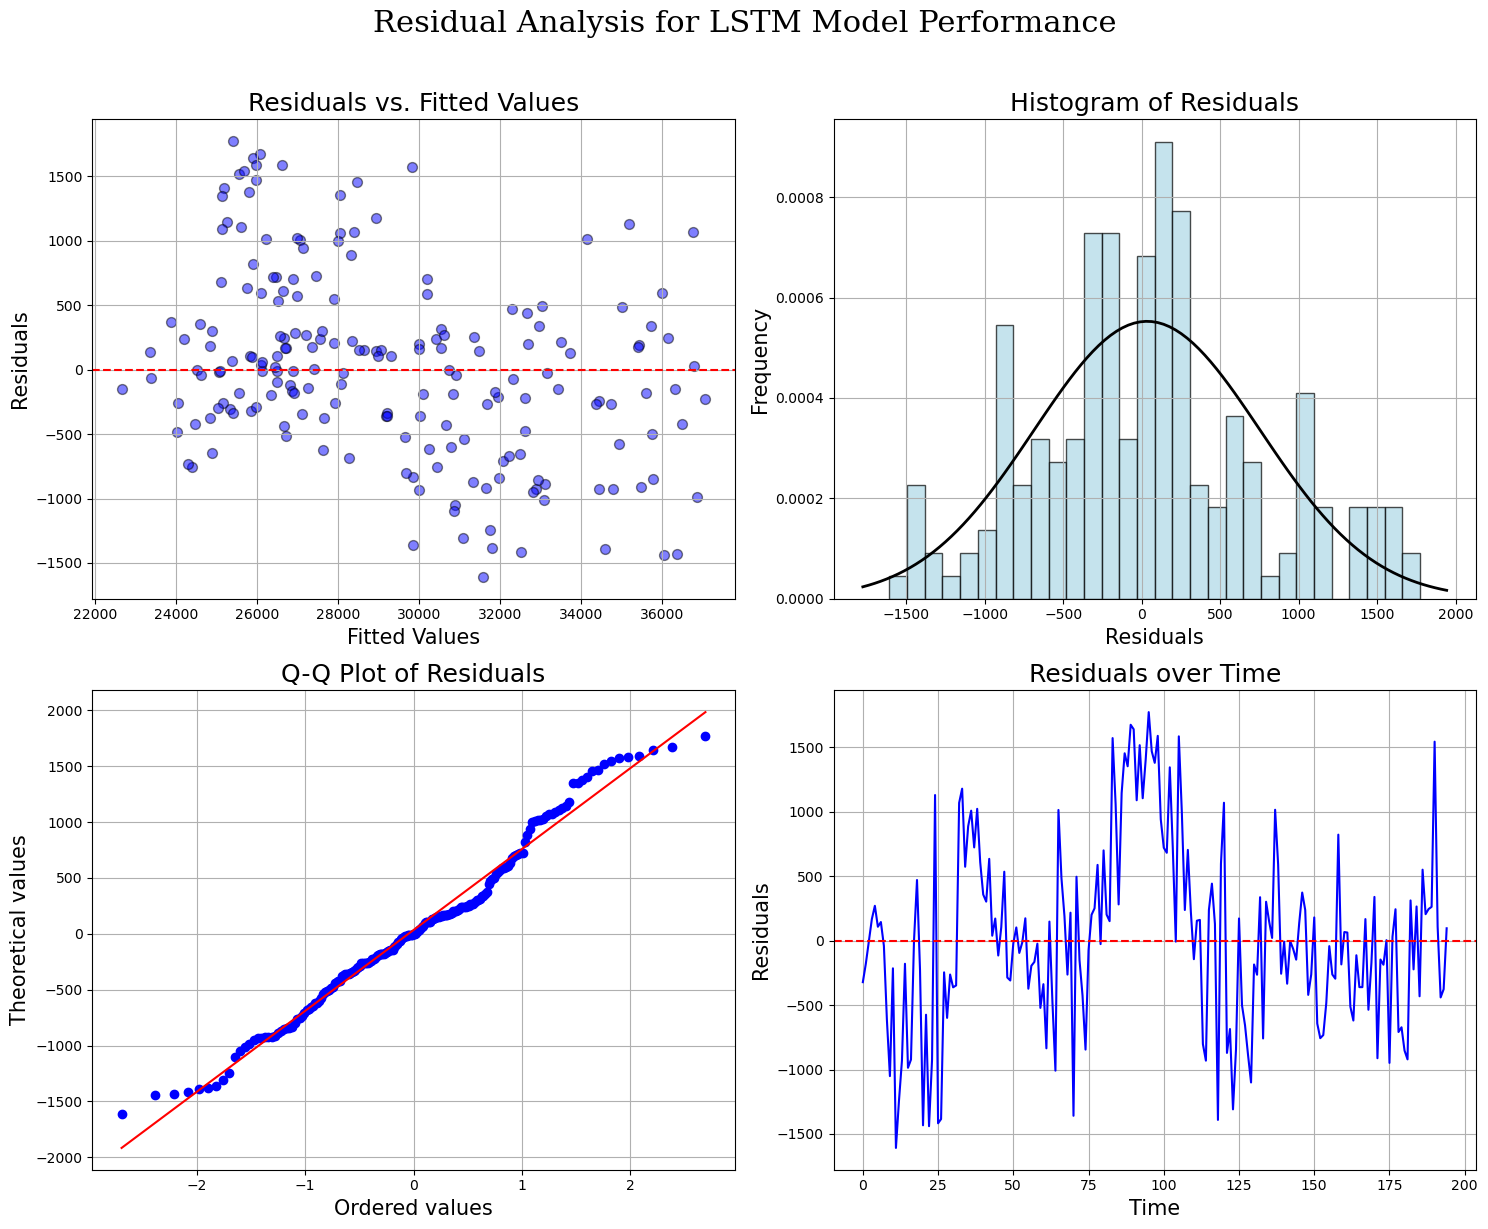

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Predict on the test set
predicted_scaled = model.predict(X_test_data)

# Inverse transform the predictions and original test data
# Concatenate with original scaled input (except the last column which was predicted)
predicted_values = scaler.inverse_transform(np.concatenate((X_test_data[:, 0, :], predicted_scaled), axis=1))[:, -1]
original_values = scaler.inverse_transform(np.concatenate((X_test_data[:, 0, :], y_test_data.reshape(-1, 1)), axis=1))[:, -1]

# Calculate residuals
residuals = original_values - predicted_values

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
# Common title for the whole figure
fig.suptitle('Residual Analysis for LSTM Model Performance', fontsize=22,y=1.02,fontfamily='serif')
# 1. Residuals vs. Fitted Values
axs[0, 0].scatter(predicted_values, residuals, alpha=0.5, c='blue', edgecolors='k', s=50)
axs[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axs[0, 0].set_xlabel('Fitted Values', fontsize=15)
axs[0, 0].set_ylabel('Residuals', fontsize=15)
axs[0, 0].set_title('Residuals vs. Fitted Values', fontsize=18)
axs[0, 0].grid(True)

# 2. Histogram of Residuals
axs[0, 1].hist(residuals, bins=30, alpha=0.7, color='lightblue', edgecolor='black', density=True)
xmin, xmax = axs[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
axs[0, 1].plot(x, p, 'k', linewidth=2)
axs[0, 1].set_xlabel('Residuals', fontsize=15)
axs[0, 1].set_ylabel('Frequency', fontsize=15)
axs[0, 1].set_title('Histogram of Residuals', fontsize=18)
axs[0, 1].grid(True)

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axs[1, 0])
axs[1, 0].get_lines()[1].set_color('red')  # Change color of reference line
axs[1, 0].set_title('Q-Q Plot of Residuals', fontsize=18)
axs[1, 0].set_xlabel('Ordered values',fontsize=15)
axs[1, 0].set_ylabel('Theoretical values',fontsize=15)
axs[1, 0].grid(True)

# 4. Residuals over Time
axs[1, 1].plot(residuals, color='blue', linestyle='-', linewidth=1.5)
axs[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axs[1, 1].set_xlabel('Time', fontsize=15)
axs[1, 1].set_ylabel('Residuals', fontsize=15)
axs[1, 1].set_title('Residuals over Time', fontsize=18)
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


## XGBoost

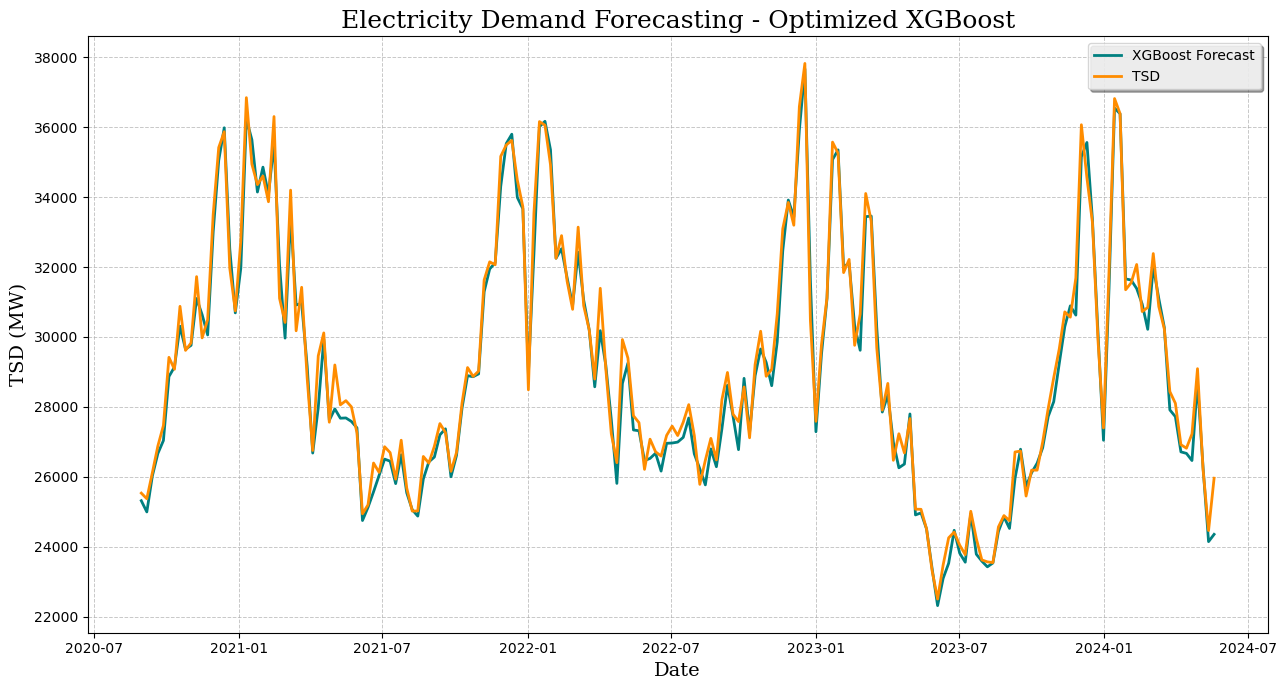

In [256]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Creating the plot
plt.figure(figsize=(13, 7))  # Larger figure for better visibility

# Plot for SARIMA with enhanced style
plt.plot(combined_df.index, combined_df['XGBoost_cv'], label='XGBoost Forecast', color='teal', linewidth=2)

# Plot for TSD with enhanced style
plt.plot(combined_df.index, combined_df['TSD'], label='TSD', color='darkorange', linewidth=2)

# Add title and labels with enhanced font sizes and font family
plt.title('Electricity Demand Forecasting - Optimized XGBoost', fontsize=18, fontfamily='serif')
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')

# Customize the legend for better visibility
plt.legend(fontsize=10, loc='best', frameon=True, framealpha=0.8, fancybox=True, shadow=True)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)


# Ensure everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
# plt.savefig('enhanced_actual_vs_predicted.png', dpi=300)


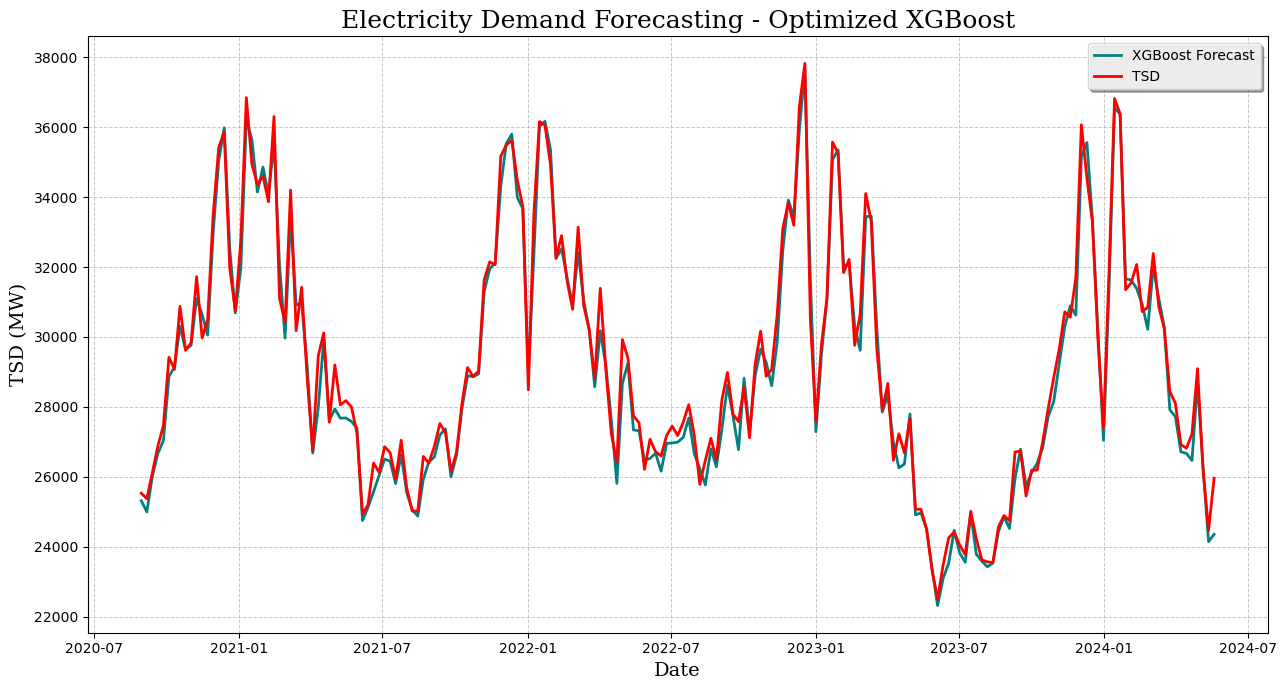

In [336]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Creating the plot
plt.figure(figsize=(13, 7))  # Larger figure for better visibility

# Plot for SARIMA with enhanced style
plt.plot(combined_df.index, combined_df['XGBoost_cv'], label='XGBoost Forecast', color='teal', linewidth=2)

# Plot for TSD with enhanced style
plt.plot(combined_df.index, combined_df['TSD'], label='TSD', color='red', linewidth=2)

# Add title and labels with enhanced font sizes and font family
plt.title('Electricity Demand Forecasting - Optimized XGBoost', fontsize=18, fontfamily='serif')
plt.xlabel('Date', fontsize=14, fontfamily='serif')
plt.ylabel('TSD (MW)', fontsize=14, fontfamily='serif')

# Customize the legend for better visibility
plt.legend(fontsize=10, loc='best', frameon=True, framealpha=0.8, fancybox=True, shadow=True)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)


# Ensure everything fits well
plt.tight_layout()

# Show the enhanced plot
plt.show()

# Save the plot as a PNG file with high resolution
# plt.savefig('enhanced_actual_vs_predicted.png', dpi=300)


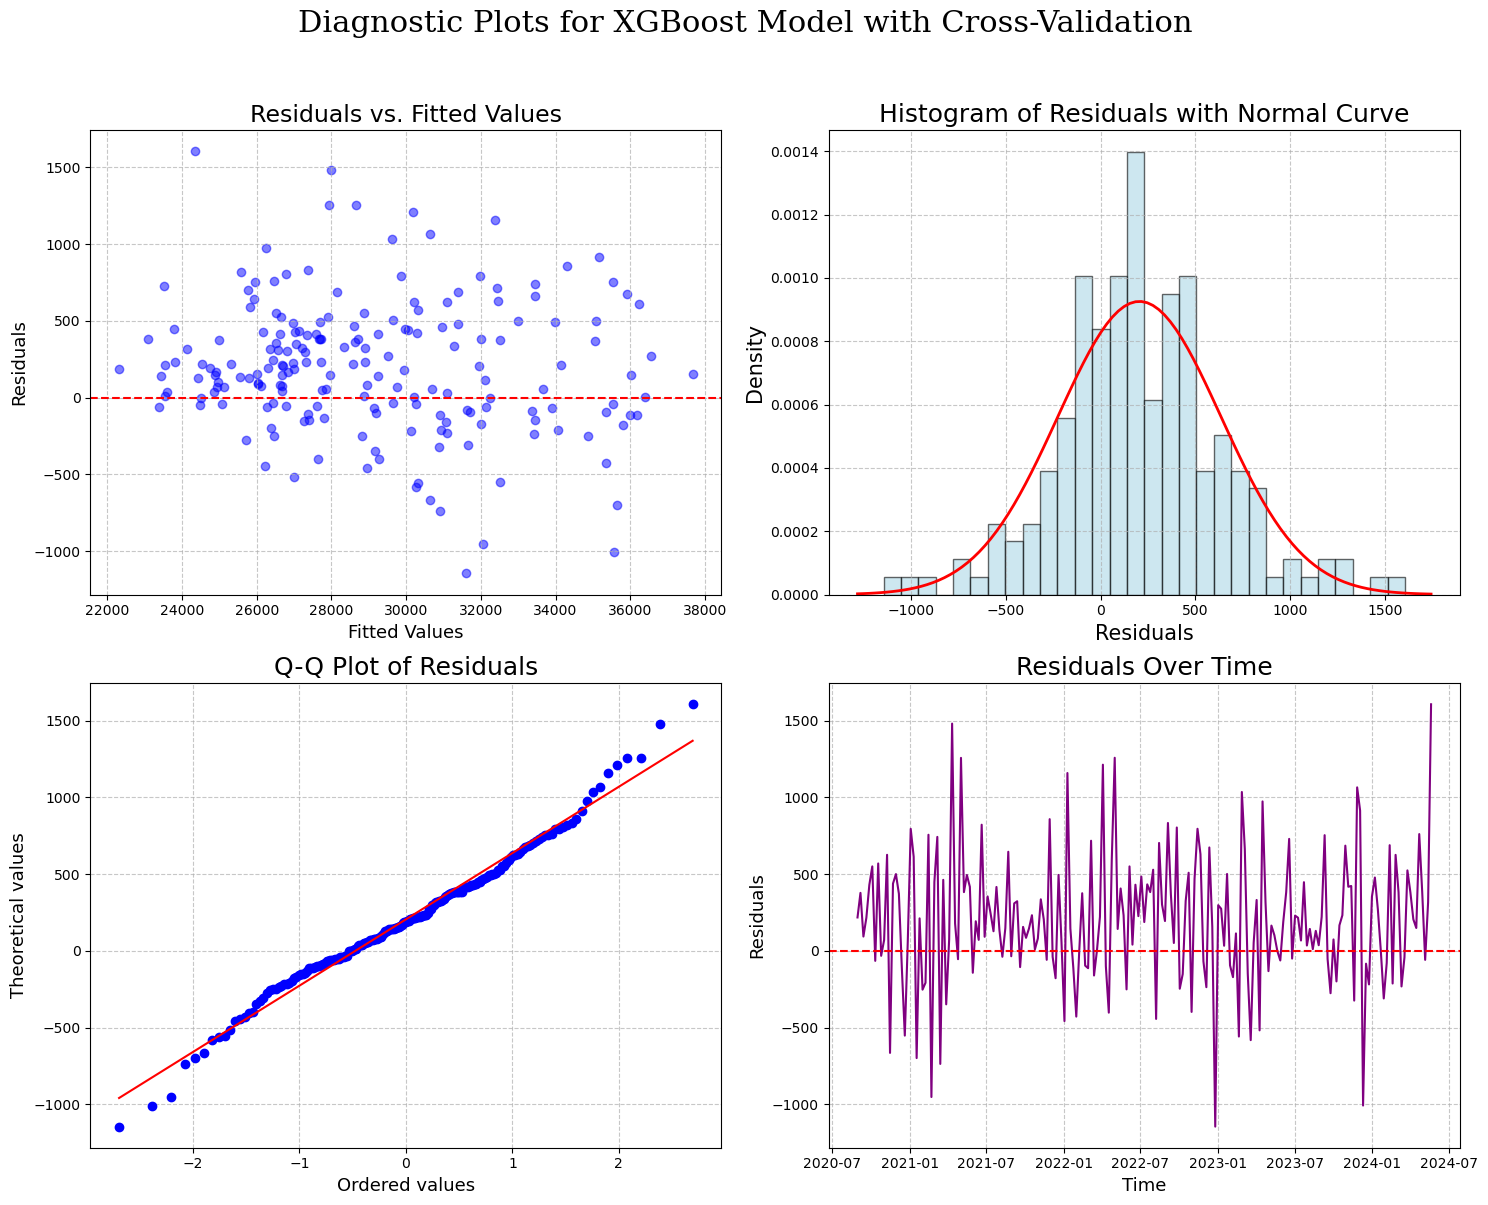

In [333]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Assuming `combined_df` is your DataFrame
# Extract relevant columns
actual_values = combined_df['TSD']
predicted_values = combined_df['XGBoost_cv']

# Calculate residuals
residuals = actual_values - predicted_values

# Create a figure with 4 subplots
plt.figure(figsize=(15, 12))

# 1. Residuals vs. Fitted Values
plt.subplot(2, 2, 1)
plt.scatter(predicted_values, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values', fontsize=13)
plt.ylabel('Residuals', fontsize=13)
plt.title('Residuals vs. Fitted Values', fontsize=17)
plt.grid(True, linestyle='--', alpha=0.7)

# 2. Histogram of Residuals with Normal Curve
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, color='lightblue', edgecolor='black', density=True, alpha=0.6)  # Normalize the histogram
# Calculate the mean and std of the residuals
mean_resid = np.mean(residuals)
std_resid = np.std(residuals)
# Generate values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_resid, std_resid)
# Plot the normal distribution curve
plt.plot(x, p, 'r', linewidth=2)
plt.xlabel('Residuals', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title('Histogram of Residuals with Normal Curve', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

# 3. Q-Q Plot
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Ordered values', fontsize=13)
plt.ylabel('Theoretical values', fontsize=13)

# 4. Residuals Over Time
plt.subplot(2, 2, 4)
plt.plot(residuals, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time', fontsize=13)
plt.ylabel('Residuals', fontsize=13)
plt.title('Residuals Over Time', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a common title and adjust layout
plt.suptitle('Diagnostic Plots for XGBoost Model with Cross-Validation', fontsize=22, fontfamily='serif', y=1)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top space to accommodate the title

# Show the plot
plt.show()
